# Image Reconstruction


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz
!tar -xzvf cifar-10-binary.tar.gz

--2025-12-21 03:48:07--  https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170052171 (162M) [application/x-gzip]
Saving to: ‘cifar-10-binary.tar.gz.1’

cifar-10-binary.tar 100%[===================>] 162.17M  9.13MB/s    in 19s     

2025-12-21 03:48:27 (8.36 MB/s) - ‘cifar-10-binary.tar.gz.1’ saved [170052171/170052171]

cifar-10-batches-bin/
cifar-10-batches-bin/data_batch_1.bin
cifar-10-batches-bin/batches.meta.txt
cifar-10-batches-bin/data_batch_3.bin
cifar-10-batches-bin/data_batch_4.bin
cifar-10-batches-bin/test_batch.bin
cifar-10-batches-bin/readme.html
cifar-10-batches-bin/data_batch_5.bin
cifar-10-batches-bin/data_batch_2.bin


## 1) CPU:

In [3]:
%%writefile load_data.h
#pragma once
#include <stdint.h>
#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#define TRAIN_NUM    50000
#define TEST_NUM     10000
#define IMG_SIZE     (32*32*3)     // 3072

typedef struct {
    float* train_images;   // [50000 * 3072]
    float* test_images;    // [10000 * 3072]
    uint8_t* train_labels; // [50000]
    uint8_t* test_labels;  // [10000]
    int* train_indices;
} Cifar10;

void load_cifar10(Cifar10* data);
void normalize_cifar10(Cifar10* data);
void shuffle_cifar10(Cifar10* data);
void get_next_batch(Cifar10* data, size_t batch_size, size_t batch_id, float* batch_images);
void print_cifar10(Cifar10* data);
void free_cifar10(Cifar10* data);

Overwriting load_data.h


In [4]:
%%writefile load_data.c
#include "load_data.h"

static void read_batch(const char* filename, float* images_start, uint8_t* labels) {
    FILE* f = fopen(filename, "rb");
    if (!f) {
        perror(filename);
        exit(EXIT_FAILURE);
    }

    uint8_t buffer[3073];
    for (int i = 0; i < 10000; i++) {
        if (fread(buffer, 1, 3073, f) != 3073) {
            fprintf(stderr, "Error: incomplete read in %s at image %d\n", filename, i);
            fclose(f);
            exit(EXIT_FAILURE);
        }
        labels[i] = buffer[0];
        for (int j = 0; j < 3072; j++) {
            images_start[i * 3072 + j] = (float)buffer[1 + j];  //Covert unit8 to float
        }
    }
    fclose(f);
}

void load_cifar10(Cifar10* data) {
    data->train_images = (float*)malloc(TRAIN_NUM * IMG_SIZE * sizeof(float));
    data->test_images  = (float*)malloc(TEST_NUM  * IMG_SIZE * sizeof(float));
    data->train_labels = (uint8_t*)malloc(TRAIN_NUM * sizeof(uint8_t));
    data->test_labels  = (uint8_t*)malloc(TEST_NUM  * sizeof(uint8_t));

    if (!data->train_images || !data->test_images ||
        !data->train_labels  || !data->test_labels) {
        fprintf(stderr, "ERROR: Memory allocation failed!\n");
        exit(EXIT_FAILURE);
    }

    data->train_indices = (int*)malloc(TRAIN_NUM * sizeof(int));
    for (int i = 0; i < TRAIN_NUM; i++) {
        data->train_indices[i] = i;
    }

    //Load training data
    for (int i = 1; i <= 5; i++) {
        char filename[100];
        snprintf(filename, sizeof(filename), "cifar-10-batches-bin/data_batch_%d.bin", i);
        read_batch(filename,
                   data->train_images + (i-1) * 10000 * IMG_SIZE,
                   data->train_labels + (i-1) * 10000);
    }

    //Load test data
    read_batch("cifar-10-batches-bin/test_batch.bin",
               data->test_images, data->test_labels);

    printf("CIFAR-10 loaded successfully\n");
}

void normalize_cifar10(Cifar10* data) {
    for (size_t i = 0; i < TRAIN_NUM * IMG_SIZE; i++) {
        data->train_images[i] /= 255.0f;
    }
    for (size_t i = 0; i < TEST_NUM * IMG_SIZE; i++) {
        data->test_images[i] /= 255.0f;
    }
}

// Shuffle indices
void shuffle_cifar10(Cifar10* data) {
    for (int i = TRAIN_NUM - 1; i > 0; i--) {
        int j = rand() % (i + 1);
        int temp = data->train_indices[i];
        data->train_indices[i] = data->train_indices[j];
        data->train_indices[j] = temp;
    }
}

void get_next_batch(Cifar10* data, size_t batch_size, size_t batch_id, float* batch_images) {
    size_t start = batch_id * batch_size;
    for (size_t i = 0; i < batch_size; i++) {
        int idx = data->train_indices[start + i];

        memcpy(batch_images + i * IMG_SIZE,
               data->train_images + idx * IMG_SIZE,
               IMG_SIZE * sizeof(float));
    }
}

void print_cifar10(Cifar10* data){
    for (int i = 0; i < 2; i++) {
        printf("Label: %d\n", data->train_labels[i]);
        for (int j = 0; j < IMG_SIZE; j++) {
            printf("%f ", data->train_images[i*IMG_SIZE + j]);
        }
        printf("\n");
    }
    // for (int i = 0; i < 2; i++) {
    //     printf("Label: %d\n", data->test_labels[i]);
    //     for (int j = 0; j < IMG_SIZE; j++) {
    //         printf("%f ", data->test_images[i*IMG_SIZE + j]);
    //     }
    // }
}

void free_cifar10(Cifar10* data) {
    free(data->train_images);
    free(data->test_images);
    free(data->train_labels);
    free(data->test_labels);
    free(data->train_indices);

    data->train_images = data->test_images = NULL;
    data->train_labels = data->test_labels = NULL;
    data->train_indices = NULL;
}

Overwriting load_data.c


In [5]:
%%writefile cpu_layers.h
#pragma once
#include <stdio.h>
#include <float.h>

void Relu(float* input, int N, float* output);
void Conv2D_Forward(float* input, int input_width, int input_height, int input_channels,
    float* kernel, int kernel_width, int kernel_height,
    float* biases, int padding, int stride, int filter_count,
    float* output, int output_height, int output_width);
void MaxPool2D_Forward(float* input, int input_width, int input_height,
    int filter_width, int filter_height, int stride, int filter_count,
    float* output, int output_height, int output_width);
void UpSample2D_Forward(float* input, int input_width, int input_height,
    int scale_factor, int filter_count,
    float* output, int output_height, int output_width);
float MSE(float* input, float* output, int size);
void Relu_Backward(float* d_output, float* input,int N);
void MSE_Gradient(float* input, float* output, int size, float* d_output);
void UpSample2D_Backward(float* d_output, int d_output_width, int d_output_height, int scale_factor, int filter_count,
    float* d_input, int d_input_height, int d_input_width);
void MaxPool2D_Backward(float* d_output, int d_output_width, int d_output_height, float* input,
    int input_width, int input_height, int filter_width, int filter_height, int stride, int filter_count, float* d_input);
void Conv2D_Backward_Input(float* d_output, int d_output_width, int d_output_height, float* kernel, int kernel_width, int kernel_height,
    int input_width, int input_height, int input_channels, int padding, int stride, int filter_count, float* d_input);
void Conv2D_Backward_Kernel(float* d_output, int d_output_width, int d_output_height, float* input,
    int input_width, int input_height, int input_channels, int kernel_width, int kernel_height, int padding, int stride, int filter_count, float* d_weights);
void Conv2D_Backward_Biases(float* d_output, int d_output_width, int d_output_height, int filter_count, float* d_biases);
void SGD_Update(float* weights, float* d_weights, double learning_rate, int N_params);


Overwriting cpu_layers.h


In [6]:
%%writefile cpu_layers.c
#include "cpu_layers.h"

void Relu(float* input, int N, float* output) {
    for (int i = 0; i < N; i++) {
        output[i] = input[i] > 0.0f ? input[i] : 0.0f;
    }
}

void Conv2D_Forward(float* input, int input_width, int input_height, int input_channels,
    float* kernel, int kernel_width, int kernel_height,
    float* biases, int padding, int stride, int filter_count,
    float* output, int output_height, int output_width)
{
    // // Tính toán kích thước output
    // int H_out = (input_height + 2 * padding - kernel_height) / stride + 1;
    // int W_out = (input_width + 2 * padding - kernel_width) / stride + 1;
    // int output_size = filter_count * H_out * W_out;
    // output = (float*)malloc(output_size * sizeof(float));
    // if (output == NULL) {
    //     fprintf(stderr, "ERROR: Memory allocation failed!\n");
    //     return;
    // }
    // Lặp qua kênh đầu ra (filter)
    for (int c_out = 0; c_out < filter_count; c_out++) {
        // Lặp qua chiều cao output
        for (int h_out = 0; h_out < output_height; h_out++) {
            // Lặp qua chiều rộng output
            for (int w_out = 0; w_out < output_width; w_out++) {
                float sum = 0.0f;
                // Lặp qua kênh đầu vào (c_in)
                for (int c_in = 0; c_in < input_channels; c_in++) {
                    // Lặp qua kernel height
                    for (int k_h = 0; k_h < kernel_height; k_h++) {
                        // Lặp qua kernel width
                        for (int k_w = 0; k_w < kernel_width; k_w++) {
                            // Vị trí input tương ứng
                            int h_in = h_out * stride + k_h - padding;
                            int w_in = w_out * stride + k_w - padding;
                            float val = 0.0f;
                            // Kiểm tra zero padding
                            if (h_in >= 0 && h_in < input_height && w_in >= 0 && w_in < input_width) {
                                int channel_size = input_width * input_height;
                                val = input[c_in * channel_size + h_in * input_width + w_in];
                            }

                            int weight_idx = c_out * input_channels * kernel_height * kernel_width + c_in * kernel_height * kernel_width +
                                            k_h * kernel_width + k_w;

                            sum += val * kernel[weight_idx];
                        }
                    }
                }
                sum += biases[c_out];  // Thêm bias
                int output_idx = h_out * output_width + w_out + c_out * output_width * output_height;
                output[output_idx] = sum;
            }
        }
    }
}


void MaxPool2D_Forward(float* input, int input_width, int input_height, int filter_width, int filter_height, int stride, int filter_count,
    float* output, int output_height, int output_width) {
    // int H_out = (input_height - filter_height) / stride + 1;
    // int W_out = (input_width - filter_width) / stride + 1;

    int plane_size_in = input_height * input_width;
    int plane_size_out = output_height * output_width;
    for (int c = 0; c < filter_count; c++) {
        for (int h_out = 0; h_out < output_height; h_out++) {
            for (int w_out = 0; w_out < output_width; w_out++) {
                float max_val = -FLT_MAX;
                int h_start = h_out * stride;
                int w_start = w_out * stride;
                for (int fh = 0; fh < filter_height; fh++) {
                    for (int fw = 0; fw < filter_width; fw++) {
                        int h_in = h_start + fh;
                        int w_in = w_start + fw;
                        int input_idx = c * plane_size_in + h_in * input_width + w_in;
                        float val = input[input_idx];
                        if (val > max_val) {
                            max_val = val;
                        }
                    }
                }
                int output_idx = c * plane_size_out + h_out * output_width + w_out;
                output[output_idx] = max_val;
            }
        }
    }
}

void UpSample2D_Forward(float* input, int input_width, int input_height,
int scale_factor, int filter_count, float* output, int output_height, int output_width) {
    int plane_size_in = input_height * input_width;
    int plane_size_out = output_height * output_width;
    for (int c = 0; c < filter_count; c++) {
        for (int h_in = 0; h_in < input_height; h_in++) {
            for (int w_in = 0; w_in < input_width; w_in++) {
                float val = input[c * plane_size_in + h_in * input_width + w_in];
                for (int sh = 0; sh < scale_factor; sh++) { // Gấp đôi hàng
                    for (int sw = 0; sw < scale_factor; sw++) { // Gấp đôi cột
                        int h_out = h_in * scale_factor + sh;
                        int w_out = w_in * scale_factor + sw;
                        int output_idx = c * plane_size_out + h_out * output_width + w_out;
                        output[output_idx] = val;
                    }
                }
            }
        }
    }
}

float MSE(float* input, float* output, int size) {
    float sum = 0.0f;
    for (int i = 0; i < size; i++) {
        sum += (output[i] - input[i]) * (output[i] - input[i]);
    }
    return sum / size;
}

void Relu_Backward(float* d_output, float* input,int N) {
    for (int i = 0; i < N; i++) {
        d_output[i] = input[i] > 0.0f ? d_output[i] : 0.0f;
    }
}

void MSE_Gradient(float* input, float* output, int size, float* d_output) {
    float sum = 0.0f;
    float factor = 2.0f / size;
    for (int i = 0; i < size; i++) {
        d_output[i] = factor * (output[i] - input[i]);
    }
}

void MaxPool2D_Backward(float* d_output, int d_output_width, int d_output_height, float* input,
    int input_width, int input_height, int filter_width, int filter_height, int stride, int filter_count,
    float* d_input)
{
    // Chỉ gán vị trí giá trị max của input ban đầu là gradient của lớp tiếp theo (d_output), còn lại là 0
    int plane_size_in = input_height * input_width;
    int plane_size_out = d_output_height * d_output_width;
    int total_input_size = filter_count * plane_size_in;
    for (int i = 0; i < total_input_size; i++) { // Khởi tạo gradient của input ban đầu là 0
        d_input[i] = 0.0f;
    }

    for (int c = 0; c < filter_count; c++) {

        int channel_offset_in = c * plane_size_in;
        int channel_offset_out = c * plane_size_out;

        for (int h_out = 0; h_out < d_output_height; h_out++) {
            for (int w_out = 0; w_out < d_output_width; w_out++) {

                int h_start = h_out * stride;
                int w_start = w_out * stride;

                float max_val = -FLT_MAX;
                int max_input_idx = -1;

                for (int fh = 0; fh < filter_height; fh++) {
                    for (int fw = 0; fw < filter_width; fw++) {
                        int h_in = h_start + fh;
                        int w_in = w_start + fw;
                        int input_idx = channel_offset_in + h_in * input_width + w_in;
                        float val = input[input_idx];
                        if (val > max_val) {
                            max_val = val;
                            max_input_idx = input_idx;
                        }
                    }
                }
                //Lấy gradient từ output
                if (max_input_idx != -1) {
                    int output_idx = channel_offset_out + h_out * d_output_width + w_out;
                    d_input[max_input_idx] += d_output[output_idx];
                }
            }
        }
    }
}

void UpSample2D_Backward(float* d_output, int d_output_width, int d_output_height, int scale_factor, int filter_count,
    float* d_input, int d_input_height, int d_input_width) {

    int plane_size_in = d_input_height * d_input_width;
    int plane_size_out = d_output_height * d_output_width;
    int total_input_size = filter_count * plane_size_in;
    for (int i = 0; i < total_input_size; i++) {
        d_input[i] = 0.0f;
    }
    for (int c = 0; c < filter_count; c++) {
        int channel_offset_in = c * plane_size_in;
        int channel_offset_out = c * plane_size_out;
        // Lặp qua input grid (d_input)
        for (int h_in = 0; h_in < d_input_height; h_in++) {
            for (int w_in = 0; w_in < d_input_width; w_in++) {
                float sum_gradient = 0.0f;
                int h_start_out = h_in * scale_factor;
                int w_start_out = w_in * scale_factor;
                for (int sh = 0; sh < scale_factor; sh++) {
                    for (int sw = 0; sw < scale_factor; sw++) {
                        int h_out = h_start_out + sh;
                        int w_out = w_start_out + sw;
                        if (h_out < d_output_height && w_out < d_output_width) {
                            int output_idx = channel_offset_out + h_out * d_output_width + w_out;
                            sum_gradient += d_output[output_idx];
                        }
                    }
                }
                int input_idx = channel_offset_in + h_in * d_input_width + w_in;
                d_input[input_idx] = sum_gradient;
            }
        }
    }
}

void Conv2D_Backward_Input(float* d_output, int d_output_width, int d_output_height, float* kernel, int kernel_width, int kernel_height,
    int input_width, int input_height, int input_channels, int padding, int stride, int filter_count, float* d_input) {
    // Thực hiện tích chập giữa dE/dO và kernel (xoay 180 độ) để tính dE/dI
    int plane_size_in = input_height * input_width;
    int plane_size_out = d_output_height * d_output_width;
    // Lặp qua kênh input (kênh output gradient)
    for (int c_in = 0; c_in < input_channels; c_in++) {
        // Lặp qua input grid (d_input)
        for (int h_in = 0; h_in < input_height; h_in++) {
            for (int w_in = 0; w_in < input_width; w_in++) {
                float sum_gradient = 0.0f;
                // Lặp qua kênh output (số lượng filter)
                for (int c_out = 0; c_out < filter_count; c_out++) {
                    // Lặp qua kernel (xoay 180 độ)
                    for (int kh = 0; kh < kernel_height; kh++) {
                        for (int kw = 0; kw < kernel_width; kw++) {
                            int h_out = h_in - kh + padding;
                            int w_out = w_in - kw + padding;
                            float d_output_val = 0.0f;
                            // Kiểm tra padding
                            if (h_out >= 0 && h_out < d_output_height && w_out >= 0 && w_out < d_output_width) {
                                int d_output_idx = c_out * plane_size_out + h_out * d_output_width + w_out;
                                d_output_val = d_output[d_output_idx];
                            }
                            // Tính chỉ số kernel (xoay 180 độ)
                            int kernel_idx = c_out * input_channels * kernel_height * kernel_width + c_in * kernel_height * kernel_width +
                                            (kernel_height - 1 - kh) * kernel_width + (kernel_width - 1 - kw);

                            sum_gradient += d_output_val * kernel[kernel_idx];
                        }
                    }
                }
                int d_input_idx = c_in * plane_size_in + h_in * input_width + w_in;
                d_input[d_input_idx] = sum_gradient;
            }
        }
    }
}

void Conv2D_Backward_Kernel(float* d_output, int d_output_width, int d_output_height, float* input,
int input_width, int input_height, int input_channels, int kernel_width, int kernel_height, int padding, int stride, int filter_count, float* d_weights) {
    // Thực hiện tích chập giữa dE/dO và input để tính dE/dW
    int plane_size_in = input_height * input_width;
    int plane_size_out = d_output_height * d_output_width;
    // Lặp qua kênh đầu ra (filter)
    for (int c_out = 0; c_out < filter_count; c_out++) {
        // Lặp qua kênh đầu vào
        for (int c_in = 0; c_in < input_channels; c_in++) {
            // Lặp qua kích thước kernel
            for (int k_h = 0; k_h < kernel_height; k_h++) {
                for (int k_w = 0; k_w < kernel_width; k_w++) {
                    float sum_gradient = 0.0f;
                    // Lặp qua output grid (d_output) để tích lũy
                    for (int h_out = 0; h_out < d_output_height; h_out++) {
                        for (int w_out = 0; w_out < d_output_width; w_out++) {
                            int h_in = h_out * stride + k_h - padding;
                            int w_in = w_out * stride + k_w - padding;
                            float input_val = 0.0f;
                            // Kiểm tra padding
                            if (h_in >= 0 && h_in < input_height && w_in >= 0 && w_in < input_width) {
                                int input_idx = c_in * plane_size_in + h_in * input_width + w_in;
                                input_val = input[input_idx];
                            }
                            int d_output_idx = c_out * plane_size_out + h_out * d_output_width + w_out;
                            float d_output_val = d_output[d_output_idx];
                            // Tính gradient
                            sum_gradient += input_val * d_output_val;
                        }
                    }
                    int kernel_idx = c_out * input_channels * kernel_height * kernel_width + c_in * kernel_height * kernel_width +
                                    k_h * kernel_width + k_w;
                    d_weights[kernel_idx] += sum_gradient;
                }
            }
        }
    }
}

void Conv2D_Backward_Biases(float* d_output, int d_output_width, int d_output_height,
    int filter_count, float* d_biases) {
    int plane_size_out = d_output_height * d_output_width;
    // Lặp qua từng filter
    for (int c_out = 0; c_out < filter_count; c_out++) {
        float sum_gradient = 0.0f;
        // Lặp qua từng vị trí trong output
        for (int h_out = 0; h_out < d_output_height; h_out++) {
            for (int w_out = 0; w_out < d_output_width; w_out++) {
                // Tính chỉ số trong mảng d_output
                int output_idx = c_out * plane_size_out + h_out * d_output_width + w_out;
                // Cộng dồn gradient từ d_output
                sum_gradient += d_output[output_idx];
            }
        }
        d_biases[c_out] += sum_gradient;
    }
}

void SGD_Update(float* weights, float* d_weights, double learning_rate, int N_params) {
    for (int i = 0; i < N_params; i++) {
        weights[i] -= (learning_rate * d_weights[i]);
    }
}

Overwriting cpu_layers.c


In [7]:
%%writefile cpu_autoencoder.h
#pragma once
#include "cpu_layers.h"
#include <stdlib.h>
#include <stdio.h>
#include <math.h>
#include <stdint.h>
#include <time.h>
#include <string.h>
// Định nghĩa kích thước Kernel/Stride/Padding
#define KERNEL_SIZE 3
#define POOL_SIZE 2
#define UPSAMPLE_SIZE 2
#define CONV_PADDING 1
#define CONV_STRIDE 1
#define POOL_STRIDE 2

typedef struct {
    int batch_size;
    double learning_rate;
    // kích thước input
    int input_height;       // 32
    int input_width;        // 32
    int input_channels;     // 3
    // weight, bias và gradient của từng lớp Conv2D
    float* w1; float* b1; float* d_w1; float* d_b1;
    float* w2; float* b2; float* d_w2; float* d_b2;
    float* w3; float* b3; float* d_w3; float* d_b3;
    float* w4; float* b4; float* d_w4; float* d_b4;
    float* w5; float* b5; float* d_w5; float* d_b5;

    float* batch_input;
    float* final_output;
    float* loss_gradient;
    // ouput và gradient của từng lớp Conv2D/MaxPool/UpSample
    float* conv1_output;   float* d_conv1_output;
    float* pool1_output;   float* d_pool1_output;
    float* conv2_output;   float* d_conv2_output;
    float* pool2_output;   float* d_pool2_output; // LATENT SPACE
    float* conv3_output;   float* d_conv3_output;
    float* upsample1_output; float* d_upsample1_output;
    float* conv4_output;   float* d_conv4_output;
    float* upsample2_output; float* d_upsample2_output;
} CPUAutoEncoder;

void random_initialize(float* array, int size, float min, float max);
void initialize_autoencoder(CPUAutoEncoder* autoencoder, int batch_size, double learning_rate);
void free_autoencoder(CPUAutoEncoder* autoencoder);
void forward_autoencoder(CPUAutoEncoder* autoencoder);
void backward_autoencoder(CPUAutoEncoder* autoencoder);
void update_autoencoder_parameters(CPUAutoEncoder* autoencoder);
void save_weights(CPUAutoEncoder* autoencoder, const char* filename);
void cpu_extract_features(CPUAutoEncoder* autoencoder, float* input_data, int num_images, float* features_output);
void cpu_load_weights(CPUAutoEncoder* autoencoder, const char* filename);

Overwriting cpu_autoencoder.h


In [8]:
%%writefile cpu_autoencoder.c
#include "cpu_autoencoder.h"

// Hàm khởi tạo mảng trọng số với giá trị ngẫu nhiên trong khoảng [min, max]
void random_initialize(float* array, int size, float min, float max) {
    for (int i = 0; i < size; i++) {
        float scale = (float)rand() / (float)RAND_MAX;
        array[i] = min + scale * (max - min);
    }
}

void zero_initialize(float* array, int size) {
    for (int i = 0; i < size; i++) {
        array[i] = 0.0f;
    }
}


void initialize_conv_layer(float** w, float** b, float** dw, float** db, int C_in, int C_out) {
    int size_W = C_out * C_in * KERNEL_SIZE * KERNEL_SIZE;
    *w = (float*)malloc(size_W * sizeof(float));
    *b = (float*)malloc(C_out * sizeof(float));
    *dw = (float*)malloc(size_W * sizeof(float));
    *db = (float*)malloc(C_out * sizeof(float));

    random_initialize(*w, size_W, -0.05f, 0.05f);
    random_initialize(*b, C_out, -0.05f, 0.05f);
    zero_initialize(*dw, size_W);
    zero_initialize(*db, C_out);
}

float* allocate_buffer(int batch_size, int H, int W, int C) {
    int size = batch_size * H * W * C;
    return (float*)malloc(size * sizeof(float));
}


void initialize_autoencoder(CPUAutoEncoder* autoencoder, int batch_size, double learning_rate) {
    // Tham số chung
    autoencoder->batch_size = batch_size;
    autoencoder->learning_rate = learning_rate;
    autoencoder->input_height = 32;
    autoencoder->input_width = 32;
    autoencoder->input_channels = 3;

    // Output channels của các lớp
    int C_in = 3, C1 = 256, C2 = 128, C3 = 128, C4 = 256, C5 = 3;
    // Kích thước không gian (Pixel/kênh)
    int P1 = 32 * 32, P2 = 16 * 16, P3 = 8 * 8;
    // Khởi tạo trọng số, bias và gradient cho từng lớp Conv2D
    initialize_conv_layer(&autoencoder->w1, &autoencoder->b1, &autoencoder->d_w1, &autoencoder->d_b1, C_in, C1);
    initialize_conv_layer(&autoencoder->w2, &autoencoder->b2, &autoencoder->d_w2, &autoencoder->d_b2, C1, C2);
    initialize_conv_layer(&autoencoder->w3, &autoencoder->b3, &autoencoder->d_w3, &autoencoder->d_b3, C2, C3);
    initialize_conv_layer(&autoencoder->w4, &autoencoder->b4, &autoencoder->d_w4, &autoencoder->d_b4, C3, C4);
    initialize_conv_layer(&autoencoder->w5, &autoencoder->b5, &autoencoder->d_w5, &autoencoder->d_b5, C4, C5);
    // Khởi tạo Buffers cho activations và gradients
    int input_height = 32, input_width = 32;
    autoencoder->batch_input = allocate_buffer(batch_size, input_height, input_width, C_in);
    autoencoder->final_output = allocate_buffer(batch_size, input_height, input_width, C5); // Output size (32x32x3)
    autoencoder->loss_gradient = allocate_buffer(batch_size, input_height, input_width, C5);
    // Layer 1 (Conv1): 32x32x256
    autoencoder->conv1_output = allocate_buffer(batch_size, input_height, input_width, C1);
    autoencoder->d_conv1_output = allocate_buffer(batch_size, input_height, input_width, C1);
    // Layer 2 (Pool1): 16x16x256
    int H2 = 16, W2 = 16;
    autoencoder->pool1_output = allocate_buffer(batch_size, H2, W2, C1);
    autoencoder->d_pool1_output = allocate_buffer(batch_size, H2, W2, C1);
    // Layer 3 (Conv2): 16x16x128
    autoencoder->conv2_output = allocate_buffer(batch_size, H2, W2, C2);
    autoencoder->d_conv2_output = allocate_buffer(batch_size, H2, W2, C2);
    // Layer 4 (Pool2 - Latent): 8x8x128
    int H3 = 8, W3 = 8;
    autoencoder->pool2_output = allocate_buffer(batch_size, H3, W3, C2);
    autoencoder->d_pool2_output = allocate_buffer(batch_size, H3, W3, C2);
    // Layer 5 (Conv3): 8x8x128
    autoencoder->conv3_output = allocate_buffer(batch_size, H3, W3, C3);
    autoencoder->d_conv3_output = allocate_buffer(batch_size, H3, W3, C3);
    // Layer 6 (UpSample1): 16x16x128
    autoencoder->upsample1_output = allocate_buffer(batch_size, H2, W2, C3);
    autoencoder->d_upsample1_output = allocate_buffer(batch_size, H2, W2, C3);
    // Layer 7 (Conv4): 16x16x256
    autoencoder->conv4_output = allocate_buffer(batch_size, H2, W2, C4);
    autoencoder->d_conv4_output = allocate_buffer(batch_size, H2, W2, C4);
    // Layer 8 (UpSample2): 32x32x256
    autoencoder->upsample2_output = allocate_buffer(batch_size, input_height, input_width, C4);
    autoencoder->d_upsample2_output = allocate_buffer(batch_size, input_height, input_width, C4);
}

void free_autoencoder(CPUAutoEncoder* autoencoder) {
    // Giải phóng trọng số và gradient
    free(autoencoder->w1); free(autoencoder->b1); free(autoencoder->d_w1); free(autoencoder->d_b1);
    free(autoencoder->w2); free(autoencoder->b2); free(autoencoder->d_w2); free(autoencoder->d_b2);
    free(autoencoder->w3); free(autoencoder->b3); free(autoencoder->d_w3); free(autoencoder->d_b3);
    free(autoencoder->w4); free(autoencoder->b4); free(autoencoder->d_w4); free(autoencoder->d_b4);
    free(autoencoder->w5); free(autoencoder->b5); free(autoencoder->d_w5); free(autoencoder->d_b5);

    // Giải phóng buffers activation/gradient
    free(autoencoder->batch_input);
    free(autoencoder->final_output);
    free(autoencoder->loss_gradient);
    free(autoencoder->conv1_output); free(autoencoder->d_conv1_output);
    free(autoencoder->pool1_output); free(autoencoder->d_pool1_output);
    free(autoencoder->conv2_output); free(autoencoder->d_conv2_output);
    free(autoencoder->pool2_output); free(autoencoder->d_pool2_output);
    free(autoencoder->conv3_output); free(autoencoder->d_conv3_output);
    free(autoencoder->upsample1_output); free(autoencoder->d_upsample1_output);
    free(autoencoder->conv4_output); free(autoencoder->d_conv4_output);
    free(autoencoder->upsample2_output); free(autoencoder->d_upsample2_output);
}

// Forward
void forward_autoencoder(CPUAutoEncoder* autoencoder) {
    int bs = autoencoder->batch_size;

    // Kích thước activation của 1 ảnh tại các lớp
    int size_input = 32 * 32 * 3;
    int size_L1 = 32 * 32 * 256;
    int size_L2 = 16 * 16 * 256;
    int size_L3 = 16 * 16 * 128;
    int size_L4 = 8 * 8 * 128; // Latent
    // Decoder sizes
    int size_L5 = 8 * 8 * 128;
    int size_L6 = 16 * 16 * 128;
    int size_L7 = 16 * 16 * 256;
    int size_L8 = 32 * 32 * 256;
    int size_Out = 32 * 32 * 3;
    for (int b = 0; b < bs; b++) {
        // Tính offset con trỏ cho ảnh thứ b
        float* ptr_input = autoencoder->batch_input + b * size_input;
        float* ptr_L1 = autoencoder->conv1_output + b * size_L1;
        float* ptr_L2 = autoencoder->pool1_output + b * size_L2;
        float* ptr_L3 = autoencoder->conv2_output + b * size_L3;
        float* ptr_L4 = autoencoder->pool2_output + b * size_L4;
        float* ptr_L5 = autoencoder->conv3_output + b * size_L5;
        float* ptr_L6 = autoencoder->upsample1_output + b * size_L6;
        float* ptr_L7 = autoencoder->conv4_output + b * size_L7;
        float* ptr_L8 = autoencoder->upsample2_output + b * size_L8;
        float* ptr_Out = autoencoder->final_output + b * size_Out;
        // --- ENCODER ---
        // L1: Conv1 + ReLU
        Conv2D_Forward(ptr_input, 32, 32, 3, autoencoder->w1, KERNEL_SIZE, KERNEL_SIZE, autoencoder->b1, CONV_PADDING, CONV_STRIDE, 256, ptr_L1, 32, 32);
        Relu(ptr_L1, size_L1, ptr_L1);

        // L2: Pool1
        MaxPool2D_Forward(ptr_L1, 32, 32, POOL_SIZE, POOL_SIZE, POOL_STRIDE, 256, ptr_L2, 16, 16);

        // L3: Conv2 + ReLU
        Conv2D_Forward(ptr_L2, 16, 16, 256, autoencoder->w2, KERNEL_SIZE, KERNEL_SIZE, autoencoder->b2, CONV_PADDING, CONV_STRIDE, 128, ptr_L3, 16, 16);
        Relu(ptr_L3, size_L3, ptr_L3);

        // L4: Pool2 (Latent)
        MaxPool2D_Forward(ptr_L3, 16, 16, POOL_SIZE, POOL_SIZE, POOL_STRIDE, 128, ptr_L4, 8, 8);

        // --- DECODER ---
        // L5: Conv3 + ReLU
        Conv2D_Forward(ptr_L4, 8, 8, 128, autoencoder->w3, KERNEL_SIZE, KERNEL_SIZE, autoencoder->b3, CONV_PADDING, CONV_STRIDE, 128, ptr_L5, 8, 8);
        Relu(ptr_L5, size_L5, ptr_L5);

        // L6: UpSample1
        UpSample2D_Forward(ptr_L5, 8, 8, UPSAMPLE_SIZE, 128, ptr_L6, 16, 16);

        // L7: Conv4 + ReLU
        Conv2D_Forward(ptr_L6, 16, 16, 128, autoencoder->w4, KERNEL_SIZE, KERNEL_SIZE, autoencoder->b4, CONV_PADDING, CONV_STRIDE, 256, ptr_L7, 16, 16);
        Relu(ptr_L7, size_L7, ptr_L7);

        // L8: UpSample2
        UpSample2D_Forward(ptr_L7, 16, 16, UPSAMPLE_SIZE, 256, ptr_L8, 32, 32);

        // L9: Conv5 (Output)
        Conv2D_Forward(ptr_L8, 32, 32, 256, autoencoder->w5, KERNEL_SIZE, KERNEL_SIZE, autoencoder->b5, CONV_PADDING, CONV_STRIDE, 3, ptr_Out, 32, 32);
    }
}


// Backward
void backward_autoencoder(CPUAutoEncoder* autoencoder) {
    int bs = autoencoder->batch_size;
    int total_elements = bs * 32 * 32 * 3;
    MSE_Gradient(autoencoder->batch_input, autoencoder->final_output, total_elements, autoencoder->loss_gradient);
    // Khởi tạo gradient về 0 trước khi cộng dồn
    zero_initialize(autoencoder->d_w1, 256*3*3*3); zero_initialize(autoencoder->d_b1, 256);
    zero_initialize(autoencoder->d_w2, 128*256*3*3); zero_initialize(autoencoder->d_b2, 128);
    zero_initialize(autoencoder->d_w3, 128*128*3*3); zero_initialize(autoencoder->d_b3, 128);
    zero_initialize(autoencoder->d_w4, 256*128*3*3); zero_initialize(autoencoder->d_b4, 256);
    zero_initialize(autoencoder->d_w5, 3*256*3*3); zero_initialize(autoencoder->d_b5, 3);
    // Kích thước 1 ảnh tại các lớp (như Forward)
    int size_Out = 32*32*3;
    int size_L8 = 32*32*256;
    int size_L7 = 16*16*256;
    int size_L6 = 16*16*128;
    int size_L5 = 8*8*128;
    int size_L4 = 8*8*128;
    int size_L3 = 16*16*128;
    int size_L2 = 16*16*256;
    int size_L1 = 32*32*256;
    int size_In = 32*32*3;

    for (int b = 0; b < bs; b++) {
        // Offset pointers
        float* ptr_dOut = autoencoder->loss_gradient + b * size_Out;
        float* ptr_Upsample2_Out = autoencoder->upsample2_output + b * size_L8;
        float* ptr_d_Upsample2_Out = autoencoder->d_upsample2_output + b * size_L8;
        float* ptr_d_Conv4_Out = autoencoder->d_conv4_output + b * size_L7;
        float* ptr_Upsample1_Out = autoencoder->upsample1_output + b * size_L6;
        float* ptr_d_Upsample1_Out = autoencoder->d_upsample1_output + b * size_L6;
        float* ptr_d_Conv3_Out = autoencoder->d_conv3_output + b * size_L5;
        float* ptr_Pool2_Out = autoencoder->pool2_output + b * size_L4;
        float* ptr_d_Pool2_Out = autoencoder->d_pool2_output + b * size_L4;
        float* ptr_Conv2_Out = autoencoder->conv2_output + b * size_L3;
        float* ptr_d_Conv2_Out = autoencoder->d_conv2_output + b * size_L3;
        float* ptr_Pool1_Out = autoencoder->pool1_output + b * size_L2;
        float* ptr_d_Pool1_Out = autoencoder->d_pool1_output + b * size_L2;
        float* ptr_Conv1_Out = autoencoder->conv1_output + b * size_L1;
        float* ptr_d_Conv1_Out = autoencoder->d_conv1_output + b * size_L1;
        float* ptr_Input = autoencoder->batch_input + b * size_In;

        // === L9 (Conv5) ===
        // dW5, dB5
        Conv2D_Backward_Kernel(ptr_dOut, 32, 32, ptr_Upsample2_Out, 32, 32, 256, 3, 3, 1, 1, 3, autoencoder->d_w5);
        Conv2D_Backward_Biases(ptr_dOut, 32, 32, 3, autoencoder->d_b5);
        // dInput cho L8
        Conv2D_Backward_Input(ptr_dOut, 32, 32, autoencoder->w5, 3, 3, 32, 32, 256, 1, 1, 3, ptr_d_Upsample2_Out);

        // === L8 (Upsample2) ===
        UpSample2D_Backward(ptr_d_Upsample2_Out, 32, 32, UPSAMPLE_SIZE, 256, autoencoder->d_conv4_output + b * size_L7, 16, 16);

        // === L7 (Conv4) ===
        // ReLU Backward
        Relu_Backward(ptr_d_Conv4_Out, autoencoder->conv4_output + b * size_L7, 16*16*256);
        Conv2D_Backward_Kernel(ptr_d_Conv4_Out, 16, 16, ptr_Upsample1_Out, 16, 16, 128, 3, 3, 1, 1, 256, autoencoder->d_w4);
        Conv2D_Backward_Biases(ptr_d_Conv4_Out, 16, 16, 256, autoencoder->d_b4);
        Conv2D_Backward_Input(ptr_d_Conv4_Out, 16, 16, autoencoder->w4, 3, 3, 16, 16, 128, 1, 1, 256, ptr_d_Upsample1_Out);

        // === L6 (Upsample1) ===
        UpSample2D_Backward(ptr_d_Upsample1_Out, 16, 16, UPSAMPLE_SIZE, 128, ptr_d_Conv3_Out, 8, 8);

        // === L5 (Conv3) ===
        Relu_Backward(ptr_d_Conv3_Out, autoencoder->conv3_output + b * size_L5, 8*8*128);
        Conv2D_Backward_Kernel(ptr_d_Conv3_Out, 8, 8, ptr_Pool2_Out, 8, 8, 128, 3, 3, 1, 1, 128, autoencoder->d_w3);
        Conv2D_Backward_Biases(ptr_d_Conv3_Out, 8, 8, 128, autoencoder->d_b3);
        Conv2D_Backward_Input(ptr_d_Conv3_Out, 8, 8, autoencoder->w3, 3, 3, 8, 8, 128, 1, 1, 128, ptr_d_Pool2_Out);

        // === L4 (Pool2) ===
        MaxPool2D_Backward(ptr_d_Pool2_Out, 8, 8, ptr_Conv2_Out, 16, 16, 2, 2, 2, 128, ptr_d_Conv2_Out);

        // === L3 (Conv2) ===
        Relu_Backward(ptr_d_Conv2_Out, ptr_Conv2_Out, 16*16*128);
        Conv2D_Backward_Kernel(ptr_d_Conv2_Out, 16, 16, ptr_Pool1_Out, 16, 16, 256, 3, 3, 1, 1, 128, autoencoder->d_w2);
        Conv2D_Backward_Biases(ptr_d_Conv2_Out, 16, 16, 128, autoencoder->d_b2);
        Conv2D_Backward_Input(ptr_d_Conv2_Out, 16, 16, autoencoder->w2, 3, 3, 16, 16, 256, 1, 1, 128, ptr_d_Pool1_Out);

        // === L2 (Pool1) ===
        MaxPool2D_Backward(ptr_d_Pool1_Out, 16, 16, ptr_Conv1_Out, 32, 32, 2, 2, 2, 256, ptr_d_Conv1_Out);

        // === L1 (Conv1) ===
        Relu_Backward(ptr_d_Conv1_Out, ptr_Conv1_Out, 32*32*256);
        Conv2D_Backward_Kernel(ptr_d_Conv1_Out, 32, 32, ptr_Input, 32, 32, 3, 3, 3, 1, 1, 256, autoencoder->d_w1);
        Conv2D_Backward_Biases(ptr_d_Conv1_Out, 32, 32, 256, autoencoder->d_b1);
    }
}

void update_autoencoder_parameters(CPUAutoEncoder* autoencoder) {
    // Cập nhật tất cả 5 lớp Conv: W += -learning_rate * dW
    int size_W1 = 256 * 3 * 3 * 3;
    SGD_Update(autoencoder->w1, autoencoder->d_w1, autoencoder->learning_rate, size_W1);
    SGD_Update(autoencoder->b1, autoencoder->d_b1, autoencoder->learning_rate, 256);
    int size_W2 = 128 * 256 * 3 * 3;
    SGD_Update(autoencoder->w2, autoencoder->d_w2, autoencoder->learning_rate, size_W2);
    SGD_Update(autoencoder->b2, autoencoder->d_b2, autoencoder->learning_rate, 128);
    int size_W3  = 128 * 128 * 3 * 3;
    SGD_Update(autoencoder->w3, autoencoder->d_w3, autoencoder->learning_rate, size_W3);
    SGD_Update(autoencoder->b3, autoencoder->d_b3, autoencoder->learning_rate, 128);
    int size_W4 = 256 * 128 * 3 * 3;
    SGD_Update(autoencoder->w4, autoencoder->d_w4, autoencoder->learning_rate, size_W4);
    SGD_Update(autoencoder->b4, autoencoder->d_b4, autoencoder->learning_rate, 256);
    int size_W5 = 3 * 256 * 3 * 3;
    SGD_Update(autoencoder->w5, autoencoder->d_w5, autoencoder->learning_rate, size_W5);
    SGD_Update(autoencoder->b5, autoencoder->d_b5, autoencoder->learning_rate, 3);
}

void save_weights(CPUAutoEncoder* autoencoder, const char* filename) {
    FILE* file = fopen(filename, "wb");
    if (file == NULL) {
        printf("Error opening file for writing weights.\n");
        return;
    }
    // Lưu trọng số và bias của từng lớp Conv2D
    fwrite(autoencoder->w1, sizeof(float), 256*3*3*3, file);
    fwrite(autoencoder->b1, sizeof(float), 256, file);
    fwrite(autoencoder->w2, sizeof(float), 128*256*3*3, file);
    fwrite(autoencoder->b2, sizeof(float), 128, file);
    fwrite(autoencoder->w3, sizeof(float), 128*128*3*3, file);
    fwrite(autoencoder->b3, sizeof(float), 128, file);
    fwrite(autoencoder->w4, sizeof(float), 256*128*3*3, file);
    fwrite(autoencoder->b4, sizeof(float), 256, file);
    fwrite(autoencoder->w5, sizeof(float), 3*256*3*3, file);
    fwrite(autoencoder->b5, sizeof(float), 3, file);
    fclose(file);
}


void cpu_extract_features(CPUAutoEncoder* autoencoder, float* input_data, int num_images, float* features_output) {
    // Chỉ có forward pass của encoder
    // Kích thước các lớp
    int size_input = 32 * 32 * 3;
    int size_L1 = 32 * 32 * 256;
    int size_L2 = 16 * 16 * 256;
    int size_L3 = 16 * 16 * 128;
    int size_L4 = 8 * 8 * 128;
    for (int i = 0; i < num_images; i++) {
        float* ptr_input = input_data + i * size_input;
        float* ptr_feature_dst = features_output + i * size_L4;
        float* ptr_L1 = autoencoder->conv1_output;
        float* ptr_L2 = autoencoder->pool1_output;
        float* ptr_L3 = autoencoder->conv2_output;
        float* ptr_L4 = autoencoder->pool2_output;
        //  ENCODER FORWARD PASS
        // L1: Conv1 + ReLU
        Conv2D_Forward(ptr_input, 32, 32, 3, autoencoder->w1, KERNEL_SIZE, KERNEL_SIZE, autoencoder->b1, CONV_PADDING, CONV_STRIDE, 256, ptr_L1, 32, 32);
        Relu(ptr_L1, size_L1, ptr_L1);
        // L2: Pool1
        MaxPool2D_Forward(ptr_L1, 32, 32, POOL_SIZE, POOL_SIZE, POOL_STRIDE, 256, ptr_L2, 16, 16);
        // L3: Conv2 + ReLU
        Conv2D_Forward(ptr_L2, 16, 16, 256, autoencoder->w2, KERNEL_SIZE, KERNEL_SIZE, autoencoder->b2, CONV_PADDING, CONV_STRIDE, 128, ptr_L3, 16, 16);
        Relu(ptr_L3, size_L3, ptr_L3);
        // L4: Pool2 (Latent Space)
        MaxPool2D_Forward(ptr_L3, 16, 16, POOL_SIZE, POOL_SIZE, POOL_STRIDE, 128, ptr_L4, 8, 8);

        // Sao chép kết quả vào mảng output tổng
        memcpy(ptr_feature_dst, ptr_L4, size_L4 * sizeof(float));
    }
}

void cpu_load_weights(CPUAutoEncoder* autoencoder, const char* filename) {
    FILE* file = fopen(filename, "rb");
    if (file == NULL) {
        printf("Error opening file for reading weights.\n");
        return;
    }
    // Đọc trọng số và bias của từng lớp Conv2D
    fread(autoencoder->w1, sizeof(float), 256*3*3*3, file);
    fread(autoencoder->b1, sizeof(float), 256, file);
    fread(autoencoder->w2, sizeof(float), 128*256*3*3, file);
    fread(autoencoder->b2, sizeof(float), 128, file);
    fread(autoencoder->w3, sizeof(float), 128*128*3*3, file);
    fread(autoencoder->b3, sizeof(float), 128, file);
    fread(autoencoder->w4, sizeof(float), 256*128*3*3, file);
    fread(autoencoder->b4, sizeof(float), 256, file);
    fread(autoencoder->w5, sizeof(float), 3*256*3*3, file);
    fread(autoencoder->b5, sizeof(float), 3, file);
    fclose(file);
}


Overwriting cpu_autoencoder.c


In [9]:
%%writefile reconstruction_cpu.c
#include "load_data.h"
#include "cpu_autoencoder.h"
#include <time.h>
#include <sys/resource.h>
#include <stdint.h>

uint8_t float_to_pixel(float val) {
    if (val < 0.0f) val = 0.0f;
    if (val > 1.0f) val = 1.0f;
    return (uint8_t)(val * 255.0f);
}

void save_image_pnm(const char* filename, float* planar_data, int width, int height) {
    FILE* f = fopen(filename, "wb");
    if (!f) {
        printf("Error opening file %s for writing\n", filename);
        return;
    }

    // Header PNM: P6 format (binary)
    fprintf(f, "P6\n%d %d\n255\n", width, height);

    int plane_size = width * height;
    uint8_t* pixel_buffer = (uint8_t*)malloc(width * height * 3 * sizeof(uint8_t));
    if (!pixel_buffer) {
        printf("Error allocating pixel buffer\n");
        fclose(f);
        return;
    }

    // Convert float data to uint8_t and interleave RGB channels
    for (int h = 0; h < height; h++) {
        for (int w = 0; w < width; w++) {
            int pixel_idx = (h * width + w) * 3;
            int data_idx = h * width + w;

            pixel_buffer[pixel_idx] = float_to_pixel(planar_data[data_idx]);
            pixel_buffer[pixel_idx + 1] = float_to_pixel(planar_data[plane_size + data_idx]);
            pixel_buffer[pixel_idx + 2] = float_to_pixel(planar_data[2 * plane_size + data_idx]);
        }
    }

    // Write all pixel data at once
    fwrite(pixel_buffer, 1, width * height * 3, f);
    fclose(f);
    free(pixel_buffer);
}

void sample_reconstructions(CPUAutoEncoder* ae, Cifar10* data, int num_samples) {
    printf("\n*** Sampling Reconstructed Images ***\n");
    int batch_size = ae->batch_size;

    float* sample_batch = (float*)malloc(batch_size * 32 * 32 * 3 * sizeof(float));
    if (!sample_batch) {
        printf("Error allocating sample batch\n");
        return;
    }

    memcpy(ae->batch_input, data->test_images, batch_size * 32 * 32 * 3 * sizeof(float));
    forward_autoencoder(ae);
    char filename[64];
    int img_size = 32 * 32 * 3;

    for (int i = 0; i < num_samples; i++) {
        // Save original image
        snprintf(filename, sizeof(filename), "sample_%d_original.pnm", i);
        save_image_pnm(filename, ae->batch_input + i * img_size, 32, 32);

        // Save reconstructed image
        snprintf(filename, sizeof(filename), "sample_%d_reconstructed.pnm", i);
        save_image_pnm(filename, ae->final_output + i * img_size, 32, 32);

        printf("Saved pair %d: %s vs %s\n", i, "original", "reconstructed");
    }

    free(sample_batch);
}

int main(int argc, char** argv) {
    srand((unsigned int)time(NULL));

    if (argc < 2) {
        fprintf(stderr,
                "Usage: %s <autoencoder_weights_cpu.bin>\n",
                argv[0]);
        return 1;
    }
    const char* weight_file = argv[1];

    //Load Data
    Cifar10 data;
    load_cifar10(&data);
    normalize_cifar10(&data);
    printf("Data loaded and normalized.\n");

    int batch_size = 32;
    float learning_rate = 0.001;

    // Initialize AutoEncoder
    CPUAutoEncoder autoencoder;
    initialize_autoencoder(&autoencoder, batch_size, learning_rate);

    // Load weights
    cpu_load_weights(&autoencoder, weight_file);

    //Save 5 pairs of original and reconstructed images
    sample_reconstructions(&autoencoder, &data, 5);

    // Free memory
    free_autoencoder(&autoencoder);
    free_cifar10(&data);

    return 0;
}

Overwriting reconstruction_cpu.c


In [10]:
!gcc load_data.c cpu_layers.c cpu_autoencoder.c reconstruction_cpu.c -o reconstruction_cpu

In [11]:
!./reconstruction_cpu "/content/drive/MyDrive/Parallel - Final Project/autoencoder_weights_cpu.bin"

CIFAR-10 loaded successfully
Data loaded and normalized.

*** Sampling Reconstructed Images ***
Saved pair 0: original vs reconstructed
Saved pair 1: original vs reconstructed
Saved pair 2: original vs reconstructed
Saved pair 3: original vs reconstructed
Saved pair 4: original vs reconstructed


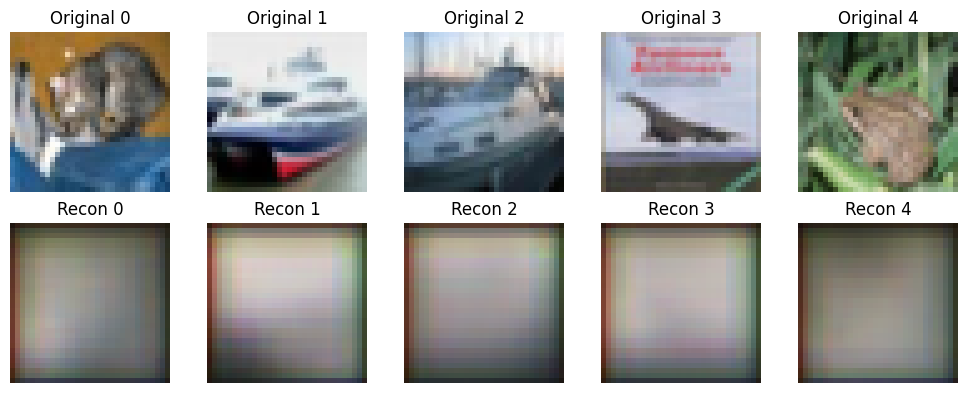

In [12]:
from PIL import Image
import matplotlib.pyplot as plt

# Số lượng cặp ảnh
num_samples = 5

plt.figure(figsize=(10, 4))

for i in range(num_samples):
    path = f"sample_{i}_original.pnm"
    img = Image.open(path)

    plt.subplot(2, num_samples, i + 1)   # hàng 1
    plt.imshow(img)
    plt.title(f"Original {i}")
    plt.axis("off")

for i in range(num_samples):
    path = f"sample_{i}_reconstructed.pnm"
    img = Image.open(path)

    plt.subplot(2, num_samples, num_samples + i + 1)   # hàng 2
    plt.imshow(img)
    plt.title(f"Recon {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()


## 2) GPU Naive:

In [13]:
%%writefile gpu_layers.h
#pragma once
#include <cuda_runtime.h>
#include <stdio.h>

#define CHECK_CUDA(call)                                                \
    do {                                                                \
        cudaError_t err = call;                                         \
        if (err != cudaSuccess) {                                       \
            fprintf(stderr, "CUDA Error %s:%d: %s\n",                   \
                    __FILE__, __LINE__, cudaGetErrorString(err));       \
            exit(EXIT_FAILURE);                                         \
        }                                                               \
    } while (0)

// NCHW layout: [N, C, H, W]
__device__ __host__ inline int idx4(int n, int c, int h, int w,
                                    int C, int H, int W) {
    return ((n * C + c) * H + h) * W + w;
}

// ==== KERNEL DECLARATIONS ====

__global__ void conv2d_forward_naive(
    const float* __restrict__ input,    // [N, C_in, H, W]
    const float* __restrict__ weight,   // [C_out, C_in, K, K]
    const float* __restrict__ bias,     // [C_out]
    float* __restrict__ output,         // [N, C_out, H_out, W_out]
    int N, int C_in, int H, int W,
    int C_out, int K, int pad, int stride);

__global__ void relu_forward(float* x, int size);

__global__ void maxpool2x2_forward(
    const float* __restrict__ input,  // [N, C, H, W]
    float* __restrict__ output,       // [N, C, H/2, W/2]
    int N, int C, int H, int W);

__global__ void upsample2x2_forward(
    const float* __restrict__ input,  // [N, C, H, W]
    float* __restrict__ output,       // [N, C, 2H, 2W]
    int N, int C, int H, int W);

__global__ void mse_loss_forward(
    const float* __restrict__ output,
    const float* __restrict__ target,
    float* __restrict__ loss,   // single float on device
    int size);

__global__ void relu_backward(
    const float* __restrict__ x,       // forward output/input to ReLU
    const float* __restrict__ grad_y,  // dL/dy
    float* __restrict__ grad_x,        // dL/dx
    int size);

__global__ void maxpool2x2_backward(
    const float* __restrict__ input,
    const float* __restrict__ grad_out,
    float* __restrict__ grad_in,
    int N, int C, int H, int W);

__global__ void upsample2x2_backward(
    const float* __restrict__ grad_out,
    float* __restrict__ grad_in,
    int N, int C, int H, int W);

__global__ void mse_loss_backward(
    const float* __restrict__ output,
    const float* __restrict__ target,
    float* __restrict__ grad_out,
    int size);

__global__ void conv2d_backward_input_naive(
    const float* __restrict__ dY,
    const float* __restrict__ weight,
    float* __restrict__ dX,
    int N, int C_in, int H, int W,
    int C_out, int K, int pad, int stride);

__global__ void conv2d_backward_weight_naive(
    const float* __restrict__ input,
    const float* __restrict__ dY,
    float* __restrict__ dW,
    int N, int C_in, int H, int W,
    int C_out, int K, int pad, int stride);

__global__ void conv2d_backward_bias_naive(
    const float* __restrict__ dY,
    float* __restrict__ dB,
    int N, int C_out, int H_out, int W_out);

__global__ void sgd_update(
    float* __restrict__ param,
    const float* __restrict__ grad,
    int size,
    float lr);


Writing gpu_layers.h


In [14]:
%%writefile gpu_layers.cu
#include "gpu_layers.h"

// --------------- Conv2D forward (không đổi) ------------------
__global__ void conv2d_forward_naive(
    const float* __restrict__ input,
    const float* __restrict__ weight,
    const float* __restrict__ bias,
    float* __restrict__ output,
    int N, int C_in, int H, int W,
    int C_out, int K, int pad, int stride)
{
    int H_out = (H + 2 * pad - K) / stride + 1;
    int W_out = (W + 2 * pad - K) / stride + 1;

    int w_out = blockIdx.x * blockDim.x + threadIdx.x;
    int h_out = blockIdx.y * blockDim.y + threadIdx.y;
    int nc    = blockIdx.z;

    if (w_out >= W_out || h_out >= H_out) return;

    int n      = nc / C_out;
    int c_out  = nc % C_out;
    if (n >= N) return;

    float sum = bias ? bias[c_out] : 0.0f;

    for (int c_in = 0; c_in < C_in; ++c_in) {
        for (int kh = 0; kh < K; ++kh) {
            for (int kw = 0; kw < K; ++kw) {
                int h_in = h_out * stride + kh - pad;
                int w_in = w_out * stride + kw - pad;
                if (h_in < 0 || h_in >= H || w_in < 0 || w_in >= W)
                    continue;

                int in_idx = ((n * C_in + c_in) * H + h_in) * W + w_in;
                int w_idx = (((c_out * C_in + c_in) * K) + kh) * K + kw;
                sum += weight[w_idx] * input[in_idx];
            }
        }
    }
    int out_idx = ((n * C_out + c_out) * H_out + h_out) * W_out + w_out;
    output[out_idx] = sum;
}

// --------------- ReLU ------------------
__global__ void relu_forward(float* x, int size)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < size) {
        float v = x[i];
        x[i] = v > 0.0f ? v : 0.0f;
    }
}

// --------------- MaxPool 2x2 ------------------
__global__ void maxpool2x2_forward(
    const float* __restrict__ input,
    float* __restrict__ output,
    int N, int C, int H, int W)
{
    int H_out = H / 2;
    int W_out = W / 2;

    int w_out = blockIdx.x * blockDim.x + threadIdx.x;
    int h_out = blockIdx.y * blockDim.y + threadIdx.y;
    int nc    = blockIdx.z;

    if (w_out >= W_out || h_out >= H_out) return;

    int n = nc / C;
    int c = nc % C;
    if (n >= N) return;

    int h_in0 = h_out * 2;
    int w_in0 = w_out * 2;

    float m = -1e30f;
    for (int dh = 0; dh < 2; ++dh) {
        for (int dw = 0; dw < 2; ++dw) {
            int h_in = h_in0 + dh;
            int w_in = w_in0 + dw;
            int idx = idx4(n, c, h_in, w_in, C, H, W);
            float v = input[idx];
            if (v > m) m = v;
        }
    }

    int out_idx = idx4(n, c, h_out, w_out, C, H_out, W_out);
    output[out_idx] = m;
}

// --------------- UpSample 2x2 ------------------
__global__ void upsample2x2_forward(
    const float* __restrict__ input,
    float* __restrict__ output,
    int N, int C, int H, int W)
{
    int H_out = H * 2;
    int W_out = W * 2;

    int w_out = blockIdx.x * blockDim.x + threadIdx.x;
    int h_out = blockIdx.y * blockDim.y + threadIdx.y;
    int nc    = blockIdx.z;

    if (w_out >= W_out || h_out >= H_out) return;

    int n = nc / C;
    int c = nc % C;
    if (n >= N) return;

    int h_in = h_out / 2;
    int w_in = w_out / 2;

    int idx_in  = idx4(n, c, h_in, w_in, C, H, W);
    int idx_out = idx4(n, c, h_out, w_out, C, H_out, W_out);
    output[idx_out] = input[idx_in];
}

// --------------- MSE loss ------------------
__global__ void mse_loss_forward(
    const float* __restrict__ output,
    const float* __restrict__ target,
    float* __restrict__ loss,
    int size)
{
    extern __shared__ float sdata[];

    int tid = threadIdx.x;
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    float val = 0.0f;
    if (idx < size) {
        float diff = output[idx] - target[idx];
        // Mỗi phần tử tự chia size để tổng lại thành mean
        val = diff * diff;
    }
    sdata[tid] = val;
    __syncthreads();

    // reduce trong block
    for (int s = blockDim.x / 2; s > 0; s >>= 1) {
        if (tid < s) {
            sdata[tid] += sdata[tid + s];
        }
        __syncthreads();
    }

    if (tid == 0) {
        atomicAdd(loss, sdata[0]);
    }
}


// --------------- ReLU backward ------------------
__global__ void relu_backward(
    const float* __restrict__ x,
    const float* __restrict__ grad_y,
    float* __restrict__ grad_x,
    int size)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < size) {
        float v = x[i];
        grad_x[i] = (v > 0.0f) ? grad_y[i] : 0.0f;
    }
}

// --------------- MaxPool 2x2 backward - FIX ------------------
// BUG FIX: Chỉ ghi vào vị trí max, không ghi đè 4 vị trí
__global__ void maxpool2x2_backward(
    const float* __restrict__ input,
    const float* __restrict__ grad_out,
    float* __restrict__ grad_in,
    int N, int C, int H, int W)
{
    int H_out = H / 2;
    int W_out = W / 2;

    int w_out = blockIdx.x * blockDim.x + threadIdx.x;
    int h_out = blockIdx.y * blockDim.y + threadIdx.y;
    int nc    = blockIdx.z;

    if (w_out >= W_out || h_out >= H_out) return;

    int n = nc / C;
    int c = nc % C;
    if (n >= N) return;

    int h_in0 = h_out * 2;
    int w_in0 = w_out * 2;

    int idx00 = idx4(n, c, h_in0 + 0, w_in0 + 0, C, H, W);
    int idx01 = idx4(n, c, h_in0 + 0, w_in0 + 1, C, H, W);
    int idx10 = idx4(n, c, h_in0 + 1, w_in0 + 0, C, H, W);
    int idx11 = idx4(n, c, h_in0 + 1, w_in0 + 1, C, H, W);

    float v00 = input[idx00];
    float v01 = input[idx01];
    float v10 = input[idx10];
    float v11 = input[idx11];

    float g = grad_out[idx4(n, c, h_out, w_out, C, H_out, W_out)];

    // Tìm max
    float m = v00;
    int max_idx = 0;
    if (v01 > m) { m = v01; max_idx = 1; }
    if (v10 > m) { m = v10; max_idx = 2; }
    if (v11 > m) { m = v11; max_idx = 3; }

    // FIX: Chỉ ghi vào vị trí max (grad_in đã được zero trước đó)
    // Mỗi pooling window độc lập, không có conflict
    if (max_idx == 0) grad_in[idx00] = g;
    else if (max_idx == 1) grad_in[idx01] = g;
    else if (max_idx == 2) grad_in[idx10] = g;
    else grad_in[idx11] = g;
}

// --------------- UpSample 2x2 backward ------------------
__global__ void upsample2x2_backward(
    const float* __restrict__ grad_out,
    float* __restrict__ grad_in,
    int N, int C, int H, int W)
{
    int H_out = H * 2;
    int W_out = W * 2;

    int w_in = blockIdx.x * blockDim.x + threadIdx.x;
    int h_in = blockIdx.y * blockDim.y + threadIdx.y;
    int nc   = blockIdx.z;

    if (w_in >= W || h_in >= H) return;

    int n = nc / C;
    int c = nc % C;
    if (n >= N) return;

    int h_out0 = h_in * 2;
    int w_out0 = w_in * 2;

    float sum = 0.0f;
    for (int dh = 0; dh < 2; ++dh) {
        for (int dw = 0; dw < 2; ++dw) {
            int h_out = h_out0 + dh;
            int w_out = w_out0 + dw;
            int idx_o = idx4(n, c, h_out, w_out, C, H_out, W_out);
            sum += grad_out[idx_o];
        }
    }

    int idx_in = idx4(n, c, h_in, w_in, C, H, W);
    grad_in[idx_in] = sum;
}

// --------------- MSE loss backward ------------------
__global__ void mse_loss_backward(
    const float* __restrict__ output,
    const float* __restrict__ target,
    float* __restrict__ grad_out,
    int size)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i >= size) return;
    grad_out[i] = 2.0f * (output[i] - target[i]) / size;
}

// --------------- Conv2D backward: dX ------------------
__global__ void conv2d_backward_input_naive(
    const float* __restrict__ dY,
    const float* __restrict__ weight,
    float* __restrict__ dX,
    int N, int C_in, int H, int W,
    int C_out, int K, int pad, int stride)
{
    int H_out = (H + 2 * pad - K) / stride + 1;
    int W_out = (W + 2 * pad - K) / stride + 1;

    int w = blockIdx.x * blockDim.x + threadIdx.x;
    int h = blockIdx.y * blockDim.y + threadIdx.y;
    int nc = blockIdx.z;

    if (w >= W || h >= H) return;

    int n = nc / C_in;
    int c_in = nc % C_in;
    if (n >= N) return;

    float sum = 0.0f;
    for (int c_out = 0; c_out < C_out; ++c_out) {
        for (int kh = 0; kh < K; ++kh) {
            for (int kw = 0; kw < K; ++kw) {
                int h_out = h + pad - kh;
                int w_out = w + pad - kw;

                if (h_out % stride != 0 || w_out % stride != 0) continue;

                h_out /= stride;
                w_out /= stride;

                if (h_out < 0 || h_out >= H_out ||
                    w_out < 0 || w_out >= W_out)
                    continue;

                int dy_idx = idx4(n, c_out, h_out, w_out,
                                  C_out, H_out, W_out);

                int kh_flip = K - 1 - kh;
                int kw_flip = K - 1 - kw;
                int w_idx = (((c_out * C_in + c_in) * K) + kh_flip) * K + kw_flip;
                sum += dY[dy_idx] * weight[w_idx];
            }
        }
    }

    int dx_idx = idx4(n, c_in, h, w, C_in, H, W);
    dX[dx_idx] = sum;
}

// --------------- Conv2D backward: dW ------------------
// Mỗi thread tính toàn bộ gradient cho 1 weight element
// Không có conflict vì mỗi thread ghi vào vị trí riêng biệt
__global__ void conv2d_backward_weight_naive(
    const float* __restrict__ input,
    const float* __restrict__ dY,
    float* __restrict__ dW,
    int N, int C_in, int H, int W,
    int C_out, int K, int pad, int stride)
{
    int H_out = (H + 2 * pad - K) / stride + 1;
    int W_out = (W + 2 * pad - K) / stride + 1;

    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int total = C_out * C_in * K * K;
    if (idx >= total) return;

    int kw = idx % K;
    int tmp = idx / K;
    int kh = tmp % K;
    tmp /= K;
    int c_in = tmp % C_in;
    int c_out = tmp / C_in;

    float sum = 0.0f;
    for (int n = 0; n < N; ++n) {
        for (int h_out = 0; h_out < H_out; ++h_out) {
            for (int w_out = 0; w_out < W_out; ++w_out) {
                int h_in = h_out * stride + kh - pad;
                int w_in = w_out * stride + kw - pad;
                if (h_in < 0 || h_in >= H || w_in < 0 || w_in >= W)
                    continue;

                int in_idx = idx4(n, c_in, h_in, w_in, C_in, H, W);
                int dy_idx = idx4(n, c_out, h_out, w_out,
                                  C_out, H_out, W_out);
                sum += dY[dy_idx] * input[in_idx];
            }
        }
    }

    // Mỗi thread ghi vào vị trí riêng, không conflict
    dW[idx] += sum;
}

// --------------- Conv2D backward: dB ------------------
// Mỗi thread tính gradient cho 1 bias element
__global__ void conv2d_backward_bias_naive(
    const float* __restrict__ dY,
    float* __restrict__ dB,
    int N, int C_out, int H_out, int W_out)
{
    int c_out = blockIdx.x * blockDim.x + threadIdx.x;
    if (c_out >= C_out) return;

    float sum = 0.0f;
    for (int n = 0; n < N; ++n) {
        for (int h = 0; h < H_out; ++h) {
            for (int w = 0; w < W_out; ++w) {
                int idx = idx4(n, c_out, h, w, C_out, H_out, W_out);
                sum += dY[idx];
            }
        }
    }

    // Mỗi thread ghi vào vị trí riêng, không conflict
    dB[c_out] += sum;
}

// --------------- SGD update ------------------
__global__ void sgd_update(
    float* __restrict__ param,
    const float* __restrict__ grad,
    int size,
    float lr)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < size) {
        param[i] -= lr * grad[i];
    }
}

Writing gpu_layers.cu


In [15]:
%%writefile gpu_autoencoder.h
// header for GPUAutoencoder (the struct + declarations)
#pragma once
#include "gpu_layers.h"

// latent 128 x 8 x 8
static const int AE_LATENT_C   = 128;
static const int AE_LATENT_H   = 8;
static const int AE_LATENT_W   = 8;
static const int AE_LATENT_DIM = AE_LATENT_C * AE_LATENT_H * AE_LATENT_W;

// This autoencoder matches the project architecture exactly.
// Layout: NCHW [batch, channels, height, width]
struct GPUAutoencoder {
    int N;   // batch size
    int H;   // 32
    int W;   // 32;

    // --- Conv layer parameters ---
    // conv1: 3 -> 256 (3x3)
    float *d_w1, *d_b1;
    // conv2: 256 -> 128
    float *d_w2, *d_b2;
    // conv3: 128 -> 128
    float *d_w3, *d_b3;
    // conv4: 128 -> 256
    float *d_w4, *d_b4;
    // conv5: 256 -> 3
    float *d_w5, *d_b5;

    // --- Activations ---
    // Input batch
    float *d_x0;   // [N, 3, 32, 32]

    // Encoder
    float *d_h1;   // conv1 out: [N, 256, 32, 32]
    float *d_p1;   // pool1   : [N, 256, 16, 16]
    float *d_h2;   // conv2   : [N, 128, 16, 16]
    float *d_p2;   // pool2   : [N, 128,  8,  8]   (latent)

    // Decoder
    float *d_h3;   // conv3   : [N, 128,  8,  8]
    float *d_u1;   // up1     : [N, 128, 16, 16]
    float *d_h4;   // conv4   : [N, 256, 16, 16]
    float *d_u2;   // up2     : [N, 256, 32, 32]
    float *d_out;  // conv5   : [N,   3, 32, 32]

    // Loss buffer
    float *d_loss; // single float on device

    // ---- gradients for activations ----
    float *d_gx0;
    float *d_gh1;
    float *d_gp1;
    float *d_gh2;
    float *d_gp2;
    float *d_gh3;
    float *d_gu1;
    float *d_gh4;
    float *d_gu2;
    float *d_gout;

    // ---- gradients for weights ----
    float *d_gw1, *d_gb1;
    float *d_gw2, *d_gb2;
    float *d_gw3, *d_gb3;
    float *d_gw4, *d_gb4;
    float *d_gw5, *d_gb5;
};

// API
void gpu_autoencoder_init(GPUAutoencoder *ae, int batch_size);
void gpu_autoencoder_free(GPUAutoencoder *ae);

void gpu_autoencoder_copy_weights_to_host(
    GPUAutoencoder *ae,
    float *h_w1, float *h_b1,
    float *h_w2, float *h_b2,
    float *h_w3, float *h_b3,
    float *h_w4, float *h_b4,
    float *h_w5, float *h_b5);

void gpu_autoencoder_copy_weights_to_device(
    GPUAutoencoder *ae,
    const float *h_w1, const float *h_b1,
    const float *h_w2, const float *h_b2,
    const float *h_w3, const float *h_b3,
    const float *h_w4, const float *h_b4,
    const float *h_w5, const float *h_b5);


// Forward on GPU:
//   h_input  : host pointer [N * 3 * 32 * 32]
//   h_output : host pointer [N * 3 * 32 * 32]
//   returns loss value (MSE(x_hat, x)) if compute_loss=true;
//   otherwise returns 0.0f.
float gpu_autoencoder_forward(
    GPUAutoencoder *ae,
    const float *h_input,
    float *h_output,
    bool compute_loss = true);

void gpu_autoencoder_backward(GPUAutoencoder *ae, float lr);

void gpu_autoencoder_save_weights(GPUAutoencoder *ae, const char *filename);

void gpu_autoencoder_load_weights(GPUAutoencoder *ae, const char *filename);

// encode only: lấy latent [N_batch, 128, 8, 8] -> h_latent [N_batch, AE_LATENT_DIM]
void gpu_autoencoder_encode_batch(
    GPUAutoencoder *ae,
    const float *h_input,
    float *h_latent,
    int N_batch);


Writing gpu_autoencoder.h


In [16]:
%%writefile gpu_autoencoder.cu
// your GPUAutoencoder implementation
#include <cstdlib>
#include <cstdio>
#include <cmath>
#include <cuda_runtime.h>
#include "gpu_layers.h"
#include "gpu_autoencoder.h"

static inline float rand_uniform(float min_val, float max_val) {
    float r = (float)rand() / (float)RAND_MAX;
    return min_val + r * (max_val - min_val);
}


void gpu_autoencoder_init(GPUAutoencoder *ae, int batch_size) {
    ae->N = batch_size;
    ae->H = 32;
    ae->W = 32;

    const int N = ae->N;
    const int H = ae->H;
    const int W = ae->W;

    // ---------- allocate weights ----------
    const int K = 3;

    int C_in1 = 3,   C_out1 = 256;
    int C_in2 = 256, C_out2 = 128;
    int C_in3 = 128, C_out3 = 128;
    int C_in4 = 128, C_out4 = 256;
    int C_in5 = 256, C_out5 = 3;

    size_t w1_bytes = C_out1 * C_in1 * K * K * sizeof(float);
    size_t b1_bytes = C_out1 * sizeof(float);
    size_t w2_bytes = C_out2 * C_in2 * K * K * sizeof(float);
    size_t b2_bytes = C_out2 * sizeof(float);
    size_t w3_bytes = C_out3 * C_in3 * K * K * sizeof(float);
    size_t b3_bytes = C_out3 * sizeof(float);
    size_t w4_bytes = C_out4 * C_in4 * K * K * sizeof(float);
    size_t b4_bytes = C_out4 * sizeof(float);
    size_t w5_bytes = C_out5 * C_in5 * K * K * sizeof(float);
    size_t b5_bytes = C_out5 * sizeof(float);

    CHECK_CUDA(cudaMalloc(&ae->d_w1, w1_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_b1, b1_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_w2, w2_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_b2, b2_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_w3, w3_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_b3, b3_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_w4, w4_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_b4, b4_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_w5, w5_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_b5, b5_bytes));

    // init weights on host
// find max weight bytes
size_t max_w_bytes = w1_bytes;
if (w2_bytes > max_w_bytes) max_w_bytes = w2_bytes;
if (w3_bytes > max_w_bytes) max_w_bytes = w3_bytes;
if (w4_bytes > max_w_bytes) max_w_bytes = w4_bytes;
if (w5_bytes > max_w_bytes) max_w_bytes = w5_bytes;

// find max bias bytes
size_t max_b_bytes = b1_bytes;
if (b2_bytes > max_b_bytes) max_b_bytes = b2_bytes;
if (b3_bytes > max_b_bytes) max_b_bytes = b3_bytes;
if (b4_bytes > max_b_bytes) max_b_bytes = b4_bytes;
if (b5_bytes > max_b_bytes) max_b_bytes = b5_bytes;

float *h_w = (float*)malloc(max_w_bytes);
float *h_b = (float*)malloc(max_b_bytes);


    auto init_wb = [&](float *d_w, size_t w_bytes, float *d_b, size_t b_bytes) {
        size_t w_cnt = w_bytes / sizeof(float);
        size_t b_cnt = b_bytes / sizeof(float);
        for (size_t i = 0; i < w_cnt; ++i) h_w[i] = rand_uniform(-0.05f, 0.05f);
        for (size_t i = 0; i < b_cnt; ++i) h_b[i] = rand_uniform(-0.05f, 0.05f);
        CHECK_CUDA(cudaMemcpy(d_w, h_w, w_bytes, cudaMemcpyHostToDevice));
        CHECK_CUDA(cudaMemcpy(d_b, h_b, b_bytes, cudaMemcpyHostToDevice));
    };

    init_wb(ae->d_w1, w1_bytes, ae->d_b1, b1_bytes);
    init_wb(ae->d_w2, w2_bytes, ae->d_b2, b2_bytes);
    init_wb(ae->d_w3, w3_bytes, ae->d_b3, b3_bytes);
    init_wb(ae->d_w4, w4_bytes, ae->d_b4, b4_bytes);
    init_wb(ae->d_w5, w5_bytes, ae->d_b5, b5_bytes);

    free(h_w);
    free(h_b);

    // ---------- allocate activations ----------
    size_t bytes_x0  = N * 3   * 32 * 32 * sizeof(float);
    size_t bytes_h1  = N * 256 * 32 * 32 * sizeof(float);
    size_t bytes_p1  = N * 256 * 16 * 16 * sizeof(float);
    size_t bytes_h2  = N * 128 * 16 * 16 * sizeof(float);
    size_t bytes_p2  = N * 128 *  8 *  8 * sizeof(float);
    size_t bytes_h3  = N * 128 *  8 *  8 * sizeof(float);
    size_t bytes_u1  = N * 128 * 16 * 16 * sizeof(float);
    size_t bytes_h4  = N * 256 * 16 * 16 * sizeof(float);
    size_t bytes_u2  = N * 256 * 32 * 32 * sizeof(float);
    size_t bytes_out = N * 3   * 32 * 32 * sizeof(float);

    CHECK_CUDA(cudaMalloc(&ae->d_x0,  bytes_x0));
    CHECK_CUDA(cudaMalloc(&ae->d_h1,  bytes_h1));
    CHECK_CUDA(cudaMalloc(&ae->d_p1,  bytes_p1));
    CHECK_CUDA(cudaMalloc(&ae->d_h2,  bytes_h2));
    CHECK_CUDA(cudaMalloc(&ae->d_p2,  bytes_p2));
    CHECK_CUDA(cudaMalloc(&ae->d_h3,  bytes_h3));
    CHECK_CUDA(cudaMalloc(&ae->d_u1,  bytes_u1));
    CHECK_CUDA(cudaMalloc(&ae->d_h4,  bytes_h4));
    CHECK_CUDA(cudaMalloc(&ae->d_u2,  bytes_u2));
    CHECK_CUDA(cudaMalloc(&ae->d_out, bytes_out));

    // loss buffer
    CHECK_CUDA(cudaMalloc(&ae->d_loss, sizeof(float)));

    // ---------- allocate activation gradients ----------
    CHECK_CUDA(cudaMalloc(&ae->d_gx0,  bytes_x0));
    CHECK_CUDA(cudaMalloc(&ae->d_gh1,  bytes_h1));
    CHECK_CUDA(cudaMalloc(&ae->d_gp1,  bytes_p1));
    CHECK_CUDA(cudaMalloc(&ae->d_gh2,  bytes_h2));
    CHECK_CUDA(cudaMalloc(&ae->d_gp2,  bytes_p2));
    CHECK_CUDA(cudaMalloc(&ae->d_gh3,  bytes_h3));
    CHECK_CUDA(cudaMalloc(&ae->d_gu1,  bytes_u1));
    CHECK_CUDA(cudaMalloc(&ae->d_gh4,  bytes_h4));
    CHECK_CUDA(cudaMalloc(&ae->d_gu2,  bytes_u2));
    CHECK_CUDA(cudaMalloc(&ae->d_gout, bytes_out));

    // ---------- allocate weight gradients ----------
    CHECK_CUDA(cudaMalloc(&ae->d_gw1, w1_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_gb1, b1_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_gw2, w2_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_gb2, b2_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_gw3, w3_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_gb3, b3_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_gw4, w4_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_gb4, b4_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_gw5, w5_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_gb5, b5_bytes));
}

void gpu_autoencoder_free(GPUAutoencoder *ae) {
    // weights
    cudaFree(ae->d_w1); cudaFree(ae->d_b1);
    cudaFree(ae->d_w2); cudaFree(ae->d_b2);
    cudaFree(ae->d_w3); cudaFree(ae->d_b3);
    cudaFree(ae->d_w4); cudaFree(ae->d_b4);
    cudaFree(ae->d_w5); cudaFree(ae->d_b5);

    // activations
    cudaFree(ae->d_x0);
    cudaFree(ae->d_h1);
    cudaFree(ae->d_p1);
    cudaFree(ae->d_h2);
    cudaFree(ae->d_p2);
    cudaFree(ae->d_h3);
    cudaFree(ae->d_u1);
    cudaFree(ae->d_h4);
    cudaFree(ae->d_u2);
    cudaFree(ae->d_out);

    cudaFree(ae->d_loss);

    // activation gradients
    cudaFree(ae->d_gx0);
    cudaFree(ae->d_gh1);
    cudaFree(ae->d_gp1);
    cudaFree(ae->d_gh2);
    cudaFree(ae->d_gp2);
    cudaFree(ae->d_gh3);
    cudaFree(ae->d_gu1);
    cudaFree(ae->d_gh4);
    cudaFree(ae->d_gu2);
    cudaFree(ae->d_gout);

    // weight gradients
    cudaFree(ae->d_gw1); cudaFree(ae->d_gb1);
    cudaFree(ae->d_gw2); cudaFree(ae->d_gb2);
    cudaFree(ae->d_gw3); cudaFree(ae->d_gb3);
    cudaFree(ae->d_gw4); cudaFree(ae->d_gb4);
    cudaFree(ae->d_gw5); cudaFree(ae->d_gb5);
}

void gpu_autoencoder_copy_weights_to_host(
    GPUAutoencoder *ae,
    float *h_w1, float *h_b1,
    float *h_w2, float *h_b2,
    float *h_w3, float *h_b3,
    float *h_w4, float *h_b4,
    float *h_w5, float *h_b5)
{
    const int K = 3;
    int C_in1 = 3,   C_out1 = 256;
    int C_in2 = 256, C_out2 = 128;
    int C_in3 = 128, C_out3 = 128;
    int C_in4 = 128, C_out4 = 256;
    int C_in5 = 256, C_out5 = 3;

    size_t w1_bytes = C_out1 * C_in1 * K * K * sizeof(float);
    size_t b1_bytes = C_out1 * sizeof(float);
    size_t w2_bytes = C_out2 * C_in2 * K * K * sizeof(float);
    size_t b2_bytes = C_out2 * sizeof(float);
    size_t w3_bytes = C_out3 * C_in3 * K * K * sizeof(float);
    size_t b3_bytes = C_out3 * sizeof(float);
    size_t w4_bytes = C_out4 * C_in4 * K * K * sizeof(float);
    size_t b4_bytes = C_out4 * sizeof(float);
    size_t w5_bytes = C_out5 * C_in5 * K * K * sizeof(float);
    size_t b5_bytes = C_out5 * sizeof(float);

    CHECK_CUDA(cudaMemcpy(h_w1, ae->d_w1, w1_bytes, cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaMemcpy(h_b1, ae->d_b1, b1_bytes, cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaMemcpy(h_w2, ae->d_w2, w2_bytes, cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaMemcpy(h_b2, ae->d_b2, b2_bytes, cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaMemcpy(h_w3, ae->d_w3, w3_bytes, cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaMemcpy(h_b3, ae->d_b3, b3_bytes, cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaMemcpy(h_w4, ae->d_w4, w4_bytes, cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaMemcpy(h_b4, ae->d_b4, b4_bytes, cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaMemcpy(h_w5, ae->d_w5, w5_bytes, cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaMemcpy(h_b5, ae->d_b5, b5_bytes, cudaMemcpyDeviceToHost));
}

void gpu_autoencoder_copy_weights_to_device(
    GPUAutoencoder *ae,
    const float *h_w1, const float *h_b1,
    const float *h_w2, const float *h_b2,
    const float *h_w3, const float *h_b3,
    const float *h_w4, const float *h_b4,
    const float *h_w5, const float *h_b5)
{
    const int K = 3;
    int C_in1 = 3,   C_out1 = 256;
    int C_in2 = 256, C_out2 = 128;
    int C_in3 = 128, C_out3 = 128;
    int C_in4 = 128, C_out4 = 256;
    int C_in5 = 256, C_out5 = 3;

    size_t w1_bytes = C_out1 * C_in1 * K * K * sizeof(float);
    size_t b1_bytes = C_out1 * sizeof(float);
    size_t w2_bytes = C_out2 * C_in2 * K * K * sizeof(float);
    size_t b2_bytes = C_out2 * sizeof(float);
    size_t w3_bytes = C_out3 * C_in3 * K * K * sizeof(float);
    size_t b3_bytes = C_out3 * sizeof(float);
    size_t w4_bytes = C_out4 * C_in4 * K * K * sizeof(float);
    size_t b4_bytes = C_out4 * sizeof(float);
    size_t w5_bytes = C_out5 * C_in5 * K * K * sizeof(float);
    size_t b5_bytes = C_out5 * sizeof(float);

    CHECK_CUDA(cudaMemcpy(ae->d_w1, h_w1, w1_bytes, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(ae->d_b1, h_b1, b1_bytes, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(ae->d_w2, h_w2, w2_bytes, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(ae->d_b2, h_b2, b2_bytes, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(ae->d_w3, h_w3, w3_bytes, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(ae->d_b3, h_b3, b3_bytes, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(ae->d_w4, h_w4, w4_bytes, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(ae->d_b4, h_b4, b4_bytes, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(ae->d_w5, h_w5, w5_bytes, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(ae->d_b5, h_b5, b5_bytes, cudaMemcpyHostToDevice));
}


// Forward pass for ONE batch (no backward yet)
float gpu_autoencoder_forward(
    GPUAutoencoder *ae,
    const float *h_input,
    float *h_output,
    bool compute_loss)
{
    const int N = ae->N;
    const int H = ae->H;
    const int W = ae->W;
    const int K = 3;
    const int pad = 1;
    const int stride = 1;

    // ------------- copy input to device -------------
    size_t in_bytes = N * 3 * H * W * sizeof(float);
    CHECK_CUDA(cudaMemcpy(ae->d_x0, h_input, in_bytes, cudaMemcpyHostToDevice));

    dim3 block2d(16, 16);

    // ========= ENCODER =========
    // conv1: 3 -> 256, same 32x32
    {
        int C_in = 3, C_out = 256;
        int H_out = 32, W_out = 32;
        dim3 gridConv(
            (W_out + block2d.x - 1) / block2d.x,
            (H_out + block2d.y - 1) / block2d.y,
            N * C_out);

        conv2d_forward_naive<<<gridConv, block2d>>>(
            ae->d_x0, ae->d_w1, ae->d_b1, ae->d_h1,
            N, C_in, H, W, C_out, K, pad, stride);
        CHECK_CUDA(cudaDeviceSynchronize());

        // ReLU
        int size = N * C_out * H_out * W_out;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_forward<<<b, t>>>(ae->d_h1, size);
        CHECK_CUDA(cudaDeviceSynchronize());

        // MaxPool 2x2 -> 16x16
        int Hp = 16, Wp = 16;
        dim3 gridPool(
            (Wp + block2d.x - 1) / block2d.x,
            (Hp + block2d.y - 1) / block2d.y,
            N * C_out);

        maxpool2x2_forward<<<gridPool, block2d>>>(
            ae->d_h1, ae->d_p1,
            N, C_out, H_out, W_out);
        CHECK_CUDA(cudaDeviceSynchronize());
    }

    // conv2: 256 -> 128, 16x16, then pool -> 8x8
    {
        int C_in = 256, C_out = 128;
        int H_in = 16, W_in = 16;
        int H_out = 16, W_out = 16;
        dim3 gridConv(
            (W_out + block2d.x - 1) / block2d.x,
            (H_out + block2d.y - 1) / block2d.y,
            N * C_out);

        conv2d_forward_naive<<<gridConv, block2d>>>(
            ae->d_p1, ae->d_w2, ae->d_b2, ae->d_h2,
            N, C_in, H_in, W_in, C_out, K, pad, stride);
        CHECK_CUDA(cudaDeviceSynchronize());

        int size = N * C_out * H_out * W_out;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_forward<<<b, t>>>(ae->d_h2, size);
        CHECK_CUDA(cudaDeviceSynchronize());

        // pool -> 8x8
        int Hp = 8, Wp = 8;
        dim3 gridPool(
            (Wp + block2d.x - 1) / block2d.x,
            (Hp + block2d.y - 1) / block2d.y,
            N * C_out);

        maxpool2x2_forward<<<gridPool, block2d>>>(
            ae->d_h2, ae->d_p2,
            N, C_out, H_out, W_out);
        CHECK_CUDA(cudaDeviceSynchronize());
    }

    // LATENT is ae->d_p2: [N, 128, 8, 8]

    // ========= DECODER =========
    // conv3: 128 -> 128, 8x8
    {
        int C_in = 128, C_out = 128;
        int H_in = 8, W_in = 8;
        int H_out = 8, W_out = 8;

        dim3 gridConv(
            (W_out + block2d.x - 1) / block2d.x,
            (H_out + block2d.y - 1) / block2d.y,
            N * C_out);

        conv2d_forward_naive<<<gridConv, block2d>>>(
            ae->d_p2, ae->d_w3, ae->d_b3, ae->d_h3,
            N, C_in, H_in, W_in, C_out, K, pad, stride);
        CHECK_CUDA(cudaDeviceSynchronize());

        int size = N * C_out * H_out * W_out;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_forward<<<b, t>>>(ae->d_h3, size);
        CHECK_CUDA(cudaDeviceSynchronize());

        // upsample 8x8 -> 16x16
        int Hu = 16, Wu = 16;
        dim3 gridUp(
            (Wu + block2d.x - 1) / block2d.x,
            (Hu + block2d.y - 1) / block2d.y,
            N * C_out);

        upsample2x2_forward<<<gridUp, block2d>>>(
            ae->d_h3, ae->d_u1,
            N, C_out, H_in, W_in);
        CHECK_CUDA(cudaDeviceSynchronize());
    }

    // conv4: 128 -> 256, 16x16, then upsample 16->32
    {
        int C_in = 128, C_out = 256;
        int H_in = 16, W_in = 16;
        int H_out = 16, W_out = 16;

        dim3 gridConv(
            (W_out + block2d.x - 1) / block2d.x,
            (H_out + block2d.y - 1) / block2d.y,
            N * C_out);

        conv2d_forward_naive<<<gridConv, block2d>>>(
            ae->d_u1, ae->d_w4, ae->d_b4, ae->d_h4,
            N, C_in, H_in, W_in, C_out, K, pad, stride);
        CHECK_CUDA(cudaDeviceSynchronize());

        int size = N * C_out * H_out * W_out;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_forward<<<b, t>>>(ae->d_h4, size);
        CHECK_CUDA(cudaDeviceSynchronize());

        // upsample 16x16 -> 32x32
        int Hu = 32, Wu = 32;
        dim3 gridUp(
            (Wu + block2d.x - 1) / block2d.x,
            (Hu + block2d.y - 1) / block2d.y,
            N * C_out);

        upsample2x2_forward<<<gridUp, block2d>>>(
            ae->d_h4, ae->d_u2,
            N, C_out, H_in, W_in);
        CHECK_CUDA(cudaDeviceSynchronize());
    }

    // conv5: 256 -> 3, 32x32 (no activation, usually MSE on raw output)
    {
        int C_in = 256, C_out = 3;
        int H_in = 32, W_in = 32;
        int H_out = 32, W_out = 32;

        dim3 gridConv(
            (W_out + block2d.x - 1) / block2d.x,
            (H_out + block2d.y - 1) / block2d.y,
            N * C_out);

        conv2d_forward_naive<<<gridConv, block2d>>>(
            ae->d_u2, ae->d_w5, ae->d_b5, ae->d_out,
            N, C_in, H_in, W_in, C_out, K, pad, stride);
        CHECK_CUDA(cudaDeviceSynchronize());
    }

    // ------------- (optional) compute MSE loss -------------
    float loss_value = 0.0f;
        if (compute_loss) {
        int size = N * 3 * 32 * 32;
        CHECK_CUDA(cudaMemset(ae->d_loss, 0, sizeof(float)));

        int t = 256;
        int b = (size + t - 1) / t;
        size_t shmem_bytes = t * sizeof(float);

        // kernel giờ trả về SUM(diff^2) vào d_loss
        mse_loss_forward<<<b, t, shmem_bytes>>>(
            ae->d_out, ae->d_x0, ae->d_loss, size);
        CHECK_CUDA(cudaDeviceSynchronize());

        float loss_sum = 0.0f;
        CHECK_CUDA(cudaMemcpy(&loss_sum, ae->d_loss,
                              sizeof(float),
                              cudaMemcpyDeviceToHost));

        loss_value = loss_sum / size;  // MSE = sum / size
    }


    // ------------- copy output back to host -------------
    size_t out_bytes = N * 3 * 32 * 32 * sizeof(float);
    CHECK_CUDA(cudaMemcpy(h_output, ae->d_out,
                          out_bytes,
                          cudaMemcpyDeviceToHost));

    return loss_value;
}

void gpu_autoencoder_backward(GPUAutoencoder *ae, float lr)
{
    const int N = ae->N;
    const int H0 = ae->H; // 32
    const int W0 = ae->W; // 32
    const int K = 3;
    const int pad = 1;
    const int stride = 1;

    // FIX: Zero all gradient buffers
    CHECK_CUDA(cudaMemset(ae->d_gw1, 0, 256 * 3 * K * K * sizeof(float)));
    CHECK_CUDA(cudaMemset(ae->d_gb1, 0, 256 * sizeof(float)));
    CHECK_CUDA(cudaMemset(ae->d_gw2, 0, 128 * 256 * K * K * sizeof(float)));
    CHECK_CUDA(cudaMemset(ae->d_gb2, 0, 128 * sizeof(float)));
    CHECK_CUDA(cudaMemset(ae->d_gw3, 0, 128 * 128 * K * K * sizeof(float)));
    CHECK_CUDA(cudaMemset(ae->d_gb3, 0, 128 * sizeof(float)));
    CHECK_CUDA(cudaMemset(ae->d_gw4, 0, 256 * 128 * K * K * sizeof(float)));
    CHECK_CUDA(cudaMemset(ae->d_gb4, 0, 256 * sizeof(float)));
    CHECK_CUDA(cudaMemset(ae->d_gw5, 0, 3 * 256 * K * K * sizeof(float)));
    CHECK_CUDA(cudaMemset(ae->d_gb5, 0, 3 * sizeof(float)));

    dim3 block2d(16, 16);

    // ===== 1. dL/dout (MSE) =====
    int size_out = N * 3 * 32 * 32;
    {
        int t = 256;
        int b = (size_out + t - 1) / t;
        mse_loss_backward<<<b, t>>>(
            ae->d_out, ae->d_x0, ae->d_gout, size_out);
        CHECK_CUDA(cudaDeviceSynchronize());
    }

    // ===== 2. Backward conv5: 256->3, 32x32 =====
    {
        int C_in = 256, C_out = 3;
        int H = 32, W = 32;

        dim3 gridIn(
            (W + block2d.x - 1) / block2d.x,
            (H + block2d.y - 1) / block2d.y,
            N * C_in);

        conv2d_backward_input_naive<<<gridIn, block2d>>>(
            ae->d_gout, ae->d_w5, ae->d_gu2,
            N, C_in, H, W, C_out, K, pad, stride);
        CHECK_CUDA(cudaDeviceSynchronize());

        int num_w = C_out * C_in * K * K;
        int t = 256;
        int b = (num_w + t - 1) / t;
        conv2d_backward_weight_naive<<<b, t>>>(
            ae->d_u2, ae->d_gout, ae->d_gw5,
            N, C_in, H, W, C_out, K, pad, stride);
        CHECK_CUDA(cudaDeviceSynchronize());

        int tb = 256;
        int bb = (C_out + tb - 1) / tb;
        conv2d_backward_bias_naive<<<bb, tb>>>(
            ae->d_gout, ae->d_gb5,
            N, C_out, H, W);
        CHECK_CUDA(cudaDeviceSynchronize());

        sgd_update<<<b, t>>>(ae->d_w5, ae->d_gw5, num_w, lr);
        CHECK_CUDA(cudaDeviceSynchronize());

        int bbp = (C_out + t - 1) / t;
        sgd_update<<<bbp, t>>>(ae->d_b5, ae->d_gb5, C_out, lr);
        CHECK_CUDA(cudaDeviceSynchronize());
    }

    // ===== 3. UpSample2x2 backward =====
    {
        int C = 256;
        int H = 16, W = 16;

        dim3 grid(
            (W + block2d.x - 1) / block2d.x,
            (H + block2d.y - 1) / block2d.y,
            N * C);

        upsample2x2_backward<<<grid, block2d>>>(
            ae->d_gu2, ae->d_gh4,
            N, C, H, W);
        CHECK_CUDA(cudaDeviceSynchronize());
    }

    // ===== 4. ReLU backward h4 =====
    {
        int size = N * 256 * 16 * 16;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_backward<<<b, t>>>(
            ae->d_h4, ae->d_gh4, ae->d_gh4, size);
        CHECK_CUDA(cudaDeviceSynchronize());
    }

    // ===== 5. conv4 backward =====
    {
        int C_in = 128, C_out = 256;
        int H = 16, W = 16;

        dim3 gridIn(
            (W + block2d.x - 1) / block2d.x,
            (H + block2d.y - 1) / block2d.y,
            N * C_in);

        conv2d_backward_input_naive<<<gridIn, block2d>>>(
            ae->d_gh4, ae->d_w4, ae->d_gu1,
            N, C_in, H, W, C_out, K, pad, stride);
        CHECK_CUDA(cudaDeviceSynchronize());

        int num_w = C_out * C_in * K * K;
        int t = 256;
        int b = (num_w + t - 1) / t;
        conv2d_backward_weight_naive<<<b, t>>>(
            ae->d_u1, ae->d_gh4, ae->d_gw4,
            N, C_in, H, W, C_out, K, pad, stride);
        CHECK_CUDA(cudaDeviceSynchronize());

        int tb = 256;
        int bb = (C_out + tb - 1) / tb;
        conv2d_backward_bias_naive<<<bb, tb>>>(
            ae->d_gh4, ae->d_gb4,
            N, C_out, H, W);
        CHECK_CUDA(cudaDeviceSynchronize());

        sgd_update<<<b, t>>>(ae->d_w4, ae->d_gw4, num_w, lr);
        CHECK_CUDA(cudaDeviceSynchronize());

        int bbp = (C_out + t - 1) / t;
        sgd_update<<<bbp, t>>>(ae->d_b4, ae->d_gb4, C_out, lr);
        CHECK_CUDA(cudaDeviceSynchronize());
    }

    // ===== 6. UpSample2x2 backward =====
    {
        int C = 128;
        int H = 8, W = 8;

        dim3 grid(
            (W + block2d.x - 1) / block2d.x,
            (H + block2d.y - 1) / block2d.y,
            N * C);

        upsample2x2_backward<<<grid, block2d>>>(
            ae->d_gu1, ae->d_gh3,
            N, C, H, W);
        CHECK_CUDA(cudaDeviceSynchronize());
    }

    // ===== 7. ReLU backward h3 =====
    {
        int size = N * 128 * 8 * 8;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_backward<<<b, t>>>(
            ae->d_h3, ae->d_gh3, ae->d_gh3, size);
        CHECK_CUDA(cudaDeviceSynchronize());
    }

    // ===== 8. conv3 backward =====
    {
        int C_in = 128, C_out = 128;
        int H = 8, W = 8;

        dim3 gridIn(
            (W + block2d.x - 1) / block2d.x,
            (H + block2d.y - 1) / block2d.y,
            N * C_in);

        conv2d_backward_input_naive<<<gridIn, block2d>>>(
            ae->d_gh3, ae->d_w3, ae->d_gp2,
            N, C_in, H, W, C_out, K, pad, stride);
        CHECK_CUDA(cudaDeviceSynchronize());

        int num_w = C_out * C_in * K * K;
        int t = 256;
        int b = (num_w + t - 1) / t;
        conv2d_backward_weight_naive<<<b, t>>>(
            ae->d_p2, ae->d_gh3, ae->d_gw3,
            N, C_in, H, W, C_out, K, pad, stride);
        CHECK_CUDA(cudaDeviceSynchronize());

        int tb = 256;
        int bb = (C_out + tb - 1) / tb;
        conv2d_backward_bias_naive<<<bb, tb>>>(
            ae->d_gh3, ae->d_gb3,
            N, C_out, H, W);
        CHECK_CUDA(cudaDeviceSynchronize());

        sgd_update<<<b, t>>>(ae->d_w3, ae->d_gw3, num_w, lr);
        CHECK_CUDA(cudaDeviceSynchronize());

        int bbp = (C_out + t - 1) / t;
        sgd_update<<<bbp, t>>>(ae->d_b3, ae->d_gb3, C_out, lr);
        CHECK_CUDA(cudaDeviceSynchronize());
    }

    // ===== 9. MaxPool2x2 backward: P2 <- H2 =====
    {
        int C = 128;
        int H = 16, W = 16;

        // FIX: Zero gradient buffer trước khi maxpool backward
        CHECK_CUDA(cudaMemset(ae->d_gh2, 0, N * C * H * W * sizeof(float)));

        dim3 grid(
            (W/2 + block2d.x - 1) / block2d.x,
            (H/2 + block2d.y - 1) / block2d.y,
            N * C);

        maxpool2x2_backward<<<grid, block2d>>>(
            ae->d_h2, ae->d_gp2, ae->d_gh2,
            N, C, H, W);
        CHECK_CUDA(cudaDeviceSynchronize());
    }

    // ===== 10. ReLU backward h2 =====
    {
        int size = N * 128 * 16 * 16;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_backward<<<b, t>>>(
            ae->d_h2, ae->d_gh2, ae->d_gh2, size);
        CHECK_CUDA(cudaDeviceSynchronize());
    }

    // ===== 11. conv2 backward =====
    {
        int C_in = 256, C_out = 128;
        int H = 16, W = 16;

        dim3 gridIn(
            (W + block2d.x - 1) / block2d.x,
            (H + block2d.y - 1) / block2d.y,
            N * C_in);

        conv2d_backward_input_naive<<<gridIn, block2d>>>(
            ae->d_gh2, ae->d_w2, ae->d_gp1,
            N, C_in, H, W, C_out, K, pad, stride);
        CHECK_CUDA(cudaDeviceSynchronize());

        int num_w = C_out * C_in * K * K;
        int t = 256;
        int b = (num_w + t - 1) / t;
        conv2d_backward_weight_naive<<<b, t>>>(
            ae->d_p1, ae->d_gh2, ae->d_gw2,
            N, C_in, H, W, C_out, K, pad, stride);
        CHECK_CUDA(cudaDeviceSynchronize());

        int tb = 256;
        int bb = (C_out + tb - 1) / tb;
        conv2d_backward_bias_naive<<<bb, tb>>>(
            ae->d_gh2, ae->d_gb2,
            N, C_out, H, W);
        CHECK_CUDA(cudaDeviceSynchronize());

        sgd_update<<<b, t>>>(ae->d_w2, ae->d_gw2, num_w, lr);
        CHECK_CUDA(cudaDeviceSynchronize());

        int bbp = (C_out + t - 1) / t;
        sgd_update<<<bbp, t>>>(ae->d_b2, ae->d_gb2, C_out, lr);
        CHECK_CUDA(cudaDeviceSynchronize());
    }

    // ===== 12. MaxPool2x2 backward: P1 <- H1 =====
    {
        int C = 256;
        int H = 32, W = 32;

        // FIX: Zero gradient buffer
        CHECK_CUDA(cudaMemset(ae->d_gh1, 0, N * C * H * W * sizeof(float)));

        dim3 grid(
            (W/2 + block2d.x - 1) / block2d.x,
            (H/2 + block2d.y - 1) / block2d.y,
            N * C);

        maxpool2x2_backward<<<grid, block2d>>>(
            ae->d_h1, ae->d_gp1, ae->d_gh1,
            N, C, H, W);
        CHECK_CUDA(cudaDeviceSynchronize());
    }

    // ===== 13. ReLU backward h1 =====
    {
        int size = N * 256 * 32 * 32;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_backward<<<b, t>>>(
            ae->d_h1, ae->d_gh1, ae->d_gh1, size);
        CHECK_CUDA(cudaDeviceSynchronize());
    }

    // ===== 14. conv1 backward =====
    {
        int C_in = 3, C_out = 256;
        int H = 32, W = 32;

        dim3 gridIn(
            (W + block2d.x - 1) / block2d.x,
            (H + block2d.y - 1) / block2d.y,
            N * C_in);

        conv2d_backward_input_naive<<<gridIn, block2d>>>(
            ae->d_gh1, ae->d_w1, ae->d_gx0,
            N, C_in, H, W, C_out, K, pad, stride);
        CHECK_CUDA(cudaDeviceSynchronize());

        int num_w = C_out * C_in * K * K;
        int t = 256;
        int b = (num_w + t - 1) / t;
        conv2d_backward_weight_naive<<<b, t>>>(
            ae->d_x0, ae->d_gh1, ae->d_gw1,
            N, C_in, H, W, C_out, K, pad, stride);
        CHECK_CUDA(cudaDeviceSynchronize());

        int tb = 256;
        int bb = (C_out + tb - 1) / tb;
        conv2d_backward_bias_naive<<<bb, tb>>>(
            ae->d_gh1, ae->d_gb1,
            N, C_out, H, W);
        CHECK_CUDA(cudaDeviceSynchronize());

        sgd_update<<<b, t>>>(ae->d_w1, ae->d_gw1, num_w, lr);
        CHECK_CUDA(cudaDeviceSynchronize());

        int bbp = (C_out + t - 1) / t;
        sgd_update<<<bbp, t>>>(ae->d_b1, ae->d_gb1, C_out, lr);
        CHECK_CUDA(cudaDeviceSynchronize());
    }
}

void gpu_autoencoder_save_weights(GPUAutoencoder *ae, const char *filename)
{
    const int K = 3;
    int C_in1 = 3,   C_out1 = 256;
    int C_in2 = 256, C_out2 = 128;
    int C_in3 = 128, C_out3 = 128;
    int C_in4 = 128, C_out4 = 256;
    int C_in5 = 256, C_out5 = 3;

    size_t w1_cnt = C_out1 * C_in1 * K * K;
    size_t b1_cnt = C_out1;
    size_t w2_cnt = C_out2 * C_in2 * K * K;
    size_t b2_cnt = C_out2;
    size_t w3_cnt = C_out3 * C_in3 * K * K;
    size_t b3_cnt = C_out3;
    size_t w4_cnt = C_out4 * C_in4 * K * K;
    size_t b4_cnt = C_out4;
    size_t w5_cnt = C_out5 * C_in5 * K * K;
    size_t b5_cnt = C_out5;

    float *h_w1 = (float*)malloc(w1_cnt * sizeof(float));
    float *h_b1 = (float*)malloc(b1_cnt * sizeof(float));
    float *h_w2 = (float*)malloc(w2_cnt * sizeof(float));
    float *h_b2 = (float*)malloc(b2_cnt * sizeof(float));
    float *h_w3 = (float*)malloc(w3_cnt * sizeof(float));
    float *h_b3 = (float*)malloc(b3_cnt * sizeof(float));
    float *h_w4 = (float*)malloc(w4_cnt * sizeof(float));
    float *h_b4 = (float*)malloc(b4_cnt * sizeof(float));
    float *h_w5 = (float*)malloc(w5_cnt * sizeof(float));
    float *h_b5 = (float*)malloc(b5_cnt * sizeof(float));

    gpu_autoencoder_copy_weights_to_host(
        ae,
        h_w1, h_b1,
        h_w2, h_b2,
        h_w3, h_b3,
        h_w4, h_b4,
        h_w5, h_b5);

    FILE *f = fopen(filename, "wb");
    if (!f) {
        fprintf(stderr, "Cannot open %s for writing\n", filename);
    } else {
        fwrite(h_w1, sizeof(float), w1_cnt, f);
        fwrite(h_b1, sizeof(float), b1_cnt, f);
        fwrite(h_w2, sizeof(float), w2_cnt, f);
        fwrite(h_b2, sizeof(float), b2_cnt, f);
        fwrite(h_w3, sizeof(float), w3_cnt, f);
        fwrite(h_b3, sizeof(float), b3_cnt, f);
        fwrite(h_w4, sizeof(float), w4_cnt, f);
        fwrite(h_b4, sizeof(float), b4_cnt, f);
        fwrite(h_w5, sizeof(float), w5_cnt, f);
        fwrite(h_b5, sizeof(float), b5_cnt, f);
        fclose(f);
        printf("Saved weights to %s\n", filename);
    }

    free(h_w1); free(h_b1);
    free(h_w2); free(h_b2);
    free(h_w3); free(h_b3);
    free(h_w4); free(h_b4);
    free(h_w5); free(h_b5);
}

void gpu_autoencoder_load_weights(GPUAutoencoder *ae, const char *filename)
{
    const int K = 3;
    int C_in1 = 3,   C_out1 = 256;
    int C_in2 = 256, C_out2 = 128;
    int C_in3 = 128, C_out3 = 128;
    int C_in4 = 128, C_out4 = 256;
    int C_in5 = 256, C_out5 = 3;

    size_t w1_cnt = C_out1 * C_in1 * K * K;
    size_t b1_cnt = C_out1;
    size_t w2_cnt = C_out2 * C_in2 * K * K;
    size_t b2_cnt = C_out2;
    size_t w3_cnt = C_out3 * C_in3 * K * K;
    size_t b3_cnt = C_out3;
    size_t w4_cnt = C_out4 * C_in4 * K * K;
    size_t b4_cnt = C_out4;
    size_t w5_cnt = C_out5 * C_in5 * K * K;
    size_t b5_cnt = C_out5;

    float *h_w1 = (float*)malloc(w1_cnt * sizeof(float));
    float *h_b1 = (float*)malloc(b1_cnt * sizeof(float));
    float *h_w2 = (float*)malloc(w2_cnt * sizeof(float));
    float *h_b2 = (float*)malloc(b2_cnt * sizeof(float));
    float *h_w3 = (float*)malloc(w3_cnt * sizeof(float));
    float *h_b3 = (float*)malloc(b3_cnt * sizeof(float));
    float *h_w4 = (float*)malloc(w4_cnt * sizeof(float));
    float *h_b4 = (float*)malloc(b4_cnt * sizeof(float));
    float *h_w5 = (float*)malloc(w5_cnt * sizeof(float));
    float *h_b5 = (float*)malloc(b5_cnt * sizeof(float));

    FILE *f = fopen(filename, "rb");
    if (!f) {
        fprintf(stderr, "Cannot open %s for reading\n", filename);
        exit(1);
    }

    size_t r1 = fread(h_w1, sizeof(float), w1_cnt, f);
    size_t r2 = fread(h_b1, sizeof(float), b1_cnt, f);
    size_t r3 = fread(h_w2, sizeof(float), w2_cnt, f);
    size_t r4 = fread(h_b2, sizeof(float), b2_cnt, f);
    size_t r5 = fread(h_w3, sizeof(float), w3_cnt, f);
    size_t r6 = fread(h_b3, sizeof(float), b3_cnt, f);
    size_t r7 = fread(h_w4, sizeof(float), w4_cnt, f);
    size_t r8 = fread(h_b4, sizeof(float), b4_cnt, f);
    size_t r9 = fread(h_w5, sizeof(float), w5_cnt, f);
    size_t r10 = fread(h_b5, sizeof(float), b5_cnt, f);
    fclose(f);

    if (r1 != w1_cnt || r2 != b1_cnt ||
        r3 != w2_cnt || r4 != b2_cnt ||
        r5 != w3_cnt || r6 != b3_cnt ||
        r7 != w4_cnt || r8 != b4_cnt ||
        r9 != w5_cnt || r10 != b5_cnt)
    {
        fprintf(stderr, "Error reading weights from %s\n", filename);
        exit(1);
    }

    gpu_autoencoder_copy_weights_to_device(
        ae,
        h_w1, h_b1,
        h_w2, h_b2,
        h_w3, h_b3,
        h_w4, h_b4,
        h_w5, h_b5
    );

    free(h_w1); free(h_b1);
    free(h_w2); free(h_b2);
    free(h_w3); free(h_b3);
    free(h_w4); free(h_b4);
    free(h_w5); free(h_b5);

    printf("Loaded weights from %s\n", filename);
}

void gpu_autoencoder_encode_batch(
    GPUAutoencoder *ae,
    const float *h_input,
    float *h_latent,
    int N_batch)
{
    const int H = ae->H;    // 32
    const int W = ae->W;    // 32
    const int K = 3;
    const int pad = 1;
    const int stride = 1;

    // Copy input [N_batch, 3, 32, 32] to GPU
    size_t in_bytes = (size_t)N_batch * 3 * H * W * sizeof(float);
    CHECK_CUDA(cudaMemcpy(ae->d_x0, h_input, in_bytes, cudaMemcpyHostToDevice));

    dim3 block2d(16, 16);

    // ===== ENCODER =====
    // conv1: 3 -> 256, 32x32 -> h1, ReLU + MaxPool -> p1 (16x16)
    {
        int C_in = 3, C_out = 256;
        int H_out = 32, W_out = 32;

        dim3 gridConv(
            (W_out + block2d.x - 1) / block2d.x,
            (H_out + block2d.y - 1) / block2d.y,
            N_batch * C_out
        );

        conv2d_forward_naive<<<gridConv, block2d>>>(
            ae->d_x0, ae->d_w1, ae->d_b1, ae->d_h1,
            N_batch, C_in, H, W, C_out, K, pad, stride);
        CHECK_CUDA(cudaDeviceSynchronize());

        int size = N_batch * C_out * H_out * W_out;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_forward<<<b, t>>>(ae->d_h1, size);
        CHECK_CUDA(cudaDeviceSynchronize());

        int Hp = 16, Wp = 16;
        dim3 gridPool(
            (Wp + block2d.x - 1) / block2d.x,
            (Hp + block2d.y - 1) / block2d.y,
            N_batch * C_out
        );

        maxpool2x2_forward<<<gridPool, block2d>>>(
            ae->d_h1, ae->d_p1,
            N_batch, C_out, H_out, W_out);
        CHECK_CUDA(cudaDeviceSynchronize());
    }

    // conv2: 256 -> 128, 16x16 -> h2, ReLU + MaxPool -> p2 (8x8)
    {
        int C_in = 256, C_out = 128;
        int H_in = 16, W_in = 16;
        int H_out = 16, W_out = 16;

        dim3 gridConv(
            (W_out + block2d.x - 1) / block2d.x,
            (H_out + block2d.y - 1) / block2d.y,
            N_batch * C_out
        );

        conv2d_forward_naive<<<gridConv, block2d>>>(
            ae->d_p1, ae->d_w2, ae->d_b2, ae->d_h2,
            N_batch, C_in, H_in, W_in, C_out, K, pad, stride);
        CHECK_CUDA(cudaDeviceSynchronize());

        int size = N_batch * C_out * H_out * W_out;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_forward<<<b, t>>>(ae->d_h2, size);
        CHECK_CUDA(cudaDeviceSynchronize());

        int Hp = 8, Wp = 8;
        dim3 gridPool(
            (Wp + block2d.x - 1) / block2d.x,
            (Hp + block2d.y - 1) / block2d.y,
            N_batch * C_out
        );

        maxpool2x2_forward<<<gridPool, block2d>>>(
            ae->d_h2, ae->d_p2,
            N_batch, C_out, H_out, W_out);
        CHECK_CUDA(cudaDeviceSynchronize());
    }

    // FIX: Copy latent [N_batch, 128, 8, 8] correctly
    size_t latent_bytes = (size_t)N_batch * 128 * 8 * 8 * sizeof(float);
    CHECK_CUDA(cudaMemcpy(h_latent, ae->d_p2, latent_bytes, cudaMemcpyDeviceToHost));
}


Writing gpu_autoencoder.cu


In [17]:
%%writefile reconstruction_gpu.cu
#include "load_data.h"
#include "gpu_autoencoder.h"
#include <stdint.h>

uint8_t float_to_pixel(float val) {
    if (val < 0.0f) val = 0.0f;
    if (val > 1.0f) val = 1.0f;
    return (uint8_t)(val * 255.0f);
}

void save_image_pnm(const char* filename, float* planar_data, int width, int height) {
    FILE* f = fopen(filename, "wb");
    if (!f) {
        printf("Error opening file %s for writing\n", filename);
        return;
    }

    // Header PNM: P6 format (binary)
    fprintf(f, "P6\n%d %d\n255\n", width, height);

    int plane_size = width * height;
    uint8_t* pixel_buffer = (uint8_t*)malloc(width * height * 3 * sizeof(uint8_t));
    if (!pixel_buffer) {
        printf("Error allocating pixel buffer\n");
        fclose(f);
        return;
    }

    // Convert float data to uint8_t and interleave RGB channels
    for (int h = 0; h < height; h++) {
        for (int w = 0; w < width; w++) {
            int pixel_idx = (h * width + w) * 3;
            int data_idx = h * width + w;

            pixel_buffer[pixel_idx] = float_to_pixel(planar_data[data_idx]);
            pixel_buffer[pixel_idx + 1] = float_to_pixel(planar_data[plane_size + data_idx]);
            pixel_buffer[pixel_idx + 2] = float_to_pixel(planar_data[2 * plane_size + data_idx]);
        }
    }

    // Write all pixel data at once
    fwrite(pixel_buffer, 1, width * height * 3, f);
    fclose(f);
    free(pixel_buffer);
}

void sample_reconstructions(GPUAutoencoder* ae, Cifar10* data,
                            int num_samples) {
    printf("\n*** Sampling Reconstructed Images ***\n");

    const int batch_size = ae->N;        // batch size lưu trong struct
    const int H = ae->H;                 // 32
    const int W = ae->W;                 // 32
    const int img_size = 3 * H * W;      // 3*32*32

    // Đảm bảo không lấy nhiều hơn batch
    if (num_samples > batch_size) {
        num_samples = batch_size;
    }

    // Cấp phát buffer host cho 1 batch input / output
    float* h_input  =
        (float*)malloc(batch_size * img_size * sizeof(float));
    float* h_output =
        (float*)malloc(batch_size * img_size * sizeof(float));

    if (!h_input || !h_output) {
        printf("Error allocating host buffers for batch\n");
        free(h_input);
        free(h_output);
        return;
    }

    // Ở đây mình đơn giản lấy batch đầu tiên của test set
    // data->test_images được giả định là [N_test, 3, 32, 32] NCHW planar
    memcpy(h_input,
           data->test_images,
           batch_size * img_size * sizeof(float));

    // Forward: copy h_input -> GPU, chạy autoencoder, copy d_out -> h_output
    // Không cần loss, nên compute_loss = false cho nhẹ
    gpu_autoencoder_forward(ae, h_input, h_output, false);

    char filename[64];

    for (int i = 0; i < num_samples; i++) {
        // Save original
        snprintf(filename, sizeof(filename),
                 "sample_%d_original.pnm", i);
        save_image_pnm(filename,
                       h_input + i * img_size,
                       W, H);

        // Save reconstructed
        snprintf(filename, sizeof(filename),
                 "sample_%d_reconstructed.pnm", i);
        save_image_pnm(filename,
                       h_output + i * img_size,
                       W, H);

        printf("Saved pair %d: %s vs %s\n",
               i, "original", "reconstructed");
    }

    free(h_input);
    free(h_output);
}

int main(int argc, char** argv) {
    srand((unsigned int)time(NULL));

    if (argc < 2) {
        fprintf(stderr,
                "Usage: %s <ae_weights_gpu_naive.bin>\n",
                argv[0]);
        return 1;
    }
    const char* weight_file = argv[1];

    //Load Data
    Cifar10 data;
    load_cifar10(&data);
    normalize_cifar10(&data);
    printf("Data loaded and normalized.\n");

    int batch_size = 64;
    GPUAutoencoder ae;
    gpu_autoencoder_init(&ae, batch_size);
    gpu_autoencoder_load_weights(&ae, weight_file);

    //Save 5 pairs of original and reconstructed images
    sample_reconstructions(&ae, &data, 5);

    // Free memory
    gpu_autoencoder_free(&ae);
    free_cifar10(&data);

    return 0;
}

Writing reconstruction_gpu.cu


In [18]:
%%writefile load_data.cu
#include "load_data.h"

static void read_batch(const char* filename, float* images_start, uint8_t* labels) {
    FILE* f = fopen(filename, "rb");
    if (!f) {
        perror(filename);
        exit(EXIT_FAILURE);
    }

    uint8_t buffer[3073];
    for (int i = 0; i < 10000; i++) {
        if (fread(buffer, 1, 3073, f) != 3073) {
            fprintf(stderr, "Error: incomplete read in %s at image %d\n", filename, i);
            fclose(f);
            exit(EXIT_FAILURE);
        }
        labels[i] = buffer[0];
        for (int j = 0; j < 3072; j++) {
            images_start[i * 3072 + j] = (float)buffer[1 + j];  //Covert unit8 to float
        }
    }
    fclose(f);
}

void load_cifar10(Cifar10* data) {
    data->train_images = (float*)malloc(TRAIN_NUM * IMG_SIZE * sizeof(float));
    data->test_images  = (float*)malloc(TEST_NUM  * IMG_SIZE * sizeof(float));
    data->train_labels = (uint8_t*)malloc(TRAIN_NUM * sizeof(uint8_t));
    data->test_labels  = (uint8_t*)malloc(TEST_NUM  * sizeof(uint8_t));

    if (!data->train_images || !data->test_images ||
        !data->train_labels  || !data->test_labels) {
        fprintf(stderr, "ERROR: Memory allocation failed!\n");
        exit(EXIT_FAILURE);
    }

    data->train_indices = (int*)malloc(TRAIN_NUM * sizeof(int));
    for (int i = 0; i < TRAIN_NUM; i++) {
        data->train_indices[i] = i;
    }

    //Load training data
    for (int i = 1; i <= 5; i++) {
        char filename[100];
        snprintf(filename, sizeof(filename), "cifar-10-batches-bin/data_batch_%d.bin", i);
        read_batch(filename,
                   data->train_images + (i-1) * 10000 * IMG_SIZE,
                   data->train_labels + (i-1) * 10000);
    }

    //Load test data
    read_batch("cifar-10-batches-bin/test_batch.bin",
               data->test_images, data->test_labels);

    printf("CIFAR-10 loaded successfully\n");
}

void normalize_cifar10(Cifar10* data) {
    for (size_t i = 0; i < TRAIN_NUM * IMG_SIZE; i++) {
        data->train_images[i] /= 255.0f;
    }
    for (size_t i = 0; i < TEST_NUM * IMG_SIZE; i++) {
        data->test_images[i] /= 255.0f;
    }
}

// Shuffle indices
void shuffle_cifar10(Cifar10* data) {
    for (int i = TRAIN_NUM - 1; i > 0; i--) {
        int j = rand() % (i + 1);
        int temp = data->train_indices[i];
        data->train_indices[i] = data->train_indices[j];
        data->train_indices[j] = temp;
    }
}

void get_next_batch(Cifar10* data, size_t batch_size, size_t batch_id, float* batch_images) {
    size_t start = batch_id * batch_size;
    for (size_t i = 0; i < batch_size; i++) {
        int idx = data->train_indices[start + i];

        memcpy(batch_images + i * IMG_SIZE,
               data->train_images + idx * IMG_SIZE,
               IMG_SIZE * sizeof(float));
    }
}

void print_cifar10(Cifar10* data){
    for (int i = 0; i < 2; i++) {
        printf("Label: %d\n", data->train_labels[i]);
        for (int j = 0; j < IMG_SIZE; j++) {
            printf("%f ", data->train_images[i*IMG_SIZE + j]);
        }
        printf("\n");
    }
    // for (int i = 0; i < 2; i++) {
    //     printf("Label: %d\n", data->test_labels[i]);
    //     for (int j = 0; j < IMG_SIZE; j++) {
    //         printf("%f ", data->test_images[i*IMG_SIZE + j]);
    //     }
    // }
}

void free_cifar10(Cifar10* data) {
    free(data->train_images);
    free(data->test_images);
    free(data->train_labels);
    free(data->test_labels);
    free(data->train_indices);

    data->train_images = data->test_images = NULL;
    data->train_labels = data->test_labels = NULL;
    data->train_indices = NULL;
}

Writing load_data.cu


In [19]:
!nvcc -arch=sm_75 load_data.cu gpu_layers.cu gpu_autoencoder.cu reconstruction_gpu.cu -o reconstruction_gpu

gpu_autoencoder.cu(21): warning #177-D: variable "H" was declared but never referenced
      const int H = ae->H;
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

gpu_autoencoder.cu(22): warning #177-D: variable "W" was declared but never referenced
      const int W = ae->W;
                ^

gpu_autoencoder.cu(477): warning #177-D: variable "H0" was declared but never referenced
      const int H0 = ae->H;
                ^

gpu_autoencoder.cu(478): warning #177-D: variable "W0" was declared but never referenced
      const int W0 = ae->W;
                ^



In [20]:
!./reconstruction_gpu "/content/drive/MyDrive/Parallel - Final Project/ae_weights_gpu_naive.bin"

CIFAR-10 loaded successfully
Data loaded and normalized.
Loaded weights from /content/drive/MyDrive/Parallel - Final Project/ae_weights_gpu_naive.bin

*** Sampling Reconstructed Images ***
Saved pair 0: original vs reconstructed
Saved pair 1: original vs reconstructed
Saved pair 2: original vs reconstructed
Saved pair 3: original vs reconstructed
Saved pair 4: original vs reconstructed


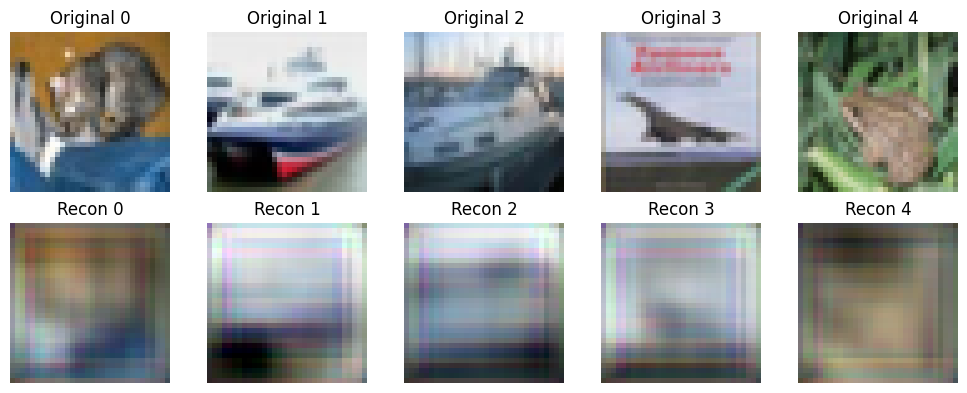

In [21]:
from PIL import Image
import matplotlib.pyplot as plt

# Số lượng cặp ảnh
num_samples = 5

plt.figure(figsize=(10, 4))

for i in range(num_samples):
    path = f"sample_{i}_original.pnm"
    img = Image.open(path)

    plt.subplot(2, num_samples, i + 1)   # hàng 1
    plt.imshow(img)
    plt.title(f"Original {i}")
    plt.axis("off")

for i in range(num_samples):
    path = f"sample_{i}_reconstructed.pnm"
    img = Image.open(path)

    plt.subplot(2, num_samples, num_samples + i + 1)   # hàng 2
    plt.imshow(img)
    plt.title(f"Recon {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()


## 3) GPU Optimization Version 1:

In [22]:
%%writefile gpu_layers_opt1.h
#pragma once
#include <cuda_runtime.h>
#include <stdio.h>

#define TILE_W 16
#define TILE_H 16
// Kích thước Kernel
#define K 3
#define R (K/2) // Radius = 1
#define BLOCK_W (TILE_W + 2 * R)
#define BLOCK_H (TILE_H + 2 * R)
__constant__ float dc_bias[256];


#define CHECK_CUDA(call)                                                \
    do {                                                                \
        cudaError_t err = call;                                         \
        if (err != cudaSuccess) {                                       \
            fprintf(stderr, "CUDA Error %s:%d: %s\n",                   \
                    __FILE__, __LINE__, cudaGetErrorString(err));       \
            exit(EXIT_FAILURE);                                         \
        }                                                               \
    } while (0)

// NCHW layout: [N, C, H, W]
__device__ __host__ inline int idx4(int n, int c, int h, int w,
                                    int C, int H, int W) {
    return ((n * C + c) * H + h) * W + w;
}

// ==== KERNEL DECLARATIONS ====
void update_dc_bias(float* d_bias_ptr, int count);
__global__ void conv2d_forward(
    float* __restrict__ input,    // [N, C_in, H, W]
    float* __restrict__ weight,   // [C_out, C_in, K, K]
    // float* bias,     // [C_out]
    float* __restrict__ output,   // [N, C_out, H_out, W_out]
    int N, int C_in, int H, int W,
    int C_out, int pad, int stride);

__global__ void relu_forward(float* x, int size);

__global__ void maxpool2x2_forward(
    float* __restrict__ input,  // [N, C, H, W]
    float* __restrict__ output,       // [N, C, H/2, W/2]
    int N, int C, int H, int W);

__global__ void upsample2x2_forward(
    float* __restrict__ input,  // [N, C, H, W]
    float* __restrict__ output,       // [N, C, 2H, 2W]
    int N, int C, int H, int W);

__global__ void mse_loss_forward(
    float* __restrict__ output,
    float* __restrict__ target,
    float* __restrict__ loss,   // single float on device
    int size);

__global__ void relu_backward(
    float* __restrict__ x,       // forward output/input to ReLU
    float* __restrict__ grad_y,  // dL/dy
    float* __restrict__ grad_x,        // dL/dx
    int size);

__global__ void maxpool2x2_backward(
    float* __restrict__ input,
    float* __restrict__ grad_out,
    float* __restrict__ grad_in,
    int N, int C, int H, int W);

__global__ void upsample2x2_backward(
    float* __restrict__ grad_out,
    float* __restrict__ grad_in,
    int N, int C, int H, int W);


__global__ void mse_loss_backward(
    float* __restrict__ output,
    float* __restrict__ target,
    float* __restrict__ grad_out,
    int size);

__global__ void conv2d_backward_input(
    float* __restrict__ dY,
    float* __restrict__ weight,
    float* __restrict__ dX,
    int N, int C_in, int H, int W,
    int C_out, int pad, int stride);

__global__ void conv2d_backward_weight(
    float* __restrict__ input,
    float* __restrict__ dY,
    float* __restrict__ dW,
    int N, int C_in, int H, int W,
    int C_out, int pad, int stride);

__global__ void conv2d_backward_bias(
    float* __restrict__ dY,
    float* __restrict__ dB,
    int N, int C_out, int H_out, int W_out);

__global__ void sgd_update(
    float* __restrict__ param,
    float* __restrict__ grad,
    int size,
    float lr);


Writing gpu_layers_opt1.h


In [23]:
%%writefile gpu_layers_opt1.cu
#include "gpu_layers_opt1.h"

// --------------- Conv2D forward (optimization 1) ------------------
void update_dc_bias(float* d_bias_ptr, int count) {
    CHECK_CUDA(cudaMemcpyToSymbol(dc_bias, d_bias_ptr, count * sizeof(float),
                                   0, cudaMemcpyDeviceToDevice));
}

__global__ void conv2d_forward(
    float* __restrict__ input,    // [N, C_in, H, W]
    float* __restrict__ weight,   // [C_out, C_in, K, K]
    float* __restrict__ output,   // [N, C_out, H_out, W_out]
    int N, int C_in, int H, int W,
    int C_out, int pad, int stride)
{
    int H_out = (H + 2 * pad - K) / stride + 1;
    int W_out = (W + 2 * pad - K) / stride + 1;

    __shared__ float smem[BLOCK_H][BLOCK_W];

    int tx = threadIdx.x;
    int ty = threadIdx.y;

    int w_out = blockIdx.x * TILE_W + tx;
    int h_out = blockIdx.y * TILE_H + ty;

    int nc = blockIdx.z;
    int c_out = nc % C_out;
    int n = nc / C_out;

    float value = 0.0f;

    int row_start = blockIdx.y * TILE_H * stride - pad;
    int col_start = blockIdx.x * TILE_W * stride - pad;

    for (int c_in = 0; c_in < C_in; c_in++) {
        // Load input tile into shared memory
        for (int i = ty; i < BLOCK_H; i += blockDim.y) {
            for (int j = tx; j < BLOCK_W; j += blockDim.x) {
                int h_in = row_start + i;
                int w_in = col_start + j;

                if (h_in >= 0 && h_in < H && w_in >= 0 && w_in < W) {
                    size_t input_idx = idx4(n, c_in, h_in, w_in, C_in, H, W);
                    smem[i][j] = input[input_idx];
                } else {
                    smem[i][j] = 0.0f;
                }
            }
        }
        __syncthreads();

        // Compute convolution
        for (int i = 0; i < K; ++i) {
            for (int j = 0; j < K; ++j) {
                size_t weight_idx = idx4(c_out, c_in, i, j, C_in, K, K);
                value += smem[ty + i][tx + j] * weight[weight_idx];
            }
        }
        __syncthreads();
    }

    if (w_out < W_out && h_out < H_out && n < N) {
        value += dc_bias[c_out];
        output[idx4(n, c_out, h_out, w_out, C_out, H_out, W_out)] = value;
    }
}

// --------------- ReLU ------------------
__global__ void relu_forward(float* __restrict__ x, int size)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < size) {
        float v = x[i];
        x[i] = (v > 0.0f) ? v : 0.0f;
    }
}

// --------------- MaxPool 2x2 (stride 2) ------------------
__global__ void maxpool2x2_forward(
    float* __restrict__ input,
    float* __restrict__ output,
    int N, int C, int H, int W)
{
    int H_out = H / 2;
    int W_out = W / 2;

    int w_out = blockIdx.x * blockDim.x + threadIdx.x;
    int h_out = blockIdx.y * blockDim.y + threadIdx.y;
    int nc = blockIdx.z;

    if (w_out >= W_out || h_out >= H_out) return;

    int n = nc / C;
    int c = nc % C;
    if (n >= N) return;

    int h_in0 = h_out * 2;
    int w_in0 = w_out * 2;

    float m = -1e30f;
    for (int dh = 0; dh < 2; dh++) {
        for (int dw = 0; dw < 2; dw++) {
            int h_in = h_in0 + dh;
            int w_in = w_in0 + dw;
            int idx = idx4(n, c, h_in, w_in, C, H, W);
            float v = input[idx];
            if (v > m) m = v;
        }
    }

    int out_idx = idx4(n, c, h_out, w_out, C, H_out, W_out);
    output[out_idx] = m;
}

// --------------- UpSample 2x2 (nearest) ------------------
__global__ void upsample2x2_forward(
    float* __restrict__ input,
    float* __restrict__ output,
    int N, int C, int H, int W)
{
    int H_out = H * 2;
    int W_out = W * 2;

    int w_out = blockIdx.x * blockDim.x + threadIdx.x;
    int h_out = blockIdx.y * blockDim.y + threadIdx.y;
    int nc = blockIdx.z;

    if (w_out >= W_out || h_out >= H_out) return;

    int n = nc / C;
    int c = nc % C;
    if (n >= N) return;

    int h_in = h_out / 2;
    int w_in = w_out / 2;

    int idx_in = idx4(n, c, h_in, w_in, C, H, W);
    int idx_out = idx4(n, c, h_out, w_out, C, H_out, W_out);
    output[idx_out] = input[idx_in];
}

// --------------- MSE loss ------------------
__global__ void mse_loss_forward(
    float* __restrict__ output,
    float* __restrict__ target,
    float* __restrict__ loss,
    int size)
{
    extern __shared__ float sdata[];

    int tid = threadIdx.x;
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    float val = 0.0f;
    if (idx < size) {
        float diff = output[idx] - target[idx];
        val = diff * diff;
    }
    sdata[tid] = val;
    __syncthreads();

    // Parallel reduction
    for (int s = blockDim.x / 2; s > 0; s >>= 1) {
        if (tid < s) {
            sdata[tid] += sdata[tid + s];
        }
        __syncthreads();
    }

    if (tid == 0) {
        atomicAdd(loss, sdata[0]);
    }
}

// --------------- ReLU backward ------------------
__global__ void relu_backward(
    float* __restrict__ x,
    float* __restrict__ grad_y,
    float* __restrict__ grad_x,
    int size)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < size) {
        grad_x[i] = (x[i] > 0.0f) ? grad_y[i] : 0.0f;
    }
}

// --------------- MaxPool 2x2 backward ------------------
__global__ void maxpool2x2_backward(
    float* __restrict__ input,
    float* __restrict__ grad_out,
    float* __restrict__ grad_in,
    int N, int C, int H, int W)
{
    int H_out = H / 2;
    int W_out = W / 2;

    int w_out = blockIdx.x * blockDim.x + threadIdx.x;
    int h_out = blockIdx.y * blockDim.y + threadIdx.y;
    int nc = blockIdx.z;

    if (w_out >= W_out || h_out >= H_out) return;

    int n = nc / C;
    int c = nc % C;
    if (n >= N) return;

    int h_in0 = h_out * 2;
    int w_in0 = w_out * 2;

    int idx00 = idx4(n, c, h_in0 + 0, w_in0 + 0, C, H, W);
    int idx01 = idx4(n, c, h_in0 + 0, w_in0 + 1, C, H, W);
    int idx10 = idx4(n, c, h_in0 + 1, w_in0 + 0, C, H, W);
    int idx11 = idx4(n, c, h_in0 + 1, w_in0 + 1, C, H, W);

    float v00 = input[idx00];
    float v01 = input[idx01];
    float v10 = input[idx10];
    float v11 = input[idx11];

    float g = grad_out[idx4(n, c, h_out, w_out, C, H_out, W_out)];

    float m = v00;
    int max_idx = 0;
    if (v01 > m) { m = v01; max_idx = 1; }
    if (v10 > m) { m = v10; max_idx = 2; }
    if (v11 > m) { m = v11; max_idx = 3; }

    if (max_idx == 0) grad_in[idx00] = g;
    else if (max_idx == 1) grad_in[idx01] = g;
    else if (max_idx == 2) grad_in[idx10] = g;
    else grad_in[idx11] = g;
}

// --------------- UpSample 2x2 backward ------------------
__global__ void upsample2x2_backward(
    float* __restrict__ grad_out,
    float* __restrict__ grad_in,
    int N, int C, int H, int W)
{
    int H_out = H * 2;
    int W_out = W * 2;

    int w_in = blockIdx.x * blockDim.x + threadIdx.x;
    int h_in = blockIdx.y * blockDim.y + threadIdx.y;
    int nc = blockIdx.z;

    if (w_in >= W || h_in >= H) return;

    int n = nc / C;
    int c = nc % C;
    if (n >= N) return;

    int h_out0 = h_in * 2;
    int w_out0 = w_in * 2;

    float sum = 0.0f;
    for (int dh = 0; dh < 2; ++dh) {
        for (int dw = 0; dw < 2; ++dw) {
            int h_out = h_out0 + dh;
            int w_out = w_out0 + dw;
            int idx_o = idx4(n, c, h_out, w_out, C, H_out, W_out);
            sum += grad_out[idx_o];
        }
    }

    int idx_in = idx4(n, c, h_in, w_in, C, H, W);
    grad_in[idx_in] = sum;
}

// --------------- MSE loss backward ------------------
__global__ void mse_loss_backward(
    float* __restrict__ output,
    float* __restrict__ target,
    float* __restrict__ grad_out,
    int size)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i >= size) return;
    grad_out[i] = 2.0f * (output[i] - target[i]) / size;
}

// --------------- Conv2D backward: dX ------------------
__global__ void conv2d_backward_input(
    float* __restrict__ dY,
    float* __restrict__ weight,
    float* __restrict__ dX,
    int N, int C_in, int H, int W,
    int C_out, int pad, int stride)
{
    int H_out = (H + 2 * pad - K) / stride + 1;
    int W_out = (W + 2 * pad - K) / stride + 1;

    // Shared Memory chứa dY
    __shared__ float s_dY[BLOCK_H][BLOCK_W];

    int tx = threadIdx.x;
    int ty = threadIdx.y;

    // Tọa độ dX (output của kernel này)
    int h_out = blockIdx.y * TILE_H + ty;
    int w_out = blockIdx.x * TILE_W + tx;

    int nc = blockIdx.z;
    int c_in = nc % C_in;
    int n = nc / C_in;
    //if (h_out >= H || w_out >= W || n >= N) return;

    float value = 0.0f;

    for (int c_out = 0; c_out < C_out; ++c_out) {
        // Tọa độ dY cần tải
        int h_global = h_out;
        int w_global = w_out;

        // Tải main tile
        if (h_global >= 0 && h_global < H_out && w_global >= 0 && w_global < W_out) {
            s_dY[ty + pad][tx + pad] = dY[idx4(n, c_out, h_global, w_global, C_out, H_out, W_out)];
        } else {
            s_dY[ty + pad][tx + pad] = 0.0f;
        }

        // Tải biên trên/dưới
        if (ty < pad) {
            // Biên trên
            int h_top = blockIdx.y * TILE_H + ty - pad;
            if (h_top >= 0 && h_top < H_out && w_global >= 0 && w_global < W_out) {
                s_dY[ty][tx + pad] = dY[idx4(n, c_out, h_top, w_global, C_out, H_out, W_out)];
            } else {
                s_dY[ty][tx + pad] = 0.0f;
            }

            // Biên dưới
            int h_bottom = blockIdx.y * TILE_H + TILE_H + pad - 1 - ty;
            if (h_bottom >= 0 && h_bottom < H_out && w_global >= 0 && w_global < W_out) {
                s_dY[BLOCK_H - 1 - ty][tx + pad] = dY[idx4(n, c_out, h_bottom, w_global, C_out, H_out, W_out)];
            } else {
                s_dY[BLOCK_H - 1 - ty][tx + pad] = 0.0f;
            }
        }

        // Tải biên trái/phải
        if (tx < pad) {
            // Biên trái
            int w_left = blockIdx.x * TILE_W + tx - pad;
            if (w_left >= 0 && w_left < W_out && h_global >= 0 && h_global < H_out) {
                s_dY[ty + pad][tx] = dY[idx4(n, c_out, h_global, w_left, C_out, H_out, W_out)];
            } else {
                s_dY[ty + pad][tx] = 0.0f;
            }

            // Biên phải
            int w_right = blockIdx.x * TILE_W + TILE_W + pad - 1 - tx;
            if (w_right >= 0 && w_right < W_out && h_global >= 0 && h_global < H_out) {
                s_dY[ty + pad][BLOCK_W - 1 - tx] = dY[idx4(n, c_out, h_global, w_right, C_out, H_out, W_out)];
            } else {
                s_dY[ty + pad][BLOCK_W - 1 - tx] = 0.0f;
            }
        }

        // Tải 4 góc (Thread (0,0) tải)
        if (tx == 0 && ty == 0) {
            // Góc trên trái [0][0]
            int h_c = blockIdx.y * TILE_H - pad;
            int w_c = blockIdx.x * TILE_W - pad;
            s_dY[0][0] = (h_c >= 0 && h_c < H_out && w_c >= 0 && w_c < W_out) ? dY[idx4(n, c_out, h_c, w_c, C_out, H_out, W_out)] : 0.0f;

            // Góc trên phải [0][17]
            w_c = blockIdx.x * TILE_W + TILE_W + pad - 1;
            s_dY[0][BLOCK_W - 1] = (h_c >= 0 && h_c < H_out && w_c >= 0 && w_c < W_out) ? dY[idx4(n, c_out, h_c, w_c, C_out, H_out, W_out)] : 0.0f;

            // Góc dưới trái [17][0]
            h_c = blockIdx.y * TILE_H + TILE_H + pad - 1;
            w_c = blockIdx.x * TILE_W - pad;
            s_dY[BLOCK_H - 1][0] = (h_c >= 0 && h_c < H_out && w_c >= 0 && w_c < W_out) ? dY[idx4(n, c_out, h_c, w_c, C_out, H_out, W_out)] : 0.0f;

            // Góc dưới phải [17][17]
            w_c = blockIdx.x * TILE_W + TILE_W + pad - 1;
            s_dY[BLOCK_H - 1][BLOCK_W - 1] = (h_c >= 0 && h_c < H_out && w_c >= 0 && w_c < W_out) ? dY[idx4(n, c_out, h_c, w_c, C_out, H_out, W_out)] : 0.0f;
        }

        __syncthreads();

        // Tính convolution
            for (int kh = 0; kh < K; ++kh) {
                for (int kw = 0; kw < K; ++kw) {
                    int smem_y = ty + 2 * pad - kh;
                    int smem_x = tx + 2* pad - kw;

                    size_t w_idx = idx4(c_out, c_in, K - 1 - kh, K - 1 - kw, C_in, K, K);
                    value += s_dY[smem_y][smem_x] * weight[w_idx];
                }
            }
        __syncthreads();
    }

    if (h_out < H && w_out < W && n < N) {
        dX[idx4(n, c_in, h_out, w_out, C_in, H, W)] = value;
    }
}

// --------------- Conv2D backward: dW ------------------
__global__ void conv2d_backward_weight(
    float* __restrict__ input,
    float* __restrict__ dY,
    float* __restrict__ dW,
    int N, int C_in, int H, int W,
    int C_out, int pad, int stride)
{
    int H_out = (H + 2 * pad - K) / stride + 1;
    int W_out = (W + 2 * pad - K) / stride + 1;

    __shared__ float s_in[BLOCK_H][BLOCK_W];
    __shared__ float s_dY[TILE_H][TILE_W];

    int tx = threadIdx.x;
    int ty = threadIdx.y;

    int index = blockIdx.z;
    int c_in = index % C_in;
    int c_out = index / C_in;

    float dw[K][K];
    for (int i = 0; i < K; ++i)
        for (int j = 0; j < K; ++j)
            dw[i][j] = 0.0f;

    for (int n = 0; n < N; ++n) {
        int num_blocks_h = (H_out + TILE_H - 1) / TILE_H;
        int num_blocks_w = (W_out + TILE_W - 1) / TILE_W;

        for (int block_h = 0; block_h < num_blocks_h; ++block_h) {
            for (int block_w = 0; block_w < num_blocks_w; ++block_w) {

                // Load s_dY
                int h_out = block_h * TILE_H + ty;
                int w_out = block_w * TILE_W + tx;

                if (h_out < H_out && w_out < W_out) {
                    s_dY[ty][tx] = dY[idx4(n, c_out, h_out, w_out, C_out, H_out, W_out)];
                } else {
                    s_dY[ty][tx] = 0.0f;
                }

                // Load s_in
                int h_in_base = block_h * TILE_H + ty;
                int w_in_base = block_w * TILE_W + tx;

                // Main tile
                if (h_in_base >= 0 && h_in_base < H && w_in_base >= 0 && w_in_base < W) {
                    s_in[ty + pad][tx + pad] = input[idx4(n, c_in, h_in_base, w_in_base, C_in, H, W)];
                } else {
                    s_in[ty + pad][tx + pad] = 0.0f;
                }

                // Top/bottom borders
                if (ty < pad) {
                    int h_top = block_h * TILE_H - pad + ty;
                    if (h_top >= 0 && h_top < H && w_in_base >= 0 && w_in_base < W) {
                        s_in[ty][tx + pad] = input[idx4(n, c_in, h_top, w_in_base, C_in, H, W)];
                    } else {
                        s_in[ty][tx + pad] = 0.0f;
                    }

                    int h_bottom = block_h * TILE_H + TILE_H + pad - 1 - ty;
                    if (h_bottom >= 0 && h_bottom < H && w_in_base >= 0 && w_in_base < W) {
                        s_in[BLOCK_H - 1 - ty][tx + pad] = input[idx4(n, c_in, h_bottom, w_in_base, C_in, H, W)];
                    } else {
                        s_in[BLOCK_H - 1 - ty][tx + pad] = 0.0f;
                    }
                }

                // Left/right borders
                if (tx < pad) {
                    int w_left = block_w * TILE_W - pad + tx;
                    if (w_left >= 0 && w_left < W && h_in_base >= 0 && h_in_base < H) {
                        s_in[ty + pad][tx] = input[idx4(n, c_in, h_in_base, w_left, C_in, H, W)];
                    } else {
                        s_in[ty + pad][tx] = 0.0f;
                    }

                    int w_right = block_w * TILE_W + TILE_W + pad - 1 - tx;
                    if (w_right >= 0 && w_right < W && h_in_base >= 0 && h_in_base < H) {
                        s_in[ty + pad][BLOCK_W - 1 - tx] = input[idx4(n, c_in, h_in_base, w_right, C_in, H, W)];
                    } else {
                        s_in[ty + pad][BLOCK_W - 1 - tx] = 0.0f;
                    }
                }

                // Thread (0,0) loads 4 corners
                if (tx == 0 && ty == 0) {
                    int h_c = block_h * TILE_H - pad;
                    int w_c = block_w * TILE_W - pad;
                    s_in[0][0] = (h_c >= 0 && h_c < H && w_c >= 0 && w_c < W)
                        ? input[idx4(n, c_in, h_c, w_c, C_in, H, W)] : 0.0f;

                    w_c = block_w * TILE_W + TILE_W + pad - 1;
                    s_in[0][BLOCK_W - 1] = (h_c >= 0 && h_c < H && w_c >= 0 && w_c < W)
                        ? input[idx4(n, c_in, h_c, w_c, C_in, H, W)] : 0.0f;

                    h_c = block_h * TILE_H + TILE_H + pad - 1;
                    w_c = block_w * TILE_W - pad;
                    s_in[BLOCK_H - 1][0] = (h_c >= 0 && h_c < H && w_c >= 0 && w_c < W)
                        ? input[idx4(n, c_in, h_c, w_c, C_in, H, W)] : 0.0f;

                    w_c = block_w * TILE_W + TILE_W + pad - 1;
                    s_in[BLOCK_H - 1][BLOCK_W - 1] = (h_c >= 0 && h_c < H && w_c >= 0 && w_c < W)
                        ? input[idx4(n, c_in, h_c, w_c, C_in, H, W)] : 0.0f;
                }

                __syncthreads();

                // Compute dW: X * dY
                float val_dy = s_dY[ty][tx];
                for (int kh = 0; kh < K; ++kh) {
                    for (int kw = 0; kw < K; ++kw) {
                        dw[kh][kw] += s_in[ty + kh][tx + kw] * val_dy;
                    }
                }

                __syncthreads();
            }
        }
    }

    for (int i = 0; i < K; ++i) {
        for (int j = 0; j < K; ++j) {
            // Tính index global của dW[i][j] cho cặp filter (c_out, c_in)
            size_t dw_idx = idx4(c_out, c_in, i, j, C_in, K, K);
            // Cộng giá trị dw[i][j] của thread hiện tại vào bộ nhớ global
            atomicAdd(&dW[dw_idx], dw[i][j]);
        }
    }
}

// --------------- Conv2D backward: dB ------------------
__global__ void conv2d_backward_bias(
    float* __restrict__ dY,
    float* __restrict__ dB,
    int N, int C_out, int H_out, int W_out)
{
    int spatial_size = H_out * W_out;
    int channel_size = N * spatial_size;
    extern __shared__ float sdata[];
    int tid = threadIdx.x;
    int c = blockIdx.x;
    if (c >= C_out) return;
    float sum = 0.0f;
    for (int i = tid; i < channel_size; i += blockDim.x) {
        int n = i / spatial_size;
        int rem = i % spatial_size;
        int global_idx = n * (C_out * spatial_size) + c * spatial_size + rem;
        sum += dY[global_idx];
    }
    sdata[tid] = sum;
    __syncthreads();

    // Reduction
    for (int s = blockDim.x / 2; s > 0; s >>= 1) {
        if (tid < s) {
            sdata[tid] += sdata[tid + s];
        }
        __syncthreads();
    }

    if (tid == 0) {
        dB[c] = sdata[0];
    }
}

// --------------- SGD update ------------------
__global__ void sgd_update(
    float* __restrict__ param,
    float* __restrict__ grad,
    int size,
    float lr)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < size) {
        param[i] -= lr * grad[i];
    }
}


Writing gpu_layers_opt1.cu


In [24]:
%%writefile gpu_autoencoder_opt1.h
// header for GPUAutoencoder (the struct + declarations)
#pragma once
#include "gpu_layers_opt1.h"
#include <cstdlib>
#include <cstdio>
#include <cmath>
#include <cuda_runtime.h>

// latent 128 x 8 x 8
static const int AE_LATENT_C   = 128;
static const int AE_LATENT_H   = 8;
static const int AE_LATENT_W   = 8;
static const int AE_LATENT_DIM = AE_LATENT_C * AE_LATENT_H * AE_LATENT_W;

// This autoencoder matches the project architecture exactly.
// Layout: NCHW [batch, channels, height, width]
struct GPUAutoencoder {
    int N;   // batch size
    int H;   // 32
    int W;   // 32;

    // --- Conv layer parameters ---
    // conv1: 3 -> 256 (3x3)
    float *d_w1, *d_b1;
    // conv2: 256 -> 128
    float *d_w2, *d_b2;
    // conv3: 128 -> 128
    float *d_w3, *d_b3;
    // conv4: 128 -> 256
    float *d_w4, *d_b4;
    // conv5: 256 -> 3
    float *d_w5, *d_b5;

    // --- Activations ---
    // Input batch
    float *d_x0;   // [N, 3, 32, 32]

    // Encoder
    float *d_h1;   // conv1 out: [N, 256, 32, 32]
    float *d_p1;   // pool1   : [N, 256, 16, 16]
    float *d_h2;   // conv2   : [N, 128, 16, 16]
    float *d_p2;   // pool2   : [N, 128,  8,  8]   (latent)

    // Decoder
    float *d_h3;   // conv3   : [N, 128,  8,  8]
    float *d_u1;   // up1     : [N, 128, 16, 16]
    float *d_h4;   // conv4   : [N, 256, 16, 16]
    float *d_u2;   // up2     : [N, 256, 32, 32]
    float *d_out;  // conv5   : [N,   3, 32, 32]

    // Loss buffer
    float *d_loss; // single float on device

    // ---- gradients for activations ----
    float *d_gx0; ///
    float *d_gh1;
    float *d_gp1;
    float *d_gh2;
    float *d_gp2;
    float *d_gh3;
    float *d_gu1;
    float *d_gh4;
    float *d_gu2;
    float *d_gout;

    // ---- gradients for weights, biases ----
    float *d_gw1, *d_gb1;
    float *d_gw2, *d_gb2;
    float *d_gw3, *d_gb3;
    float *d_gw4, *d_gb4;
    float *d_gw5, *d_gb5;
};

// API
void gpu_autoencoder_init(GPUAutoencoder *ae, int batch_size);
void gpu_autoencoder_free(GPUAutoencoder *ae);

void gpu_autoencoder_copy_weights_to_host(
    GPUAutoencoder *ae,
    float *h_w1, float *h_b1,
    float *h_w2, float *h_b2,
    float *h_w3, float *h_b3,
    float *h_w4, float *h_b4,
    float *h_w5, float *h_b5);

void gpu_autoencoder_copy_weights_to_device(
    GPUAutoencoder *ae,
    const float *h_w1, const float *h_b1,
    const float *h_w2, const float *h_b2,
    const float *h_w3, const float *h_b3,
    const float *h_w4, const float *h_b4,
    const float *h_w5, const float *h_b5);


// Forward on GPU:
//   h_input  : host pointer [N * 3 * 32 * 32]
//   h_output : host pointer [N * 3 * 32 * 32]
//   returns loss value (MSE(x_hat, x)) if compute_loss=true;
//   otherwise returns 0.0f.
float gpu_autoencoder_forward(
    GPUAutoencoder *ae,
    const float *h_input,
    float *h_output,
    bool compute_loss = true);

void gpu_autoencoder_backward(GPUAutoencoder *ae, float lr);

void gpu_autoencoder_save_weights(GPUAutoencoder *ae, const char *filename);

void gpu_autoencoder_load_weights(GPUAutoencoder *ae, const char *filename);

// encode only: lấy latent [N_batch, 128, 8, 8] -> h_latent [N_batch, AE_LATENT_DIM]
void gpu_autoencoder_encode_batch(
    GPUAutoencoder *ae,
    const float *h_input,
    float *h_latent,
    int N_batch);


Writing gpu_autoencoder_opt1.h


In [25]:
%%writefile gpu_autoencoder_opt1.cu
#include "gpu_autoencoder_opt1.h"
#include <cmath>


static inline float rand_uniform(float min_val, float max_val) {
    float r = (float)rand() / (float)RAND_MAX;
    return min_val + r * (max_val - min_val);
}

void gpu_autoencoder_init(GPUAutoencoder *ae, int batch_size) {
    ae->N = batch_size;
    ae->H = 32;
    ae->W = 32;

    const int N = ae->N;
    const int H = ae->H;
    const int W = ae->W;

    // ---------- allocate weights ----------

    int C_in1 = 3,   C_out1 = 256;
    int C_in2 = 256, C_out2 = 128;
    int C_in3 = 128, C_out3 = 128;
    int C_in4 = 128, C_out4 = 256;
    int C_in5 = 256, C_out5 = 3;

    size_t w1_bytes = C_out1 * C_in1 * K * K * sizeof(float);
    size_t b1_bytes = C_out1 * sizeof(float);
    size_t w2_bytes = C_out2 * C_in2 * K * K * sizeof(float);
    size_t b2_bytes = C_out2 * sizeof(float);
    size_t w3_bytes = C_out3 * C_in3 * K * K * sizeof(float);
    size_t b3_bytes = C_out3 * sizeof(float);
    size_t w4_bytes = C_out4 * C_in4 * K * K * sizeof(float);
    size_t b4_bytes = C_out4 * sizeof(float);
    size_t w5_bytes = C_out5 * C_in5 * K * K * sizeof(float);
    size_t b5_bytes = C_out5 * sizeof(float);

    CHECK_CUDA(cudaMalloc(&ae->d_w1, w1_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_b1, b1_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_w2, w2_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_b2, b2_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_w3, w3_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_b3, b3_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_w4, w4_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_b4, b4_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_w5, w5_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_b5, b5_bytes));

    // init weights on host
// find max weight bytes
size_t max_w_bytes = w1_bytes;
if (w2_bytes > max_w_bytes) max_w_bytes = w2_bytes;
if (w3_bytes > max_w_bytes) max_w_bytes = w3_bytes;
if (w4_bytes > max_w_bytes) max_w_bytes = w4_bytes;
if (w5_bytes > max_w_bytes) max_w_bytes = w5_bytes;

// find max bias bytes
size_t max_b_bytes = b1_bytes;
if (b2_bytes > max_b_bytes) max_b_bytes = b2_bytes;
if (b3_bytes > max_b_bytes) max_b_bytes = b3_bytes;
if (b4_bytes > max_b_bytes) max_b_bytes = b4_bytes;
if (b5_bytes > max_b_bytes) max_b_bytes = b5_bytes;

float *h_w = (float*)malloc(max_w_bytes);
float *h_b = (float*)malloc(max_b_bytes);


    auto init_wb = [&](float *d_w, size_t w_bytes, float *d_b, size_t b_bytes) {
        size_t w_cnt = w_bytes / sizeof(float);
        size_t b_cnt = b_bytes / sizeof(float);
        for (size_t i = 0; i < w_cnt; ++i) h_w[i] = rand_uniform(-0.05f, 0.05f);
        for (size_t i = 0; i < b_cnt; ++i) h_b[i] = rand_uniform(-0.05f, 0.05f);
        CHECK_CUDA(cudaMemcpy(d_w, h_w, w_bytes, cudaMemcpyHostToDevice));
        CHECK_CUDA(cudaMemcpy(d_b, h_b, b_bytes, cudaMemcpyHostToDevice));
    };

    init_wb(ae->d_w1, w1_bytes, ae->d_b1, b1_bytes);
    init_wb(ae->d_w2, w2_bytes, ae->d_b2, b2_bytes);
    init_wb(ae->d_w3, w3_bytes, ae->d_b3, b3_bytes);
    init_wb(ae->d_w4, w4_bytes, ae->d_b4, b4_bytes);
    init_wb(ae->d_w5, w5_bytes, ae->d_b5, b5_bytes);

    free(h_w);
    free(h_b);

    // ---------- allocate activations ---------- [batch_size, channels, height, width]
    size_t bytes_x0  = N * 3   * 32 * 32 * sizeof(float);
    size_t bytes_h1  = N * 256 * 32 * 32 * sizeof(float);
    size_t bytes_p1  = N * 256 * 16 * 16 * sizeof(float);
    size_t bytes_h2  = N * 128 * 16 * 16 * sizeof(float);
    size_t bytes_p2  = N * 128 *  8 *  8 * sizeof(float);
    size_t bytes_h3  = N * 128 *  8 *  8 * sizeof(float);
    size_t bytes_u1  = N * 128 * 16 * 16 * sizeof(float);
    size_t bytes_h4  = N * 256 * 16 * 16 * sizeof(float);
    size_t bytes_u2  = N * 256 * 32 * 32 * sizeof(float);
    size_t bytes_out = N * 3   * 32 * 32 * sizeof(float);

    CHECK_CUDA(cudaMalloc(&ae->d_x0,  bytes_x0));
    CHECK_CUDA(cudaMalloc(&ae->d_h1,  bytes_h1));
    CHECK_CUDA(cudaMalloc(&ae->d_p1,  bytes_p1));
    CHECK_CUDA(cudaMalloc(&ae->d_h2,  bytes_h2));
    CHECK_CUDA(cudaMalloc(&ae->d_p2,  bytes_p2));
    CHECK_CUDA(cudaMalloc(&ae->d_h3,  bytes_h3));
    CHECK_CUDA(cudaMalloc(&ae->d_u1,  bytes_u1));
    CHECK_CUDA(cudaMalloc(&ae->d_h4,  bytes_h4));
    CHECK_CUDA(cudaMalloc(&ae->d_u2,  bytes_u2));
    CHECK_CUDA(cudaMalloc(&ae->d_out, bytes_out));

    // loss buffer
    CHECK_CUDA(cudaMalloc(&ae->d_loss, sizeof(float)));

    // ---------- allocate activation gradients ----------
    CHECK_CUDA(cudaMalloc(&ae->d_gx0,  bytes_x0));
    CHECK_CUDA(cudaMalloc(&ae->d_gh1,  bytes_h1));
    CHECK_CUDA(cudaMalloc(&ae->d_gp1,  bytes_p1));
    CHECK_CUDA(cudaMalloc(&ae->d_gh2,  bytes_h2));
    CHECK_CUDA(cudaMalloc(&ae->d_gp2,  bytes_p2));
    CHECK_CUDA(cudaMalloc(&ae->d_gh3,  bytes_h3));
    CHECK_CUDA(cudaMalloc(&ae->d_gu1,  bytes_u1));
    CHECK_CUDA(cudaMalloc(&ae->d_gh4,  bytes_h4));
    CHECK_CUDA(cudaMalloc(&ae->d_gu2,  bytes_u2));
    CHECK_CUDA(cudaMalloc(&ae->d_gout, bytes_out));

    // ---------- allocate weight gradients ----------
    CHECK_CUDA(cudaMalloc(&ae->d_gw1, w1_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_gb1, b1_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_gw2, w2_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_gb2, b2_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_gw3, w3_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_gb3, b3_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_gw4, w4_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_gb4, b4_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_gw5, w5_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_gb5, b5_bytes));
}

void gpu_autoencoder_free(GPUAutoencoder *ae) {
    // weights
    cudaFree(ae->d_w1); cudaFree(ae->d_b1);
    cudaFree(ae->d_w2); cudaFree(ae->d_b2);
    cudaFree(ae->d_w3); cudaFree(ae->d_b3);
    cudaFree(ae->d_w4); cudaFree(ae->d_b4);
    cudaFree(ae->d_w5); cudaFree(ae->d_b5);

    // activations
    cudaFree(ae->d_x0);
    cudaFree(ae->d_h1);
    cudaFree(ae->d_p1);
    cudaFree(ae->d_h2);
    cudaFree(ae->d_p2);
    cudaFree(ae->d_h3);
    cudaFree(ae->d_u1);
    cudaFree(ae->d_h4);
    cudaFree(ae->d_u2);
    cudaFree(ae->d_out);

    cudaFree(ae->d_loss);

    // activation gradients
    cudaFree(ae->d_gx0);
    cudaFree(ae->d_gh1);
    cudaFree(ae->d_gp1);
    cudaFree(ae->d_gh2);
    cudaFree(ae->d_gp2);
    cudaFree(ae->d_gh3);
    cudaFree(ae->d_gu1);
    cudaFree(ae->d_gh4);
    cudaFree(ae->d_gu2);
    cudaFree(ae->d_gout);

    // weight gradients
    cudaFree(ae->d_gw1); cudaFree(ae->d_gb1);
    cudaFree(ae->d_gw2); cudaFree(ae->d_gb2);
    cudaFree(ae->d_gw3); cudaFree(ae->d_gb3);
    cudaFree(ae->d_gw4); cudaFree(ae->d_gb4);
    cudaFree(ae->d_gw5); cudaFree(ae->d_gb5);
}

void gpu_autoencoder_copy_weights_to_host(
    GPUAutoencoder *ae,
    float *h_w1, float *h_b1,
    float *h_w2, float *h_b2,
    float *h_w3, float *h_b3,
    float *h_w4, float *h_b4,
    float *h_w5, float *h_b5)
{
    int C_in1 = 3,   C_out1 = 256;
    int C_in2 = 256, C_out2 = 128;
    int C_in3 = 128, C_out3 = 128;
    int C_in4 = 128, C_out4 = 256;
    int C_in5 = 256, C_out5 = 3;

    size_t w1_bytes = C_out1 * C_in1 * K * K * sizeof(float);
    size_t b1_bytes = C_out1 * sizeof(float);
    size_t w2_bytes = C_out2 * C_in2 * K * K * sizeof(float);
    size_t b2_bytes = C_out2 * sizeof(float);
    size_t w3_bytes = C_out3 * C_in3 * K * K * sizeof(float);
    size_t b3_bytes = C_out3 * sizeof(float);
    size_t w4_bytes = C_out4 * C_in4 * K * K * sizeof(float);
    size_t b4_bytes = C_out4 * sizeof(float);
    size_t w5_bytes = C_out5 * C_in5 * K * K * sizeof(float);
    size_t b5_bytes = C_out5 * sizeof(float);

    CHECK_CUDA(cudaMemcpy(h_w1, ae->d_w1, w1_bytes, cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaMemcpy(h_b1, ae->d_b1, b1_bytes, cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaMemcpy(h_w2, ae->d_w2, w2_bytes, cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaMemcpy(h_b2, ae->d_b2, b2_bytes, cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaMemcpy(h_w3, ae->d_w3, w3_bytes, cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaMemcpy(h_b3, ae->d_b3, b3_bytes, cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaMemcpy(h_w4, ae->d_w4, w4_bytes, cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaMemcpy(h_b4, ae->d_b4, b4_bytes, cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaMemcpy(h_w5, ae->d_w5, w5_bytes, cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaMemcpy(h_b5, ae->d_b5, b5_bytes, cudaMemcpyDeviceToHost));
}

void gpu_autoencoder_copy_weights_to_device(
    GPUAutoencoder *ae,
    const float *h_w1, const float *h_b1,
    const float *h_w2, const float *h_b2,
    const float *h_w3, const float *h_b3,
    const float *h_w4, const float *h_b4,
    const float *h_w5, const float *h_b5)
{
    int C_in1 = 3,   C_out1 = 256;
    int C_in2 = 256, C_out2 = 128;
    int C_in3 = 128, C_out3 = 128;
    int C_in4 = 128, C_out4 = 256;
    int C_in5 = 256, C_out5 = 3;

    size_t w1_bytes = C_out1 * C_in1 * K * K * sizeof(float);
    size_t b1_bytes = C_out1 * sizeof(float);
    size_t w2_bytes = C_out2 * C_in2 * K * K * sizeof(float);
    size_t b2_bytes = C_out2 * sizeof(float);
    size_t w3_bytes = C_out3 * C_in3 * K * K * sizeof(float);
    size_t b3_bytes = C_out3 * sizeof(float);
    size_t w4_bytes = C_out4 * C_in4 * K * K * sizeof(float);
    size_t b4_bytes = C_out4 * sizeof(float);
    size_t w5_bytes = C_out5 * C_in5 * K * K * sizeof(float);
    size_t b5_bytes = C_out5 * sizeof(float);

    CHECK_CUDA(cudaMemcpy(ae->d_w1, h_w1, w1_bytes, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(ae->d_b1, h_b1, b1_bytes, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(ae->d_w2, h_w2, w2_bytes, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(ae->d_b2, h_b2, b2_bytes, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(ae->d_w3, h_w3, w3_bytes, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(ae->d_b3, h_b3, b3_bytes, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(ae->d_w4, h_w4, w4_bytes, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(ae->d_b4, h_b4, b4_bytes, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(ae->d_w5, h_w5, w5_bytes, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(ae->d_b5, h_b5, b5_bytes, cudaMemcpyHostToDevice));
}


// Forward pass for ONE batch (no backward yet)
float gpu_autoencoder_forward(
    GPUAutoencoder *ae,
    const float *h_input,
    float *h_output,
    bool compute_loss)
{
    const int N = ae->N;
    const int H = ae->H;
    const int W = ae->W;
    const int pad = 1;
    const int stride = 1;

    // ------------- copy input to device -------------
    size_t in_bytes = N * 3 * H * W * sizeof(float);
    CHECK_CUDA(cudaMemcpy(ae->d_x0, h_input, in_bytes, cudaMemcpyHostToDevice));

    dim3 block2d(16, 16);

    // ========= ENCODER =========
    // conv1: 3 -> 256, same 32x32
    {
        int C_in = 3, C_out = 256;
        int H_out = 32, W_out = 32;
        dim3 gridConv(
            (W_out + block2d.x - 1) / block2d.x,
            (H_out + block2d.y - 1) / block2d.y,
            N * C_out);

        // copy bias to constant memory
        //CHECK_CUDA(cudaMemcpyToSymbol(dc_bias, ae->d_b1, C_out * sizeof(float)));
        update_dc_bias(ae->d_b1, C_out);
        conv2d_forward<<<gridConv, block2d>>>(
            ae->d_x0, ae->d_w1, ae->d_h1,
            N, C_in, H, W, C_out, pad, stride);

        // ReLU
        int size = N * C_out * H_out * W_out;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_forward<<<b, t>>>(ae->d_h1, size);

        // MaxPool 2x2 -> 16x16
        int Hp = 16, Wp = 16;
        dim3 gridPool(
            (Wp + block2d.x - 1) / block2d.x,
            (Hp + block2d.y - 1) / block2d.y,
            N * C_out);

        maxpool2x2_forward<<<gridPool, block2d>>>(
            ae->d_h1, ae->d_p1,
            N, C_out, H_out, W_out);
    }

    // conv2: 256 -> 128, 16x16, then pool -> 8x8
    {
        int C_in = 256, C_out = 128;
        int H_in = 16, W_in = 16;
        int H_out = 16, W_out = 16;
        dim3 gridConv(
            (W_out + block2d.x - 1) / block2d.x,
            (H_out + block2d.y - 1) / block2d.y,
            N * C_out);

        // copy bias to constant memory
        //CHECK_CUDA(cudaMemcpyToSymbol(dc_bias, ae->d_b2, 128 * sizeof(float)));
        update_dc_bias(ae->d_b2, C_out);
        conv2d_forward<<<gridConv, block2d>>>(
            ae->d_p1, ae->d_w2, ae->d_h2,
            N, C_in, H_in, W_in, C_out, pad, stride);

        int size = N * C_out * H_out * W_out;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_forward<<<b, t>>>(ae->d_h2, size);

        // pool -> 8x8
        int Hp = 8, Wp = 8;
        dim3 gridPool(
            (Wp + block2d.x - 1) / block2d.x,
            (Hp + block2d.y - 1) / block2d.y,
            N * C_out);

        maxpool2x2_forward<<<gridPool, block2d>>>(
            ae->d_h2, ae->d_p2,
            N, C_out, H_out, W_out);
    }

    // LATENT is ae->d_p2: [N, 128, 8, 8]

    // ========= DECODER =========
    // conv3: 128 -> 128, 8x8
    {
        int C_in = 128, C_out = 128;
        int H_in = 8, W_in = 8;
        int H_out = 8, W_out = 8;

        dim3 gridConv(
            (W_out + block2d.x - 1) / block2d.x,
            (H_out + block2d.y - 1) / block2d.y,
            N * C_out);

        // copy bias to constant memory
        //CHECK_CUDA(cudaMemcpyToSymbol(dc_bias, ae->d_b3, 128 * sizeof(float)));
        update_dc_bias(ae->d_b3, C_out);
        conv2d_forward<<<gridConv, block2d>>>(
            ae->d_p2, ae->d_w3, ae->d_h3,
            N, C_in, H_in, W_in, C_out, pad, stride);

        int size = N * C_out * H_out * W_out;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_forward<<<b, t>>>(ae->d_h3, size);

        // upsample 8x8 -> 16x16
        int Hu = 16, Wu = 16;
        dim3 gridUp(
            (Wu + block2d.x - 1) / block2d.x,
            (Hu + block2d.y - 1) / block2d.y,
            N * C_out);

        upsample2x2_forward<<<gridUp, block2d>>>(
            ae->d_h3, ae->d_u1,
            N, C_out, H_in, W_in);
    }

    // conv4: 128 -> 256, 16x16, then upsample 16->32
    {
        int C_in = 128, C_out = 256;
        int H_in = 16, W_in = 16;
        int H_out = 16, W_out = 16;

        dim3 gridConv(
            (W_out + block2d.x - 1) / block2d.x,
            (H_out + block2d.y - 1) / block2d.y,
            N * C_out);

        // copy bias to constant memory
        //CHECK_CUDA(cudaMemcpyToSymbol(dc_bias, ae->d_b4, 256 * sizeof(float)));
        update_dc_bias(ae->d_b4, C_out);
        conv2d_forward<<<gridConv, block2d>>>(
            ae->d_u1, ae->d_w4, ae->d_h4,
            N, C_in, H_in, W_in, C_out, pad, stride);

        int size = N * C_out * H_out * W_out;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_forward<<<b, t>>>(ae->d_h4, size);

        // upsample 16x16 -> 32x32
        int Hu = 32, Wu = 32;
        dim3 gridUp(
            (Wu + block2d.x - 1) / block2d.x,
            (Hu + block2d.y - 1) / block2d.y,
            N * C_out);

        upsample2x2_forward<<<gridUp, block2d>>>(
            ae->d_h4, ae->d_u2,
            N, C_out, H_in, W_in);
    }

    // conv5: 256 -> 3, 32x32 (no activation, usually MSE on raw output)
    {
        int C_in = 256, C_out = 3;
        int H_in = 32, W_in = 32;
        int H_out = 32, W_out = 32;

        dim3 gridConv(
            (W_out + block2d.x - 1) / block2d.x,
            (H_out + block2d.y - 1) / block2d.y,
            N * C_out);

        // copy bias to constant memory
        //CHECK_CUDA(cudaMemcpyToSymbol(dc_bias, ae->d_b5, 3 * sizeof(float)));
        update_dc_bias(ae->d_b5, C_out);
        conv2d_forward<<<gridConv, block2d>>>(
            ae->d_u2, ae->d_w5, ae->d_out,
            N, C_in, H_in, W_in, C_out, pad, stride);
    }

    // ------------- (optional) compute MSE loss -------------
    float loss_value = 0.0f;
        if (compute_loss) {
        int size = N * 3 * 32 * 32;
        CHECK_CUDA(cudaMemset(ae->d_loss, 0, sizeof(float)));

        int t = 256;
        int b = (size + t - 1) / t;
        size_t shmem_bytes = t * sizeof(float);

        // kernel giờ trả về SUM(diff^2) vào d_loss
        mse_loss_forward<<<b, t, shmem_bytes>>>(
            ae->d_out, ae->d_x0, ae->d_loss, size);

        float loss_sum = 0.0f;
        CHECK_CUDA(cudaMemcpy(&loss_sum, ae->d_loss,
                              sizeof(float),
                              cudaMemcpyDeviceToHost));

        loss_value = loss_sum / size;  // MSE = sum / size
    }


    // ------------- copy output back to host -------------
    size_t out_bytes = N * 3 * 32 * 32 * sizeof(float);
    CHECK_CUDA(cudaMemcpy(h_output, ae->d_out,
                          out_bytes,
                          cudaMemcpyDeviceToHost));

    return loss_value;
}

void gpu_autoencoder_backward(GPUAutoencoder *ae, float lr)
{
    const int N = ae->N;
    const int H0 = ae->H; // 32
    const int W0 = ae->W; // 32
    const int pad = 1;
    const int stride = 1;

    //Zero all gradient buffers
    CHECK_CUDA(cudaMemset(ae->d_gw1, 0, 256 * 3 * K * K * sizeof(float)));
    CHECK_CUDA(cudaMemset(ae->d_gb1, 0, 256 * sizeof(float)));
    CHECK_CUDA(cudaMemset(ae->d_gw2, 0, 128 * 256 * K * K * sizeof(float)));
    CHECK_CUDA(cudaMemset(ae->d_gb2, 0, 128 * sizeof(float)));
    CHECK_CUDA(cudaMemset(ae->d_gw3, 0, 128 * 128 * K * K * sizeof(float)));
    CHECK_CUDA(cudaMemset(ae->d_gb3, 0, 128 * sizeof(float)));
    CHECK_CUDA(cudaMemset(ae->d_gw4, 0, 256 * 128 * K * K * sizeof(float)));
    CHECK_CUDA(cudaMemset(ae->d_gb4, 0, 256 * sizeof(float)));
    CHECK_CUDA(cudaMemset(ae->d_gw5, 0, 3 * 256 * K * K * sizeof(float)));
    CHECK_CUDA(cudaMemset(ae->d_gb5, 0, 3 * sizeof(float)));

    dim3 block2d(16, 16);

    // ===== 1. dL/dout (MSE) =====
    int size_out = N * 3 * 32 * 32;
    {
        int t = 256;
        int b = (size_out + t - 1) / t;
        mse_loss_backward<<<b, t>>>(
            ae->d_out, ae->d_x0, ae->d_gout, size_out);
    }

    // ===== 2. Backward conv5: 256->3, 32x32 =====
    {
        int C_in = 256, C_out = 3;
        int H = 32, W = 32;

        // dU2
        dim3 gridIn(
            (W + block2d.x - 1) / block2d.x,
            (H + block2d.y - 1) / block2d.y,
            N * C_in);

        conv2d_backward_input<<<gridIn, block2d>>>(
            ae->d_gout, ae->d_w5, ae->d_gu2,
            N, C_in, H, W, C_out, pad, stride);

        // dW5
        dim3 blockW(16, 16);
        dim3 gridW(1, 1, C_out * C_in);
        conv2d_backward_weight<<<gridW, blockW>>>(ae->d_u2, ae->d_gout, ae->d_gw5, N, C_in, H, W, C_out, pad, stride);

        // dB5
        dim3 blockB(256);
        dim3 gridB(C_out);
        size_t shmem_size = 256 * sizeof(float);
        conv2d_backward_bias<<<gridB, blockB, shmem_size>>>(ae->d_gout, ae->d_gb5, N, C_out, H, W);

        // SGD update W5,B5
        int num_w = C_out * C_in * K * K;
        int t = 256;
        int bw = (num_w + t - 1) / t;
        sgd_update<<<bw, t>>>(ae->d_w5, ae->d_gw5, num_w, lr);

        int bbp = (C_out + t - 1) / t;
        sgd_update<<<bbp, t>>>(ae->d_b5, ae->d_gb5, C_out, lr);
    }

    // ===== 3. UpSample2x2 backward: U2 <- H4 =====
    {
        int C = 256;
        int H = 16, W = 16;   // H4 size
        int Hu = 32, Wu = 32; // U2 size

        dim3 grid(
            (W + block2d.x - 1) / block2d.x,
            (H + block2d.y - 1) / block2d.y,
            N * C);

        upsample2x2_backward<<<grid, block2d>>>(
            ae->d_gu2, ae->d_gh4,
            N, C, H, W);
    }

    // ===== 4. ReLU backward h4 =====
    {
        int C = 256, H = 16, W = 16;
        int size = N * C * H * W;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_backward<<<b, t>>>(
            ae->d_h4, ae->d_gh4, ae->d_gh4, size);
    }

    // ===== 5. conv4 backward: 128->256, 16x16 (input U1, output H4) =====
    {
        int C_in = 128, C_out = 256;
        int H = 16, W = 16;

        // dU1
        dim3 gridIn(
            (W + block2d.x - 1) / block2d.x,
            (H + block2d.y - 1) / block2d.y,
            N * C_in);

        conv2d_backward_input<<<gridIn, block2d>>>(
            ae->d_gh4, ae->d_w4, ae->d_gu1,
            N, C_in, H, W, C_out, pad, stride);

        // dW4
        dim3 blockW(16, 16);
        dim3 gridW(1, 1, C_out * C_in);
        conv2d_backward_weight<<<gridW, blockW>>>(ae->d_u1, ae->d_gh4, ae->d_gw4, N, C_in, H, W, C_out, pad, stride);

        // dB4
        dim3 blockB(256);
        dim3 gridB(C_out);
        size_t shmem_size = 256 * sizeof(float);
        conv2d_backward_bias<<<gridB, blockB, shmem_size>>>(ae->d_gh4, ae->d_gb4, N, C_out, H, W);

        // SGD W4,B4
        int num_w = C_out * C_in * K * K;
        int t = 256;
        int bw = (num_w + t - 1) / t;
        sgd_update<<<bw, t>>>(ae->d_w4, ae->d_gw4, num_w, lr);

        int bbp = (C_out + t - 1) / t;
        sgd_update<<<bbp, t>>>(ae->d_b4, ae->d_gb4, C_out, lr);
    }

    // ===== 6. UpSample2x2 backward: U1 <- H3 =====
    {
        int C = 128;
        int H = 8, W = 8;   // H3 size
        int Hu = 16, Wu = 16;

        dim3 grid(
            (W + block2d.x - 1) / block2d.x,
            (H + block2d.y - 1) / block2d.y,
            N * C);

        upsample2x2_backward<<<grid, block2d>>>(
            ae->d_gu1, ae->d_gh3,
            N, C, H, W);
    }

    // ===== 7. ReLU backward h3 =====
    {
        int C = 128, H = 8, W = 8;
        int size = N * C * H * W;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_backward<<<b, t>>>(
            ae->d_h3, ae->d_gh3, ae->d_gh3, size);
    }

    // ===== 8. conv3 backward: 128->128, 8x8 (input P2, output H3) =====
    {
        int C_in = 128, C_out = 128;
        int H = 8, W = 8;

        // dP2
        dim3 gridIn(
            (W + block2d.x - 1) / block2d.x,
            (H + block2d.y - 1) / block2d.y,
            N * C_in);

        conv2d_backward_input<<<gridIn, block2d>>>(
            ae->d_gh3, ae->d_w3, ae->d_gp2,
            N, C_in, H, W, C_out, pad, stride);

        // dW3
        dim3 blockW(16, 16);
        dim3 gridW(1, 1, C_out * C_in);
        CHECK_CUDA(cudaMemset(ae->d_gw3, 0, C_out * C_in * K * K * sizeof(float)));
        conv2d_backward_weight<<<gridW, blockW>>>(ae->d_p2, ae->d_gh3, ae->d_gw3, N, C_in, H, W, C_out, pad, stride);

        // dB3
        dim3 blockB(256);
        dim3 gridB(C_out);
        size_t shmem_size = 256 * sizeof(float);
        conv2d_backward_bias<<<gridB, blockB, shmem_size>>>(ae->d_gh3, ae->d_gb3, N, C_out, H, W);

        // SGD W3,B3
        int num_w = C_out * C_in * K * K;
        int t = 256;
        int bw = (num_w + t - 1) / t;
        sgd_update<<<bw, t>>>(ae->d_w3, ae->d_gw3, num_w, lr);

        int bbp = (C_out + t - 1) / t;
        sgd_update<<<bbp, t>>>(ae->d_b3, ae->d_gb3, C_out, lr);
    }

    // ===== 9. MaxPool2x2 backward: P2 <- H2 =====
    {
        int C = 128;
        int H = 16, W = 16; // H2 size
        CHECK_CUDA(cudaMemset(ae->d_gh2, 0, N * C * H * W * sizeof(float)));

        dim3 grid(
            (W/2 + block2d.x - 1) / block2d.x,
            (H/2 + block2d.y - 1) / block2d.y,
            N * C);

        maxpool2x2_backward<<<grid, block2d>>>(
            ae->d_h2, ae->d_gp2, ae->d_gh2,
            N, C, H, W);
    }

    // ===== 10. ReLU backward h2 =====
    {
        int C = 128, H = 16, W = 16;
        int size = N * C * H * W;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_backward<<<b, t>>>(
            ae->d_h2, ae->d_gh2, ae->d_gh2, size);
    }

    // ===== 11. conv2 backward: 256->128, 16x16 (input P1, output H2) =====
    {
        int C_in = 256, C_out = 128;
        int H = 16, W = 16;

        // dP1
        dim3 gridIn(
            (W + block2d.x - 1) / block2d.x,
            (H + block2d.y - 1) / block2d.y,
            N * C_in);

        conv2d_backward_input<<<gridIn, block2d>>>(
            ae->d_gh2, ae->d_w2, ae->d_gp1,
            N, C_in, H, W, C_out, pad, stride);

        // dW2
        dim3 blockW(16, 16);
        dim3 gridW(1, 1, C_out * C_in);
        CHECK_CUDA(cudaMemset(ae->d_gw2, 0, C_out * C_in * K * K * sizeof(float)));
        conv2d_backward_weight<<<gridW, blockW>>>(ae->d_p1, ae->d_gh2, ae->d_gw2, N, C_in, H, W, C_out, pad, stride);

        // dB2
        dim3 blockB(256);
        dim3 gridB(C_out);
        size_t shmem_size = 256 * sizeof(float);
        conv2d_backward_bias<<<gridB, blockB, shmem_size>>>(ae->d_gh2, ae->d_gb2, N, C_out, H, W);

        // SGD W2,B2
        int num_w = C_out * C_in * K * K;
        int t = 256;
        int bw = (num_w + t - 1) / t;
        sgd_update<<<bw, t>>>(ae->d_w2, ae->d_gw2, num_w, lr);

        int bbp = (C_out + t - 1) / t;
        sgd_update<<<bbp, t>>>(ae->d_b2, ae->d_gb2, C_out, lr);
    }

    // ===== 12. MaxPool2x2 backward: P1 <- H1 =====
    {
        int C = 256;
        int H = 32, W = 32; // H1 size
        CHECK_CUDA(cudaMemset(ae->d_gh1, 0, N * C * H * W * sizeof(float)));

        dim3 grid(
            (W/2 + block2d.x - 1) / block2d.x,
            (H/2 + block2d.y - 1) / block2d.y,
            N * C);

        maxpool2x2_backward<<<grid, block2d>>>(
            ae->d_h1, ae->d_gp1, ae->d_gh1,
            N, C, H, W);
    }

    // ===== 13. ReLU backward h1 =====
    {
        int C = 256, H = 32, W = 32;
        int size = N * C * H * W;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_backward<<<b, t>>>(
            ae->d_h1, ae->d_gh1, ae->d_gh1, size);
    }

    // ===== 14. conv1 backward: 3->256, 32x32 (input X0, output H1) =====
    {
        int C_in = 3, C_out = 256;
        int H = 32, W = 32;

        // dX0 (không dùng tiếp nhưng tính cho đủ)
        dim3 gridIn(
            (W + block2d.x - 1) / block2d.x,
            (H + block2d.y - 1) / block2d.y,
            N * C_in);

        conv2d_backward_input<<<gridIn, block2d>>>(
            ae->d_gh1, ae->d_w1, ae->d_gx0,
            N, C_in, H, W, C_out, pad, stride);

        // dW1
        dim3 blockW(16, 16);
        dim3 gridW(1, 1, C_out * C_in);
        conv2d_backward_weight<<<gridW, blockW>>>(ae->d_x0, ae->d_gh1, ae->d_gw1, N, C_in, H, W, C_out, pad, stride);

        // dB1
        dim3 blockB(256);
        dim3 gridB(C_out);
        size_t shmem_size = 256 * sizeof(float);
        conv2d_backward_bias<<<gridB, blockB, shmem_size>>>(ae->d_gh1, ae->d_gb1, N, C_out, H, W);

        // SGD W1,B1
        int num_w = C_out * C_in * K * K;
        int t = 256;
        int bw = (num_w + t - 1) / t;
        sgd_update<<<bw, t>>>(ae->d_w1, ae->d_gw1, num_w, lr);

        int bbp = (C_out + t - 1) / t;
        sgd_update<<<bbp, t>>>(ae->d_b1, ae->d_gb1, C_out, lr);
    }
}

void gpu_autoencoder_save_weights(GPUAutoencoder *ae, const char *filename)
{
    int C_in1 = 3,   C_out1 = 256;
    int C_in2 = 256, C_out2 = 128;
    int C_in3 = 128, C_out3 = 128;
    int C_in4 = 128, C_out4 = 256;
    int C_in5 = 256, C_out5 = 3;

    size_t w1_cnt = C_out1 * C_in1 * K * K;
    size_t b1_cnt = C_out1;
    size_t w2_cnt = C_out2 * C_in2 * K * K;
    size_t b2_cnt = C_out2;
    size_t w3_cnt = C_out3 * C_in3 * K * K;
    size_t b3_cnt = C_out3;
    size_t w4_cnt = C_out4 * C_in4 * K * K;
    size_t b4_cnt = C_out4;
    size_t w5_cnt = C_out5 * C_in5 * K * K;
    size_t b5_cnt = C_out5;

    float *h_w1 = (float*)malloc(w1_cnt * sizeof(float));
    float *h_b1 = (float*)malloc(b1_cnt * sizeof(float));
    float *h_w2 = (float*)malloc(w2_cnt * sizeof(float));
    float *h_b2 = (float*)malloc(b2_cnt * sizeof(float));
    float *h_w3 = (float*)malloc(w3_cnt * sizeof(float));
    float *h_b3 = (float*)malloc(b3_cnt * sizeof(float));
    float *h_w4 = (float*)malloc(w4_cnt * sizeof(float));
    float *h_b4 = (float*)malloc(b4_cnt * sizeof(float));
    float *h_w5 = (float*)malloc(w5_cnt * sizeof(float));
    float *h_b5 = (float*)malloc(b5_cnt * sizeof(float));

    gpu_autoencoder_copy_weights_to_host(
        ae,
        h_w1, h_b1,
        h_w2, h_b2,
        h_w3, h_b3,
        h_w4, h_b4,
        h_w5, h_b5);

    FILE *f = fopen(filename, "wb");
    if (!f) {
        fprintf(stderr, "Cannot open %s for writing\n", filename);
    } else {
        fwrite(h_w1, sizeof(float), w1_cnt, f);
        fwrite(h_b1, sizeof(float), b1_cnt, f);
        fwrite(h_w2, sizeof(float), w2_cnt, f);
        fwrite(h_b2, sizeof(float), b2_cnt, f);
        fwrite(h_w3, sizeof(float), w3_cnt, f);
        fwrite(h_b3, sizeof(float), b3_cnt, f);
        fwrite(h_w4, sizeof(float), w4_cnt, f);
        fwrite(h_b4, sizeof(float), b4_cnt, f);
        fwrite(h_w5, sizeof(float), w5_cnt, f);
        fwrite(h_b5, sizeof(float), b5_cnt, f);
        fclose(f);
        printf("Saved weights to %s\n", filename);
    }

    free(h_w1); free(h_b1);
    free(h_w2); free(h_b2);
    free(h_w3); free(h_b3);
    free(h_w4); free(h_b4);
    free(h_w5); free(h_b5);
}

void gpu_autoencoder_load_weights(GPUAutoencoder *ae, const char *filename)
{
    int C_in1 = 3,   C_out1 = 256;
    int C_in2 = 256, C_out2 = 128;
    int C_in3 = 128, C_out3 = 128;
    int C_in4 = 128, C_out4 = 256;
    int C_in5 = 256, C_out5 = 3;

    size_t w1_cnt = C_out1 * C_in1 * K * K;
    size_t b1_cnt = C_out1;
    size_t w2_cnt = C_out2 * C_in2 * K * K;
    size_t b2_cnt = C_out2;
    size_t w3_cnt = C_out3 * C_in3 * K * K;
    size_t b3_cnt = C_out3;
    size_t w4_cnt = C_out4 * C_in4 * K * K;
    size_t b4_cnt = C_out4;
    size_t w5_cnt = C_out5 * C_in5 * K * K;
    size_t b5_cnt = C_out5;

    float *h_w1 = (float*)malloc(w1_cnt * sizeof(float));
    float *h_b1 = (float*)malloc(b1_cnt * sizeof(float));
    float *h_w2 = (float*)malloc(w2_cnt * sizeof(float));
    float *h_b2 = (float*)malloc(b2_cnt * sizeof(float));
    float *h_w3 = (float*)malloc(w3_cnt * sizeof(float));
    float *h_b3 = (float*)malloc(b3_cnt * sizeof(float));
    float *h_w4 = (float*)malloc(w4_cnt * sizeof(float));
    float *h_b4 = (float*)malloc(b4_cnt * sizeof(float));
    float *h_w5 = (float*)malloc(w5_cnt * sizeof(float));
    float *h_b5 = (float*)malloc(b5_cnt * sizeof(float));

    FILE *f = fopen(filename, "rb");
    if (!f) {
        fprintf(stderr, "Cannot open %s for reading\n", filename);
        exit(1);
    }

    size_t r1 = fread(h_w1, sizeof(float), w1_cnt, f);
    size_t r2 = fread(h_b1, sizeof(float), b1_cnt, f);
    size_t r3 = fread(h_w2, sizeof(float), w2_cnt, f);
    size_t r4 = fread(h_b2, sizeof(float), b2_cnt, f);
    size_t r5 = fread(h_w3, sizeof(float), w3_cnt, f);
    size_t r6 = fread(h_b3, sizeof(float), b3_cnt, f);
    size_t r7 = fread(h_w4, sizeof(float), w4_cnt, f);
    size_t r8 = fread(h_b4, sizeof(float), b4_cnt, f);
    size_t r9 = fread(h_w5, sizeof(float), w5_cnt, f);
    size_t r10 = fread(h_b5, sizeof(float), b5_cnt, f);
    fclose(f);

    if (r1 != w1_cnt || r2 != b1_cnt ||
        r3 != w2_cnt || r4 != b2_cnt ||
        r5 != w3_cnt || r6 != b3_cnt ||
        r7 != w4_cnt || r8 != b4_cnt ||
        r9 != w5_cnt || r10 != b5_cnt)
    {
        fprintf(stderr, "Error reading weights from %s\n", filename);
        exit(1);
    }

    gpu_autoencoder_copy_weights_to_device(
        ae,
        h_w1, h_b1,
        h_w2, h_b2,
        h_w3, h_b3,
        h_w4, h_b4,
        h_w5, h_b5
    );

    free(h_w1); free(h_b1);
    free(h_w2); free(h_b2);
    free(h_w3); free(h_b3);
    free(h_w4); free(h_b4);
    free(h_w5); free(h_b5);

    printf("Loaded weights from %s\n", filename);
}

void gpu_autoencoder_encode_batch(
    GPUAutoencoder *ae,
    const float *h_input,
    float *h_latent,
    int N_batch)
{
    const int H = ae->H;    // 32
    const int W = ae->W;    // 32
    const int pad = 1;
    const int stride = 1;

    // copy input [N_batch, 3, 32, 32] lên GPU
    size_t in_bytes = (size_t)N_batch * 3 * H * W * sizeof(float);
    CHECK_CUDA(cudaMemcpy(ae->d_x0, h_input, in_bytes, cudaMemcpyHostToDevice));

    dim3 block2d(16, 16);

    // ===== ENCODER =====
    // conv1: 3 -> 256, 32x32 -> h1, rồi ReLU + MaxPool -> p1 (16x16)
    {
        int C_in = 3, C_out = 256;
        int H_out = 32, W_out = 32;

        dim3 gridConv(
            (W_out + block2d.x - 1) / block2d.x,
            (H_out + block2d.y - 1) / block2d.y,
            N_batch * C_out);

        // copy bias to constant memory
        //CHECK_CUDA(cudaMemcpyToSymbol(dc_bias, ae->d_b1, 256 * sizeof(float)));
        update_dc_bias(ae->d_b1, C_out);
        conv2d_forward<<<gridConv, block2d>>>(
            ae->d_x0, ae->d_w1, ae->d_h1,
            N_batch, C_in, H, W, C_out, pad, stride);

        int size = N_batch * C_out * H_out * W_out;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_forward<<<b, t>>>(ae->d_h1, size);

        int Hp = 16, Wp = 16;
        dim3 gridPool(
            (Wp + block2d.x - 1) / block2d.x,
            (Hp + block2d.y - 1) / block2d.y,
            N_batch * C_out);

        maxpool2x2_forward<<<gridPool, block2d>>>(
            ae->d_h1, ae->d_p1,
            N_batch, C_out, H_out, W_out);
    }

    // conv2: 256 -> 128, 16x16 -> h2, rồi ReLU + MaxPool -> p2 (8x8)
    {
        int C_in = 256, C_out = 128;
        int H_in = 16, W_in = 16;
        int H_out = 16, W_out = 16;

        dim3 gridConv(
            (W_out + block2d.x - 1) / block2d.x,
            (H_out + block2d.y - 1) / block2d.y,
            N_batch * C_out
        );

        // copy bias to constant memory
        //CHECK_CUDA(cudaMemcpyToSymbol(dc_bias, ae->d_b2, 128 * sizeof(float)));
        update_dc_bias(ae->d_b2, C_out);
        conv2d_forward<<<gridConv, block2d>>>(
            ae->d_p1, ae->d_w2, ae->d_h2,
            N_batch, C_in, H_in, W_in, C_out, pad, stride);

        int size = N_batch * C_out * H_out * W_out;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_forward<<<b, t>>>(ae->d_h2, size);

        int Hp = 8, Wp = 8;
        dim3 gridPool(
            (Wp + block2d.x - 1) / block2d.x,
            (Hp + block2d.y - 1) / block2d.y,
            N_batch * C_out);

        maxpool2x2_forward<<<gridPool, block2d>>>(
            ae->d_h2, ae->d_p2,
            N_batch, C_out, H_out, W_out);

         cudaError_t err = cudaGetLastError();
   if (err != cudaSuccess) {
       fprintf(stderr, "Kernel launch error: %s\n", cudaGetErrorString(err));
   }
   cudaDeviceSynchronize();
    }
    cudaDeviceSynchronize();

size_t latent_bytes = (size_t)N_batch * 128 * 8 * 8 * sizeof(float);
CHECK_CUDA(cudaMemcpy(h_latent, ae->d_p2, latent_bytes, cudaMemcpyDeviceToHost));

}


Writing gpu_autoencoder_opt1.cu


In [26]:
%%writefile reconstruction_gpu_opt1.cu
#include "load_data.h"
#include "gpu_autoencoder_opt1.h"
#include <stdint.h>

uint8_t float_to_pixel(float val) {
    if (val < 0.0f) val = 0.0f;
    if (val > 1.0f) val = 1.0f;
    return (uint8_t)(val * 255.0f);
}

void save_image_pnm(const char* filename, float* planar_data, int width, int height) {
    FILE* f = fopen(filename, "wb");
    if (!f) {
        printf("Error opening file %s for writing\n", filename);
        return;
    }

    // Header PNM: P6 format (binary)
    fprintf(f, "P6\n%d %d\n255\n", width, height);

    int plane_size = width * height;
    uint8_t* pixel_buffer = (uint8_t*)malloc(width * height * 3 * sizeof(uint8_t));
    if (!pixel_buffer) {
        printf("Error allocating pixel buffer\n");
        fclose(f);
        return;
    }

    // Convert float data to uint8_t and interleave RGB channels
    for (int h = 0; h < height; h++) {
        for (int w = 0; w < width; w++) {
            int pixel_idx = (h * width + w) * 3;
            int data_idx = h * width + w;

            pixel_buffer[pixel_idx] = float_to_pixel(planar_data[data_idx]);
            pixel_buffer[pixel_idx + 1] = float_to_pixel(planar_data[plane_size + data_idx]);
            pixel_buffer[pixel_idx + 2] = float_to_pixel(planar_data[2 * plane_size + data_idx]);
        }
    }

    // Write all pixel data at once
    fwrite(pixel_buffer, 1, width * height * 3, f);
    fclose(f);
    free(pixel_buffer);
}

void sample_reconstructions(GPUAutoencoder* ae, Cifar10* data,
                            int num_samples) {
    printf("\n*** Sampling Reconstructed Images ***\n");

    const int batch_size = ae->N;        // batch size lưu trong struct
    const int H = ae->H;                 // 32
    const int W = ae->W;                 // 32
    const int img_size = 3 * H * W;      // 3*32*32

    // Đảm bảo không lấy nhiều hơn batch
    if (num_samples > batch_size) {
        num_samples = batch_size;
    }

    // Cấp phát buffer host cho 1 batch input / output
    float* h_input  =
        (float*)malloc(batch_size * img_size * sizeof(float));
    float* h_output =
        (float*)malloc(batch_size * img_size * sizeof(float));

    if (!h_input || !h_output) {
        printf("Error allocating host buffers for batch\n");
        free(h_input);
        free(h_output);
        return;
    }

    // Ở đây mình đơn giản lấy batch đầu tiên của test set
    // data->test_images được giả định là [N_test, 3, 32, 32] NCHW planar
    memcpy(h_input,
           data->test_images,
           batch_size * img_size * sizeof(float));

    // Forward: copy h_input -> GPU, chạy autoencoder, copy d_out -> h_output
    // Không cần loss, nên compute_loss = false cho nhẹ
    gpu_autoencoder_forward(ae, h_input, h_output, false);

    char filename[64];

    for (int i = 0; i < num_samples; i++) {
        // Save original
        snprintf(filename, sizeof(filename),
                 "sample_%d_original.pnm", i);
        save_image_pnm(filename,
                       h_input + i * img_size,
                       W, H);

        // Save reconstructed
        snprintf(filename, sizeof(filename),
                 "sample_%d_reconstructed.pnm", i);
        save_image_pnm(filename,
                       h_output + i * img_size,
                       W, H);

        printf("Saved pair %d: %s vs %s\n",
               i, "original", "reconstructed");
    }

    free(h_input);
    free(h_output);
}

int main(int argc, char** argv) {
    srand((unsigned int)time(NULL));

    if (argc < 2) {
        fprintf(stderr,
                "Usage: %s <ae_weights_gpu_naive.bin>\n",
                argv[0]);
        return 1;
    }
    const char* weight_file = argv[1];

    //Load Data
    Cifar10 data;
    load_cifar10(&data);
    normalize_cifar10(&data);
    printf("Data loaded and normalized.\n");

    int batch_size = 64;
    GPUAutoencoder ae;
    gpu_autoencoder_init(&ae, batch_size);
    gpu_autoencoder_load_weights(&ae, weight_file);

    //Save 5 pairs of original and reconstructed images
    sample_reconstructions(&ae, &data, 5);

    // Free memory
    gpu_autoencoder_free(&ae);
    free_cifar10(&data);

    return 0;
}

Writing reconstruction_gpu_opt1.cu


In [27]:
!nvcc -arch=sm_75 load_data.cu gpu_layers_opt1.cu gpu_autoencoder_opt1.cu reconstruction_gpu_opt1.cu -o reconstruction_gpu_opt1

gpu_autoencoder_opt1.cu(16): warning #177-D: variable "H" was declared but never referenced
      const int H = ae->H;
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

gpu_autoencoder_opt1.cu(17): warning #177-D: variable "W" was declared but never referenced
      const int W = ae->W;
                ^

gpu_autoencoder_opt1.cu(537): warning #177-D: variable "Hu" was declared but never referenced
          int Hu = 32, Wu = 32;
              ^

gpu_autoencoder_opt1.cu(537): warning #177-D: variable "Wu" was declared but never referenced
          int Hu = 32, Wu = 32;
                       ^

gpu_autoencoder_opt1.cu(599): warning #177-D: variable "Hu" was declared but never referenced
          int Hu = 16, Wu = 16;
              ^

gpu_autoencoder_opt1.cu(599): warning #177-D: variable "Wu" was declared but never referenced
          int Hu = 16, Wu = 16;
                       ^

gpu_autoencoder_opt1.cu(469): warning #177-D: variable 

In [28]:
!./reconstruction_gpu_opt1 "/content/drive/MyDrive/Parallel - Final Project/ae_weights_gpu_opt1.bin"

CIFAR-10 loaded successfully
Data loaded and normalized.
Loaded weights from /content/drive/MyDrive/Parallel - Final Project/ae_weights_gpu_opt1.bin

*** Sampling Reconstructed Images ***
Saved pair 0: original vs reconstructed
Saved pair 1: original vs reconstructed
Saved pair 2: original vs reconstructed
Saved pair 3: original vs reconstructed
Saved pair 4: original vs reconstructed


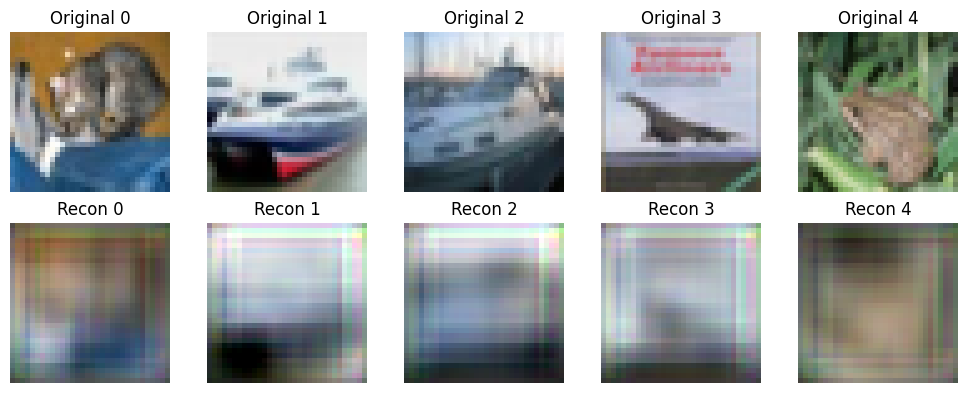

In [29]:
from PIL import Image
import matplotlib.pyplot as plt

# Số lượng cặp ảnh
num_samples = 5

plt.figure(figsize=(10, 4))

for i in range(num_samples):
    path = f"sample_{i}_original.pnm"
    img = Image.open(path)

    plt.subplot(2, num_samples, i + 1)   # hàng 1
    plt.imshow(img)
    plt.title(f"Original {i}")
    plt.axis("off")

for i in range(num_samples):
    path = f"sample_{i}_reconstructed.pnm"
    img = Image.open(path)

    plt.subplot(2, num_samples, num_samples + i + 1)   # hàng 2
    plt.imshow(img)
    plt.title(f"Recon {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()


## 4) GPU Optimization Version 2:

In [30]:
%%writefile gpu_layers_opt2.h
#pragma once
#include <cuda_runtime.h>
#include <stdio.h>

#define TILE_W 16
#define TILE_H 16
// Kích thước Kernel
#define K 3
#define R (K/2) // Radius = 1
#define BLOCK_W (TILE_W + 2 * R)
#define BLOCK_H (TILE_H + 2 * R)
__constant__ float dc_bias[256];


#define CHECK_CUDA(call)                                                \
    do {                                                                \
        cudaError_t err = call;                                         \
        if (err != cudaSuccess) {                                       \
            fprintf(stderr, "CUDA Error %s:%d: %s\n",                   \
                    __FILE__, __LINE__, cudaGetErrorString(err));       \
            exit(EXIT_FAILURE);                                         \
        }                                                               \
    } while (0)

// NCHW layout: [N, C, H, W]
__device__ __host__ inline int idx4(int n, int c, int h, int w,
                                    int C, int H, int W) {
    return ((n * C + c) * H + h) * W + w;
}

// ==== KERNEL DECLARATIONS ====
void update_dc_bias(float* d_bias_ptr, int count);
__global__ void conv2d_forward_opt2(
    float* __restrict__ input,    // [N, C_in, H, W]
    float* __restrict__ weight,   // [C_out, C_in, K, K]
    // float* bias,     // [C_out]
    float* __restrict__ output,   // [N, C_out, H_out, W_out]
    int N, int C_in, int H, int W,
    int C_out, int pad, int stride);

__global__ void relu_forward(float* x, int size);

__global__ void maxpool2x2_forward(
    float* __restrict__ input,  // [N, C, H, W]
    float* __restrict__ output,       // [N, C, H/2, W/2]
    int N, int C, int H, int W);

__global__ void upsample2x2_forward(
    float* __restrict__ input,  // [N, C, H, W]
    float* __restrict__ output,       // [N, C, 2H, 2W]
    int N, int C, int H, int W);

__global__ void mse_loss_forward(
    float* __restrict__ output,
    float* __restrict__ target,
    float* __restrict__ loss,   // single float on device
    int size);

__global__ void relu_backward(
    float* __restrict__ x,       // forward output/input to ReLU
    float* __restrict__ grad_y,  // dL/dy
    float* __restrict__ grad_x,        // dL/dx
    int size);

__global__ void maxpool2x2_backward(
    float* __restrict__ input,
    float* __restrict__ grad_out,
    float* __restrict__ grad_in,
    int N, int C, int H, int W);

__global__ void upsample2x2_backward(
    float* __restrict__ grad_out,
    float* __restrict__ grad_in,
    int N, int C, int H, int W);


__global__ void mse_loss_backward(
    float* __restrict__ output,
    float* __restrict__ target,
    float* __restrict__ grad_out,
    int size);

__global__ void conv2d_backward_input_opt2(
    float* __restrict__ dY,
    float* __restrict__ weight,
    float* __restrict__ dX,
    int N, int C_in, int H, int W,
    int C_out, int pad, int stride);

__global__ void conv2d_backward_weight_opt2(
    float* __restrict__ input,
    float* __restrict__ dY,
    float* __restrict__ dW,
    int N, int C_in, int H, int W,
    int C_out, int pad, int stride);

__global__ void conv2d_backward_bias_opt2(
    float* __restrict__ dY,
    float* __restrict__ dB,
    int N, int C_out, int H_out, int W_out);

__global__ void sgd_update(
    float* __restrict__ param,
    float* __restrict__ grad,
    int size,
    float lr);


Writing gpu_layers_opt2.h


In [31]:
%%writefile gpu_layers_opt2.cu

#include <cuda_runtime.h>
#include "gpu_layers_opt2.h"


// Optimal configurations
#define TILE_W 16
#define TILE_H 16
#define K 3

void update_dc_bias(float* d_bias_ptr, int count) {
    CHECK_CUDA(cudaMemcpyToSymbol(dc_bias, d_bias_ptr, count * sizeof(float),
                                   0, cudaMemcpyDeviceToDevice));
}


__global__ void conv2d_forward_opt2(
    float* __restrict__ input,    // [N, C_in, H, W]
    float* __restrict__ weight,   // [C_out, C_in, K, K]
    float* __restrict__ output,   // [N, C_out, H_out, W_out]
    int N, int C_in, int H, int W,
    int C_out, int pad, int stride)
{
    int H_out = (H + 2 * pad - K) / stride + 1;
    int W_out = (W + 2 * pad - K) / stride + 1;

    __shared__ float smem[BLOCK_H][BLOCK_W];

    int tx = threadIdx.x;
    int ty = threadIdx.y;
    int tid = ty * blockDim.x + tx;
    int num_threads = blockDim.x * blockDim.y;  // 256

    int w_out = blockIdx.x * TILE_W + tx;
    int h_out = blockIdx.y * TILE_H + ty;

    int nc = blockIdx.z;
    int c_out = nc % C_out;
    int n = nc / C_out;

    float value = 0.0f;

    // Base position for loading (với padding)
    int row_start = blockIdx.y * TILE_H * stride - pad;
    int col_start = blockIdx.x * TILE_W * stride - pad;

    // Loop over input channels
    for (int c_in = 0; c_in < C_in; c_in++) {
        // Cooperative loading
        // Total elements = 18x18 = 324
        // 256 threads → mỗi thread load 1-2 elements
        int total_elements = BLOCK_H * BLOCK_W;

        for (int idx = tid; idx < total_elements; idx += num_threads) {
            int i = idx / BLOCK_W;  // row
            int j = idx % BLOCK_W;  // col

            int h_in = row_start + i;
            int w_in = col_start + j;

            // Load with bounds checking
            if (h_in >= 0 && h_in < H && w_in >= 0 && w_in < W) {
                smem[i][j] = input[idx4(n, c_in, h_in, w_in, C_in, H, W)];
            } else {
                smem[i][j] = 0.0f;
            }
        }
        __syncthreads();

        // OPTIMIZED: Compute convolution with unrolling
        if (h_out < H_out && w_out < W_out && n < N) {
            int smem_row = ty * stride;
            int smem_col = tx * stride;

            #pragma unroll
            for (int i = 0; i < K; ++i) {
                #pragma unroll
                for (int j = 0; j < K; ++j) {
                    float in_val = smem[smem_row + i][smem_col + j];
                    float w_val = weight[idx4(c_out, c_in, i, j, C_in, K, K)];
                    value += in_val * w_val;
                }
            }
        }
        __syncthreads();
    }

    // Write output with bias from constant memory
    if (w_out < W_out && h_out < H_out && n < N) {
        value += dc_bias[c_out];
        output[idx4(n, c_out, h_out, w_out, C_out, H_out, W_out)] = value;
    }
}


__global__ void conv2d_backward_input_opt2(
    float* __restrict__ dY,     // [N, C_out, H, W]
    float* __restrict__ weight, // [C_out, C_in, K, K]
    float* __restrict__ dX,     // [N, C_in, H, W]
    int N, int C_in, int H, int W,
    int C_out, int pad, int stride)
{
    // Only support K=3, pad=1, stride=1
    if (stride != 1 || pad != 1 || K != 3) return;

    const int H_out = H;
    const int W_out = W;

    int tx = threadIdx.x;
    int ty = threadIdx.y;

    int base_h = blockIdx.y * TILE_H;
    int base_w = blockIdx.x * TILE_W;

    int h_in = base_h + ty;
    int w_in = base_w + tx;

    int nc = blockIdx.z;
    int c_in = nc % C_in;
    int n    = nc / C_in;

    if (n >= N || c_in >= C_in) return;

    // Shared memory for tile + halo
    __shared__ float s_dY[TILE_H + 2][TILE_W + 2];

    float value = 0.0f;

    for (int c_out = 0; c_out < C_out; ++c_out) {
        // ---- Load dY tile (n, c_out, :, :) into shared memory ----
        for (int sy = ty; sy < TILE_H + 2; sy += blockDim.y) {
            for (int sx = tx; sx < TILE_W + 2; sx += blockDim.x) {
                int ho = base_h + sy - 1;  // -pad
                int wo = base_w + sx - 1;  // -pad

                float v = 0.0f;
                if (ho >= 0 && ho < H_out && wo >= 0 && wo < W_out) {
                    v = dY[idx4(n, c_out, ho, wo, C_out, H_out, W_out)];
                }
                s_dY[sy][sx] = v;
            }
        }
        __syncthreads();

        // ---- Compute gradient for (n, c_in, h_in, w_in) ----
        if (h_in < H && w_in < W) {
            #pragma unroll
            for (int kh = 0; kh < K; ++kh) {
                #pragma unroll
                for (int kw = 0; kw < K; ++kw) {
                    // Shared memory indices
                    int sy = ty + 2 - kh;
                    int sx = tx + 2 - kw;

                    float dy = s_dY[sy][sx];

                    // CRITICAL FIX: Flip the kernel indices
                    int kh_flip = K - 1 - kh;  // 2, 1, 0
                    int kw_flip = K - 1 - kw;  // 2, 1, 0

                    // Weight layout [C_out, C_in, K, K]
                    float w = weight[idx4(c_out, c_in, kh_flip, kw_flip, C_in, K, K)];
                    value += dy * w;
                }
            }
        }

        __syncthreads();
    }

    if (h_in < H && w_in < W) {
        dX[idx4(n, c_in, h_in, w_in, C_in, H, W)] = value;
    }
}
// ============================================================================
// BACKWARD WEIGHT - FIXED
// Key fix: Block-level reduction BEFORE atomic
// ============================================================================
__global__ void conv2d_backward_weight_opt2(
    float* __restrict__ input,
    float* __restrict__ dY,
    float* __restrict__ dW,
    int N, int C_in, int H, int W,
    int C_out, int pad, int stride)
{
    int H_out = (H + 2 * pad - K) / stride + 1;
    int W_out = (W + 2 * pad - K) / stride + 1;

    __shared__ float s_in[BLOCK_H][BLOCK_W];
    __shared__ float s_dY[TILE_H][TILE_W];
    __shared__ float s_dw[K * K][256];  // Reduction buffer

    int tx = threadIdx.x;
    int ty = threadIdx.y;
    int tid = ty * blockDim.x + tx;
    int num_threads = blockDim.x * blockDim.y;

    int index = blockIdx.z;
    int c_in = index % C_in;
    int c_out = index / C_in;

    // Local accumulator
    float dw[K][K];
    #pragma unroll
    for (int i = 0; i < K; ++i)
        #pragma unroll
        for (int j = 0; j < K; ++j)
            dw[i][j] = 0.0f;

    for (int n = 0; n < N; ++n) {
        int num_blocks_h = (H_out + TILE_H - 1) / TILE_H;
        int num_blocks_w = (W_out + TILE_W - 1) / TILE_W;

        for (int block_h = 0; block_h < num_blocks_h; ++block_h) {
            for (int block_w = 0; block_w < num_blocks_w; ++block_w) {

                // Cooperative loading cho dY
                int h_out = block_h * TILE_H;
                int w_out = block_w * TILE_W;

                for (int idx = tid; idx < TILE_H * TILE_W; idx += num_threads) {
                    int i = idx / TILE_W;
                    int j = idx % TILE_W;
                    int h = h_out + i;
                    int w = w_out + j;

                    if (h < H_out && w < W_out) {
                        s_dY[i][j] = dY[idx4(n, c_out, h, w, C_out, H_out, W_out)];
                    } else {
                        s_dY[i][j] = 0.0f;
                    }
                }

                // Cooperative loading cho input với halo
                int h_in_base = block_h * TILE_H - pad;
                int w_in_base = block_w * TILE_W - pad;

                for (int idx = tid; idx < BLOCK_H * BLOCK_W; idx += num_threads) {
                    int i = idx / BLOCK_W;
                    int j = idx % BLOCK_W;
                    int h = h_in_base + i;
                    int w = w_in_base + j;

                    if (h >= 0 && h < H && w >= 0 && w < W) {
                        s_in[i][j] = input[idx4(n, c_in, h, w, C_in, H, W)];
                    } else {
                        s_in[i][j] = 0.0f;
                    }
                }
                __syncthreads();

                // Compute local dW
                if (ty < TILE_H && tx < TILE_W) {
                    float val_dy = s_dY[ty][tx];
                    #pragma unroll
                    for (int kh = 0; kh < K; ++kh) {
                        #pragma unroll
                        for (int kw = 0; kw < K; ++kw) {
                            dw[kh][kw] += s_in[ty * stride + kh][tx * stride + kw] * val_dy;
                        }
                    }
                }
                __syncthreads();
            }
        }
    }

    // Block-level reduction TRƯỚC atomic
    // Mỗi kernel element có reduction riêng
    #pragma unroll
    for (int kh = 0; kh < K; ++kh) {
        #pragma unroll
        for (int kw = 0; kw < K; ++kw) {
            int k_idx = kh * K + kw;

            // Store to shared memory
            s_dw[k_idx][tid] = dw[kh][kw];
            __syncthreads();

            // Tree reduction
            for (int s = num_threads / 2; s > 0; s >>= 1) {
                if (tid < s) {
                    s_dw[k_idx][tid] += s_dw[k_idx][tid + s];
                }
                __syncthreads();
            }

            // ONLY thread 0 does atomic
            if (tid == 0) {
                size_t dw_idx = idx4(c_out, c_in, kh, kw, C_in, K, K);
                atomicAdd(&dW[dw_idx], s_dw[k_idx][0]);
            }
        }
    }
}

// ============================================================================
// BACKWARD BIAS - OPTIMIZED (warp-level reduction)
// ============================================================================
__global__ void conv2d_backward_bias_opt2(
    float* __restrict__ dY,
    float* __restrict__ dB,
    int N, int C_out, int H_out, int W_out)
{
    int c = blockIdx.x;
    if (c >= C_out) return;

    int spatial_size = H_out * W_out;
    int channel_size = N * spatial_size;

    int tid = threadIdx.x;
    int lane = tid % 32;

    float sum = 0.0f;

    // Grid-stride loop
    for (int i = tid; i < channel_size; i += blockDim.x) {
        int n = i / spatial_size;
        int rem = i % spatial_size;
        int global_idx = n * (C_out * spatial_size) + c * spatial_size + rem;
        sum += dY[global_idx];
    }

    // Warp-level reduction
    #pragma unroll
    for (int offset = 16; offset > 0; offset >>= 1) {
        sum += __shfl_down_sync(0xffffffff, sum, offset);
    }

    // First thread in each warp writes to shared memory
    __shared__ float warp_sums[32];
    int warp_id = tid / 32;

    if (lane == 0) {
        warp_sums[warp_id] = sum;
    }
    __syncthreads();

    // Final reduction by first warp
    if (warp_id == 0) {
        sum = (lane < (blockDim.x / 32)) ? warp_sums[lane] : 0.0f;

        #pragma unroll
        for (int offset = 16; offset > 0; offset >>= 1) {
            sum += __shfl_down_sync(0xffffffff, sum, offset);
        }

        if (lane == 0) {
            dB[c] = sum;
        }
    }
}

// --------------- ReLU ------------------
__global__ void relu_forward(float* __restrict__ x, int size)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < size) {
        float v = x[i];
        x[i] = (v > 0.0f) ? v : 0.0f;
    }
}

// --------------- MaxPool 2x2 (stride 2) ------------------
__global__ void maxpool2x2_forward(
    float* __restrict__ input,
    float* __restrict__ output,
    int N, int C, int H, int W)
{
    int H_out = H / 2;
    int W_out = W / 2;

    int w_out = blockIdx.x * blockDim.x + threadIdx.x;
    int h_out = blockIdx.y * blockDim.y + threadIdx.y;
    int nc = blockIdx.z;

    if (w_out >= W_out || h_out >= H_out) return;

    int n = nc / C;
    int c = nc % C;
    if (n >= N) return;

    int h_in0 = h_out * 2;
    int w_in0 = w_out * 2;

    float m = -1e30f;
    for (int dh = 0; dh < 2; dh++) {
        for (int dw = 0; dw < 2; dw++) {
            int h_in = h_in0 + dh;
            int w_in = w_in0 + dw;
            int idx = idx4(n, c, h_in, w_in, C, H, W);
            float v = input[idx];
            if (v > m) m = v;
        }
    }

    int out_idx = idx4(n, c, h_out, w_out, C, H_out, W_out);
    output[out_idx] = m;
}

// --------------- UpSample 2x2 (nearest) ------------------
__global__ void upsample2x2_forward(
    float* __restrict__ input,
    float* __restrict__ output,
    int N, int C, int H, int W)
{
    int H_out = H * 2;
    int W_out = W * 2;

    int w_out = blockIdx.x * blockDim.x + threadIdx.x;
    int h_out = blockIdx.y * blockDim.y + threadIdx.y;
    int nc = blockIdx.z;

    if (w_out >= W_out || h_out >= H_out) return;

    int n = nc / C;
    int c = nc % C;
    if (n >= N) return;

    int h_in = h_out / 2;
    int w_in = w_out / 2;

    int idx_in = idx4(n, c, h_in, w_in, C, H, W);
    int idx_out = idx4(n, c, h_out, w_out, C, H_out, W_out);
    output[idx_out] = input[idx_in];
}

// --------------- MSE loss ------------------
__global__ void mse_loss_forward(
    float* __restrict__ output,
    float* __restrict__ target,
    float* __restrict__ loss,
    int size)
{
    extern __shared__ float sdata[];

    int tid = threadIdx.x;
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    float val = 0.0f;
    if (idx < size) {
        float diff = output[idx] - target[idx];
        val = diff * diff;
    }
    sdata[tid] = val;
    __syncthreads();

    // Parallel reduction
    for (int s = blockDim.x / 2; s > 0; s >>= 1) {
        if (tid < s) {
            sdata[tid] += sdata[tid + s];
        }
        __syncthreads();
    }

    if (tid == 0) {
        atomicAdd(loss, sdata[0]);
    }
}

// --------------- ReLU backward ------------------
__global__ void relu_backward(
    float* __restrict__ x,
    float* __restrict__ grad_y,
    float* __restrict__ grad_x,
    int size)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < size) {
        grad_x[i] = (x[i] > 0.0f) ? grad_y[i] : 0.0f;
    }
}

// --------------- MaxPool 2x2 backward ------------------
__global__ void maxpool2x2_backward(
    float* __restrict__ input,
    float* __restrict__ grad_out,
    float* __restrict__ grad_in,
    int N, int C, int H, int W)
{
    int H_out = H / 2;
    int W_out = W / 2;

    int w_out = blockIdx.x * blockDim.x + threadIdx.x;
    int h_out = blockIdx.y * blockDim.y + threadIdx.y;
    int nc = blockIdx.z;

    if (w_out >= W_out || h_out >= H_out) return;

    int n = nc / C;
    int c = nc % C;
    if (n >= N) return;

    int h_in0 = h_out * 2;
    int w_in0 = w_out * 2;

    int idx00 = idx4(n, c, h_in0 + 0, w_in0 + 0, C, H, W);
    int idx01 = idx4(n, c, h_in0 + 0, w_in0 + 1, C, H, W);
    int idx10 = idx4(n, c, h_in0 + 1, w_in0 + 0, C, H, W);
    int idx11 = idx4(n, c, h_in0 + 1, w_in0 + 1, C, H, W);

    float v00 = input[idx00];
    float v01 = input[idx01];
    float v10 = input[idx10];
    float v11 = input[idx11];

    float g = grad_out[idx4(n, c, h_out, w_out, C, H_out, W_out)];

    float m = v00;
    int max_idx = 0;
    if (v01 > m) { m = v01; max_idx = 1; }
    if (v10 > m) { m = v10; max_idx = 2; }
    if (v11 > m) { m = v11; max_idx = 3; }

    if (max_idx == 0) grad_in[idx00] = g;
    else if (max_idx == 1) grad_in[idx01] = g;
    else if (max_idx == 2) grad_in[idx10] = g;
    else grad_in[idx11] = g;
}

// --------------- UpSample 2x2 backward ------------------
__global__ void upsample2x2_backward(
    float* __restrict__ grad_out,
    float* __restrict__ grad_in,
    int N, int C, int H, int W)
{
    int H_out = H * 2;
    int W_out = W * 2;

    int w_in = blockIdx.x * blockDim.x + threadIdx.x;
    int h_in = blockIdx.y * blockDim.y + threadIdx.y;
    int nc = blockIdx.z;

    if (w_in >= W || h_in >= H) return;

    int n = nc / C;
    int c = nc % C;
    if (n >= N) return;

    int h_out0 = h_in * 2;
    int w_out0 = w_in * 2;

    float sum = 0.0f;
    for (int dh = 0; dh < 2; ++dh) {
        for (int dw = 0; dw < 2; ++dw) {
            int h_out = h_out0 + dh;
            int w_out = w_out0 + dw;
            int idx_o = idx4(n, c, h_out, w_out, C, H_out, W_out);
            sum += grad_out[idx_o];
        }
    }

    int idx_in = idx4(n, c, h_in, w_in, C, H, W);
    grad_in[idx_in] = sum;
}

// --------------- MSE loss backward ------------------
__global__ void mse_loss_backward(
    float* __restrict__ output,
    float* __restrict__ target,
    float* __restrict__ grad_out,
    int size)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i >= size) return;
    grad_out[i] = 2.0f * (output[i] - target[i]) / size;
}

// --------------- SGD update ------------------
__global__ void sgd_update(
    float* __restrict__ param,
    float* __restrict__ grad,
    int size,
    float lr)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < size) {
        param[i] -= lr * grad[i];
    }
}


Writing gpu_layers_opt2.cu


In [32]:
%%writefile gpu_autoencoder_opt2.h
// header for GPUAutoencoder (the struct + declarations)
#pragma once
#include "gpu_layers_opt2.h"
#include <cstdlib>
#include <cstdio>
#include <cmath>
#include <cuda_runtime.h>

// latent 128 x 8 x 8
static const int AE_LATENT_C   = 128;
static const int AE_LATENT_H   = 8;
static const int AE_LATENT_W   = 8;
static const int AE_LATENT_DIM = AE_LATENT_C * AE_LATENT_H * AE_LATENT_W;

// This autoencoder matches the project architecture exactly.
// Layout: NCHW [batch, channels, height, width]
struct GPUAutoencoder {
    int N;   // batch size
    int H;   // 32
    int W;   // 32;

    // --- Conv layer parameters ---
    // conv1: 3 -> 256 (3x3)
    float *d_w1, *d_b1;
    // conv2: 256 -> 128
    float *d_w2, *d_b2;
    // conv3: 128 -> 128
    float *d_w3, *d_b3;
    // conv4: 128 -> 256
    float *d_w4, *d_b4;
    // conv5: 256 -> 3
    float *d_w5, *d_b5;

    // --- Activations ---
    // Input batch
    float *d_x0;   // [N, 3, 32, 32]

    // Encoder
    float *d_h1;   // conv1 out: [N, 256, 32, 32]
    float *d_p1;   // pool1   : [N, 256, 16, 16]
    float *d_h2;   // conv2   : [N, 128, 16, 16]
    float *d_p2;   // pool2   : [N, 128,  8,  8]   (latent)

    // Decoder
    float *d_h3;   // conv3   : [N, 128,  8,  8]
    float *d_u1;   // up1     : [N, 128, 16, 16]
    float *d_h4;   // conv4   : [N, 256, 16, 16]
    float *d_u2;   // up2     : [N, 256, 32, 32]
    float *d_out;  // conv5   : [N,   3, 32, 32]

    // Loss buffer
    float *d_loss; // single float on device

    // ---- gradients for activations ----
    float *d_gx0; ///
    float *d_gh1;
    float *d_gp1;
    float *d_gh2;
    float *d_gp2;
    float *d_gh3;
    float *d_gu1;
    float *d_gh4;
    float *d_gu2;
    float *d_gout;

    // ---- gradients for weights, biases ----
    float *d_gw1, *d_gb1;
    float *d_gw2, *d_gb2;
    float *d_gw3, *d_gb3;
    float *d_gw4, *d_gb4;
    float *d_gw5, *d_gb5;
};

// API
void gpu_autoencoder_init(GPUAutoencoder *ae, int batch_size);
void gpu_autoencoder_free(GPUAutoencoder *ae);

void gpu_autoencoder_copy_weights_to_host(
    GPUAutoencoder *ae,
    float *h_w1, float *h_b1,
    float *h_w2, float *h_b2,
    float *h_w3, float *h_b3,
    float *h_w4, float *h_b4,
    float *h_w5, float *h_b5);

void gpu_autoencoder_copy_weights_to_device(
    GPUAutoencoder *ae,
    const float *h_w1, const float *h_b1,
    const float *h_w2, const float *h_b2,
    const float *h_w3, const float *h_b3,
    const float *h_w4, const float *h_b4,
    const float *h_w5, const float *h_b5);


// Forward on GPU:
//   h_input  : host pointer [N * 3 * 32 * 32]
//   h_output : host pointer [N * 3 * 32 * 32]
//   returns loss value (MSE(x_hat, x)) if compute_loss=true;
//   otherwise returns 0.0f.
float gpu_autoencoder_forward(
    GPUAutoencoder *ae,
    const float *h_input,
    float *h_output,
    bool compute_loss = true);

void gpu_autoencoder_backward(GPUAutoencoder *ae, float lr);

void gpu_autoencoder_save_weights(GPUAutoencoder *ae, const char *filename);

void gpu_autoencoder_load_weights(GPUAutoencoder *ae, const char *filename);

// encode only: lấy latent [N_batch, 128, 8, 8] -> h_latent [N_batch, AE_LATENT_DIM]
void gpu_autoencoder_encode_batch(
    GPUAutoencoder *ae,
    const float *h_input,
    float *h_latent,
    int N_batch);

Writing gpu_autoencoder_opt2.h


In [33]:
%%writefile gpu_autoencoder_opt2.cu
#include "gpu_autoencoder_opt2.h"
#include <cmath>

static inline float rand_uniform(float min_val, float max_val) {
    float r = (float)rand() / (float)RAND_MAX;
    return min_val + r * (max_val - min_val);
}

void gpu_autoencoder_init(GPUAutoencoder *ae, int batch_size) {
    ae->N = batch_size;
    ae->H = 32;
    ae->W = 32;

    const int N = ae->N;
    const int H = ae->H;
    const int W = ae->W;

    // ---------- allocate weights ----------

    int C_in1 = 3,   C_out1 = 256;
    int C_in2 = 256, C_out2 = 128;
    int C_in3 = 128, C_out3 = 128;
    int C_in4 = 128, C_out4 = 256;
    int C_in5 = 256, C_out5 = 3;

    size_t w1_bytes = C_out1 * C_in1 * K * K * sizeof(float);
    size_t b1_bytes = C_out1 * sizeof(float);
    size_t w2_bytes = C_out2 * C_in2 * K * K * sizeof(float);
    size_t b2_bytes = C_out2 * sizeof(float);
    size_t w3_bytes = C_out3 * C_in3 * K * K * sizeof(float);
    size_t b3_bytes = C_out3 * sizeof(float);
    size_t w4_bytes = C_out4 * C_in4 * K * K * sizeof(float);
    size_t b4_bytes = C_out4 * sizeof(float);
    size_t w5_bytes = C_out5 * C_in5 * K * K * sizeof(float);
    size_t b5_bytes = C_out5 * sizeof(float);

    CHECK_CUDA(cudaMalloc(&ae->d_w1, w1_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_b1, b1_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_w2, w2_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_b2, b2_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_w3, w3_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_b3, b3_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_w4, w4_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_b4, b4_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_w5, w5_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_b5, b5_bytes));

    // init weights on host
// find max weight bytes
size_t max_w_bytes = w1_bytes;
if (w2_bytes > max_w_bytes) max_w_bytes = w2_bytes;
if (w3_bytes > max_w_bytes) max_w_bytes = w3_bytes;
if (w4_bytes > max_w_bytes) max_w_bytes = w4_bytes;
if (w5_bytes > max_w_bytes) max_w_bytes = w5_bytes;

// find max bias bytes
size_t max_b_bytes = b1_bytes;
if (b2_bytes > max_b_bytes) max_b_bytes = b2_bytes;
if (b3_bytes > max_b_bytes) max_b_bytes = b3_bytes;
if (b4_bytes > max_b_bytes) max_b_bytes = b4_bytes;
if (b5_bytes > max_b_bytes) max_b_bytes = b5_bytes;

float *h_w = (float*)malloc(max_w_bytes);
float *h_b = (float*)malloc(max_b_bytes);


    auto init_wb = [&](float *d_w, size_t w_bytes, float *d_b, size_t b_bytes) {
        size_t w_cnt = w_bytes / sizeof(float);
        size_t b_cnt = b_bytes / sizeof(float);
        for (size_t i = 0; i < w_cnt; ++i) h_w[i] = rand_uniform(-0.05f, 0.05f);
        for (size_t i = 0; i < b_cnt; ++i) h_b[i] = rand_uniform(-0.05f, 0.05f);
        CHECK_CUDA(cudaMemcpy(d_w, h_w, w_bytes, cudaMemcpyHostToDevice));
        CHECK_CUDA(cudaMemcpy(d_b, h_b, b_bytes, cudaMemcpyHostToDevice));
    };

    init_wb(ae->d_w1, w1_bytes, ae->d_b1, b1_bytes);
    init_wb(ae->d_w2, w2_bytes, ae->d_b2, b2_bytes);
    init_wb(ae->d_w3, w3_bytes, ae->d_b3, b3_bytes);
    init_wb(ae->d_w4, w4_bytes, ae->d_b4, b4_bytes);
    init_wb(ae->d_w5, w5_bytes, ae->d_b5, b5_bytes);

    free(h_w);
    free(h_b);

    // ---------- allocate activations ---------- [batch_size, channels, height, width]
    size_t bytes_x0  = N * 3   * 32 * 32 * sizeof(float);
    size_t bytes_h1  = N * 256 * 32 * 32 * sizeof(float);
    size_t bytes_p1  = N * 256 * 16 * 16 * sizeof(float);
    size_t bytes_h2  = N * 128 * 16 * 16 * sizeof(float);
    size_t bytes_p2  = N * 128 *  8 *  8 * sizeof(float);
    size_t bytes_h3  = N * 128 *  8 *  8 * sizeof(float);
    size_t bytes_u1  = N * 128 * 16 * 16 * sizeof(float);
    size_t bytes_h4  = N * 256 * 16 * 16 * sizeof(float);
    size_t bytes_u2  = N * 256 * 32 * 32 * sizeof(float);
    size_t bytes_out = N * 3   * 32 * 32 * sizeof(float);

    CHECK_CUDA(cudaMalloc(&ae->d_x0,  bytes_x0));
    CHECK_CUDA(cudaMalloc(&ae->d_h1,  bytes_h1));
    CHECK_CUDA(cudaMalloc(&ae->d_p1,  bytes_p1));
    CHECK_CUDA(cudaMalloc(&ae->d_h2,  bytes_h2));
    CHECK_CUDA(cudaMalloc(&ae->d_p2,  bytes_p2));
    CHECK_CUDA(cudaMalloc(&ae->d_h3,  bytes_h3));
    CHECK_CUDA(cudaMalloc(&ae->d_u1,  bytes_u1));
    CHECK_CUDA(cudaMalloc(&ae->d_h4,  bytes_h4));
    CHECK_CUDA(cudaMalloc(&ae->d_u2,  bytes_u2));
    CHECK_CUDA(cudaMalloc(&ae->d_out, bytes_out));

    // loss buffer
    CHECK_CUDA(cudaMalloc(&ae->d_loss, sizeof(float)));

    // ---------- allocate activation gradients ----------
    CHECK_CUDA(cudaMalloc(&ae->d_gx0,  bytes_x0));
    CHECK_CUDA(cudaMalloc(&ae->d_gh1,  bytes_h1));
    CHECK_CUDA(cudaMalloc(&ae->d_gp1,  bytes_p1));
    CHECK_CUDA(cudaMalloc(&ae->d_gh2,  bytes_h2));
    CHECK_CUDA(cudaMalloc(&ae->d_gp2,  bytes_p2));
    CHECK_CUDA(cudaMalloc(&ae->d_gh3,  bytes_h3));
    CHECK_CUDA(cudaMalloc(&ae->d_gu1,  bytes_u1));
    CHECK_CUDA(cudaMalloc(&ae->d_gh4,  bytes_h4));
    CHECK_CUDA(cudaMalloc(&ae->d_gu2,  bytes_u2));
    CHECK_CUDA(cudaMalloc(&ae->d_gout, bytes_out));

    // ---------- allocate weight gradients ----------
    CHECK_CUDA(cudaMalloc(&ae->d_gw1, w1_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_gb1, b1_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_gw2, w2_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_gb2, b2_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_gw3, w3_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_gb3, b3_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_gw4, w4_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_gb4, b4_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_gw5, w5_bytes));
    CHECK_CUDA(cudaMalloc(&ae->d_gb5, b5_bytes));
}

void gpu_autoencoder_free(GPUAutoencoder *ae) {
    // weights
    cudaFree(ae->d_w1); cudaFree(ae->d_b1);
    cudaFree(ae->d_w2); cudaFree(ae->d_b2);
    cudaFree(ae->d_w3); cudaFree(ae->d_b3);
    cudaFree(ae->d_w4); cudaFree(ae->d_b4);
    cudaFree(ae->d_w5); cudaFree(ae->d_b5);

    // activations
    cudaFree(ae->d_x0);
    cudaFree(ae->d_h1);
    cudaFree(ae->d_p1);
    cudaFree(ae->d_h2);
    cudaFree(ae->d_p2);
    cudaFree(ae->d_h3);
    cudaFree(ae->d_u1);
    cudaFree(ae->d_h4);
    cudaFree(ae->d_u2);
    cudaFree(ae->d_out);

    cudaFree(ae->d_loss);

    // activation gradients
    cudaFree(ae->d_gx0);
    cudaFree(ae->d_gh1);
    cudaFree(ae->d_gp1);
    cudaFree(ae->d_gh2);
    cudaFree(ae->d_gp2);
    cudaFree(ae->d_gh3);
    cudaFree(ae->d_gu1);
    cudaFree(ae->d_gh4);
    cudaFree(ae->d_gu2);
    cudaFree(ae->d_gout);

    // weight gradients
    cudaFree(ae->d_gw1); cudaFree(ae->d_gb1);
    cudaFree(ae->d_gw2); cudaFree(ae->d_gb2);
    cudaFree(ae->d_gw3); cudaFree(ae->d_gb3);
    cudaFree(ae->d_gw4); cudaFree(ae->d_gb4);
    cudaFree(ae->d_gw5); cudaFree(ae->d_gb5);
}

void gpu_autoencoder_copy_weights_to_host(
    GPUAutoencoder *ae,
    float *h_w1, float *h_b1,
    float *h_w2, float *h_b2,
    float *h_w3, float *h_b3,
    float *h_w4, float *h_b4,
    float *h_w5, float *h_b5)
{
    int C_in1 = 3,   C_out1 = 256;
    int C_in2 = 256, C_out2 = 128;
    int C_in3 = 128, C_out3 = 128;
    int C_in4 = 128, C_out4 = 256;
    int C_in5 = 256, C_out5 = 3;

    size_t w1_bytes = C_out1 * C_in1 * K * K * sizeof(float);
    size_t b1_bytes = C_out1 * sizeof(float);
    size_t w2_bytes = C_out2 * C_in2 * K * K * sizeof(float);
    size_t b2_bytes = C_out2 * sizeof(float);
    size_t w3_bytes = C_out3 * C_in3 * K * K * sizeof(float);
    size_t b3_bytes = C_out3 * sizeof(float);
    size_t w4_bytes = C_out4 * C_in4 * K * K * sizeof(float);
    size_t b4_bytes = C_out4 * sizeof(float);
    size_t w5_bytes = C_out5 * C_in5 * K * K * sizeof(float);
    size_t b5_bytes = C_out5 * sizeof(float);

    CHECK_CUDA(cudaMemcpy(h_w1, ae->d_w1, w1_bytes, cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaMemcpy(h_b1, ae->d_b1, b1_bytes, cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaMemcpy(h_w2, ae->d_w2, w2_bytes, cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaMemcpy(h_b2, ae->d_b2, b2_bytes, cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaMemcpy(h_w3, ae->d_w3, w3_bytes, cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaMemcpy(h_b3, ae->d_b3, b3_bytes, cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaMemcpy(h_w4, ae->d_w4, w4_bytes, cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaMemcpy(h_b4, ae->d_b4, b4_bytes, cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaMemcpy(h_w5, ae->d_w5, w5_bytes, cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaMemcpy(h_b5, ae->d_b5, b5_bytes, cudaMemcpyDeviceToHost));
}

void gpu_autoencoder_copy_weights_to_device(
    GPUAutoencoder *ae,
    const float *h_w1, const float *h_b1,
    const float *h_w2, const float *h_b2,
    const float *h_w3, const float *h_b3,
    const float *h_w4, const float *h_b4,
    const float *h_w5, const float *h_b5)
{
    int C_in1 = 3,   C_out1 = 256;
    int C_in2 = 256, C_out2 = 128;
    int C_in3 = 128, C_out3 = 128;
    int C_in4 = 128, C_out4 = 256;
    int C_in5 = 256, C_out5 = 3;

    size_t w1_bytes = C_out1 * C_in1 * K * K * sizeof(float);
    size_t b1_bytes = C_out1 * sizeof(float);
    size_t w2_bytes = C_out2 * C_in2 * K * K * sizeof(float);
    size_t b2_bytes = C_out2 * sizeof(float);
    size_t w3_bytes = C_out3 * C_in3 * K * K * sizeof(float);
    size_t b3_bytes = C_out3 * sizeof(float);
    size_t w4_bytes = C_out4 * C_in4 * K * K * sizeof(float);
    size_t b4_bytes = C_out4 * sizeof(float);
    size_t w5_bytes = C_out5 * C_in5 * K * K * sizeof(float);
    size_t b5_bytes = C_out5 * sizeof(float);

    CHECK_CUDA(cudaMemcpy(ae->d_w1, h_w1, w1_bytes, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(ae->d_b1, h_b1, b1_bytes, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(ae->d_w2, h_w2, w2_bytes, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(ae->d_b2, h_b2, b2_bytes, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(ae->d_w3, h_w3, w3_bytes, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(ae->d_b3, h_b3, b3_bytes, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(ae->d_w4, h_w4, w4_bytes, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(ae->d_b4, h_b4, b4_bytes, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(ae->d_w5, h_w5, w5_bytes, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(ae->d_b5, h_b5, b5_bytes, cudaMemcpyHostToDevice));
}

float gpu_autoencoder_forward(
    GPUAutoencoder *ae,
    const float *h_input,
    float *h_output,
    bool compute_loss)
{
    const int N = ae->N;
    const int H = ae->H;
    const int W = ae->W;
    const int pad = 1;
    const int stride = 1;

    // Copy input to device
    size_t in_bytes = N * 3 * H * W * sizeof(float);
    CHECK_CUDA(cudaMemcpy(ae->d_x0, h_input, in_bytes, cudaMemcpyHostToDevice));

    dim3 block2d(16, 16);  // 256 threads per block

    // ========= ENCODER =========

    // Layer 1: conv1: 3 -> 256, 32x32
    {
        int C_in = 3, C_out = 256;
        int H_out = 32, W_out = 32;

        // Grid configuration cho optimized kernel
        dim3 gridConv(
            (W_out + TILE_W - 1) / TILE_W,  // Ceiling division
            (H_out + TILE_H - 1) / TILE_H,
            N * C_out);

        // Update constant memory bias
        update_dc_bias(ae->d_b1, C_out);

        // Launch optimized kernel
        conv2d_forward_opt2<<<gridConv, block2d>>>(
            ae->d_x0, ae->d_w1, ae->d_h1,
            N, C_in, H, W, C_out, pad, stride);

        // ReLU
        int size = N * C_out * H_out * W_out;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_forward<<<b, t>>>(ae->d_h1, size);

        // MaxPool 2x2 -> 16x16
        int Hp = 16, Wp = 16;
        dim3 gridPool(
            (Wp + block2d.x - 1) / block2d.x,
            (Hp + block2d.y - 1) / block2d.y,
            N * C_out);

        maxpool2x2_forward<<<gridPool, block2d>>>(
            ae->d_h1, ae->d_p1,
            N, C_out, H_out, W_out);
    }

    // Layer 2: conv2: 256 -> 128, 16x16, pool -> 8x8
    {
        int C_in = 256, C_out = 128;
        int H_in = 16, W_in = 16;
        int H_out = 16, W_out = 16;

        dim3 gridConv(
            (W_out + TILE_W - 1) / TILE_W,
            (H_out + TILE_H - 1) / TILE_H,
            N * C_out);

        update_dc_bias(ae->d_b2, C_out);
        conv2d_forward_opt2<<<gridConv, block2d>>>(
            ae->d_p1, ae->d_w2, ae->d_h2,
            N, C_in, H_in, W_in, C_out, pad, stride);

        int size = N * C_out * H_out * W_out;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_forward<<<b, t>>>(ae->d_h2, size);

        // Pool -> 8x8
        int Hp = 8, Wp = 8;
        dim3 gridPool(
            (Wp + block2d.x - 1) / block2d.x,
            (Hp + block2d.y - 1) / block2d.y,
            N * C_out);

        maxpool2x2_forward<<<gridPool, block2d>>>(
            ae->d_h2, ae->d_p2,
            N, C_out, H_out, W_out);
    }

    // LATENT: ae->d_p2: [N, 128, 8, 8]

    // ========= DECODER =========

    // Layer 3: conv3: 128 -> 128, 8x8
    {
        int C_in = 128, C_out = 128;
        int H_in = 8, W_in = 8;
        int H_out = 8, W_out = 8;

        dim3 gridConv(
            (W_out + TILE_W - 1) / TILE_W,
            (H_out + TILE_H - 1) / TILE_H,
            N * C_out);

        update_dc_bias(ae->d_b3, C_out);
        conv2d_forward_opt2<<<gridConv, block2d>>>(
            ae->d_p2, ae->d_w3, ae->d_h3,
            N, C_in, H_in, W_in, C_out, pad, stride);

        int size = N * C_out * H_out * W_out;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_forward<<<b, t>>>(ae->d_h3, size);

        // Upsample 8x8 -> 16x16
        int Hu = 16, Wu = 16;
        dim3 gridUp(
            (Wu + block2d.x - 1) / block2d.x,
            (Hu + block2d.y - 1) / block2d.y,
            N * C_out);

        upsample2x2_forward<<<gridUp, block2d>>>(
            ae->d_h3, ae->d_u1,
            N, C_out, H_in, W_in);
    }

    // Layer 4: conv4: 128 -> 256, 16x16, upsample 16->32
    {
        int C_in = 128, C_out = 256;
        int H_in = 16, W_in = 16;
        int H_out = 16, W_out = 16;

        dim3 gridConv(
            (W_out + TILE_W - 1) / TILE_W,
            (H_out + TILE_H - 1) / TILE_H,
            N * C_out);

        update_dc_bias(ae->d_b4, C_out);
        conv2d_forward_opt2<<<gridConv, block2d>>>(
            ae->d_u1, ae->d_w4, ae->d_h4,
            N, C_in, H_in, W_in, C_out, pad, stride);

        int size = N * C_out * H_out * W_out;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_forward<<<b, t>>>(ae->d_h4, size);

        // Upsample 16x16 -> 32x32
        int Hu = 32, Wu = 32;
        dim3 gridUp(
            (Wu + block2d.x - 1) / block2d.x,
            (Hu + block2d.y - 1) / block2d.y,
            N * C_out);

        upsample2x2_forward<<<gridUp, block2d>>>(
            ae->d_h4, ae->d_u2,
            N, C_out, H_in, W_in);
    }

    // Layer 5: conv5: 256 -> 3, 32x32 (output layer)
    {
        int C_in = 256, C_out = 3;
        int H_in = 32, W_in = 32;
        int H_out = 32, W_out = 32;

        dim3 gridConv(
            (W_out + TILE_W - 1) / TILE_W,
            (H_out + TILE_H - 1) / TILE_H,
            N * C_out);

        update_dc_bias(ae->d_b5, C_out);
        conv2d_forward_opt2<<<gridConv, block2d>>>(
            ae->d_u2, ae->d_w5, ae->d_out,
            N, C_in, H_in, W_in, C_out, pad, stride);
    }

    // ========= COMPUTE LOSS (optional) =========
    float loss_value = 0.0f;
    if (compute_loss) {
        int size = N * 3 * 32 * 32;
        CHECK_CUDA(cudaMemset(ae->d_loss, 0, sizeof(float)));

        int t = 256;
        int b = (size + t - 1) / t;
        size_t shmem_bytes = t * sizeof(float);

        mse_loss_forward<<<b, t, shmem_bytes>>>(
            ae->d_out, ae->d_x0, ae->d_loss, size);

        float loss_sum = 0.0f;
        CHECK_CUDA(cudaMemcpy(&loss_sum, ae->d_loss,
                              sizeof(float),
                              cudaMemcpyDeviceToHost));

        loss_value = loss_sum / size;
    }

    // Copy output back to host
    size_t out_bytes = N * 3 * 32 * 32 * sizeof(float);
    CHECK_CUDA(cudaMemcpy(h_output, ae->d_out,
                          out_bytes,
                          cudaMemcpyDeviceToHost));

    return loss_value;
}

void gpu_autoencoder_backward(GPUAutoencoder *ae, float lr)
{
    const int N = ae->N;
    const int H0 = ae->H;
    const int W0 = ae->W;
    const int pad = 1;
    const int stride = 1;

    // Zero gradients asynchronously in streams
    CHECK_CUDA(cudaMemset(ae->d_gw1, 0, 256 * 3 * K * K * sizeof(float)));
    CHECK_CUDA(cudaMemset(ae->d_gb1, 0, 256 * sizeof(float)));
    CHECK_CUDA(cudaMemset(ae->d_gw2, 0, 128 * 256 * K * K * sizeof(float)));
    CHECK_CUDA(cudaMemset(ae->d_gb2, 0, 128 * sizeof(float)));
    CHECK_CUDA(cudaMemset(ae->d_gw3, 0, 128 * 128 * K * K * sizeof(float)));
    CHECK_CUDA(cudaMemset(ae->d_gb3, 0, 128 * sizeof(float)));
    CHECK_CUDA(cudaMemset(ae->d_gw4, 0, 256 * 128 * K * K * sizeof(float)));
    CHECK_CUDA(cudaMemset(ae->d_gb4, 0, 256 * sizeof(float)));
    CHECK_CUDA(cudaMemset(ae->d_gw5, 0, 3 * 256 * K * K * sizeof(float)));
    CHECK_CUDA(cudaMemset(ae->d_gb5, 0, 3 * sizeof(float)));

    dim3 block2d(16, 16);

    // ===== 1. dL/dout (MSE) =====
    int size_out = N * 3 * 32 * 32;
    {
        int t = 256;
        int b = (size_out + t - 1) / t;
        mse_loss_backward<<<b, t>>>(
            ae->d_out, ae->d_x0, ae->d_gout, size_out);
    }

    // ===== 2. Backward conv5: 256->3, 32x32 =====
    {
        int C_in = 256, C_out = 3;
        int H = 32, W = 32;

        // dU2
        dim3 gridIn(
            (W + TILE_W - 1) / TILE_W,  // Use TILE_W instead of block2d.x
            (H + TILE_H - 1) / TILE_H,
            N * C_in);

        conv2d_backward_input_opt2<<<gridIn, block2d>>>(
            ae->d_gout, ae->d_w5, ae->d_gu2,
            N, C_in, H, W, C_out, pad, stride);

        // dW5
        dim3 gridW(1, 1, C_out * C_in);
        conv2d_backward_weight_opt2<<<gridW, block2d>>>(
            ae->d_u2, ae->d_gout, ae->d_gw5,
            N, C_in, H, W, C_out, pad, stride);

        // dB5
        dim3 gridB(C_out);
        dim3 blockB(256);
        conv2d_backward_bias_opt2<<<gridB, blockB>>>(
            ae->d_gout, ae->d_gb5, N, C_out, H, W);

        // SGD update
        int num_w = C_out * C_in * K * K;
        int t = 256;
        int bw = (num_w + t - 1) / t;
        sgd_update<<<bw, t>>>(ae->d_w5, ae->d_gw5, num_w, lr);

        int bbp = (C_out + t - 1) / t;
        sgd_update<<<bbp, t>>>(ae->d_b5, ae->d_gb5, C_out, lr);
    }

    // ===== 3. UpSample2x2 backward =====
    {
        int C = 256;
        int H = 16, W = 16;
        int Hu = 32, Wu = 32;

        dim3 grid(
            (W + block2d.x - 1) / block2d.x,
            (H + block2d.y - 1) / block2d.y,
            N * C);

        upsample2x2_backward<<<grid, block2d>>>(
            ae->d_gu2, ae->d_gh4, N, C, H, W);
    }

    // ===== 4. ReLU backward h4 =====
    {
        int C = 256, H = 16, W = 16;
        int size = N * C * H * W;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_backward<<<b, t>>>(
            ae->d_h4, ae->d_gh4, ae->d_gh4, size);
    }

    // ===== 5. conv4 backward: 128->256, 16x16 =====
    {
        int C_in = 128, C_out = 256;
        int H = 16, W = 16;

        dim3 gridIn(
            (W + TILE_W - 1) / TILE_W,
            (H + TILE_H - 1) / TILE_H,
            N * C_in);

        conv2d_backward_input_opt2<<<gridIn, block2d>>>(
            ae->d_gh4, ae->d_w4, ae->d_gu1,
            N, C_in, H, W, C_out, pad, stride);


        dim3 gridW(1, 1, C_out * C_in);
        conv2d_backward_weight_opt2<<<gridW, block2d>>>(
            ae->d_u1, ae->d_gh4, ae->d_gw4,
            N, C_in, H, W, C_out, pad, stride);


        dim3 gridB(C_out);
        dim3 blockB(256);
        conv2d_backward_bias_opt2<<<gridB, blockB>>>(
            ae->d_gh4, ae->d_gb4, N, C_out, H, W);

        // SGD
        int num_w = C_out * C_in * K * K;
        int t = 256;
        int bw = (num_w + t - 1) / t;
        sgd_update<<<bw, t>>>(ae->d_w4, ae->d_gw4, num_w, lr);

        int bbp = (C_out + t - 1) / t;
        sgd_update<<<bbp, t>>>(ae->d_b4, ae->d_gb4, C_out, lr);
    }

    // ===== 6. UpSample2x2 backward =====
    {
        int C = 128;
        int H = 8, W = 8;
        int Hu = 16, Wu = 16;

        dim3 grid(
            (W + block2d.x - 1) / block2d.x,
            (H + block2d.y - 1) / block2d.y,
            N * C);

        upsample2x2_backward<<<grid, block2d>>>(
            ae->d_gu1, ae->d_gh3, N, C, H, W);
    }

    // ===== 7. ReLU backward h3 =====
    {
        int C = 128, H = 8, W = 8;
        int size = N * C * H * W;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_backward<<<b, t>>>(
            ae->d_h3, ae->d_gh3, ae->d_gh3, size);
    }

    // ===== 8. conv3 backward: 128->128, 8x8 =====
    {
        int C_in = 128, C_out = 128;
        int H = 8, W = 8;


        dim3 gridIn(
            (W + TILE_W - 1) / TILE_W,
            (H + TILE_H - 1) / TILE_H,
            N * C_in);

        conv2d_backward_input_opt2<<<gridIn, block2d>>>(
            ae->d_gh3, ae->d_w3, ae->d_gp2,
            N, C_in, H, W, C_out, pad, stride);

        dim3 gridW(1, 1, C_out * C_in);
        conv2d_backward_weight_opt2<<<gridW, block2d>>>(
            ae->d_p2, ae->d_gh3, ae->d_gw3,
            N, C_in, H, W, C_out, pad, stride);

        dim3 gridB(C_out);
        dim3 blockB(256);
        conv2d_backward_bias_opt2<<<gridB, blockB>>>(
            ae->d_gh3, ae->d_gb3, N, C_out, H, W);

        // SGD
        int num_w = C_out * C_in * K * K;
        int t = 256;
        int bw = (num_w + t - 1) / t;
        sgd_update<<<bw, t>>>(ae->d_w3, ae->d_gw3, num_w, lr);

        int bbp = (C_out + t - 1) / t;
        sgd_update<<<bbp, t>>>(ae->d_b3, ae->d_gb3, C_out, lr);
    }

    // ===== 9. MaxPool2x2 backward =====
    {
        int C = 128;
        int H = 16, W = 16;
        CHECK_CUDA(cudaMemset(ae->d_gh2, 0, N * C * H * W * sizeof(float)));

        dim3 grid(
            (W/2 + block2d.x - 1) / block2d.x,
            (H/2 + block2d.y - 1) / block2d.y,
            N * C);

        maxpool2x2_backward<<<grid, block2d>>>(
            ae->d_h2, ae->d_gp2, ae->d_gh2, N, C, H, W);
    }

    // ===== 10. ReLU backward h2 =====
    {
        int C = 128, H = 16, W = 16;
        int size = N * C * H * W;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_backward<<<b, t>>>(
            ae->d_h2, ae->d_gh2, ae->d_gh2, size);
    }

    // ===== 11. conv2 backward: 256->128, 16x16 =====
    {
        int C_in = 256, C_out = 128;
        int H = 16, W = 16;
        dim3 gridIn(
            (W + TILE_W - 1) / TILE_W,
            (H + TILE_H - 1) / TILE_H,
            N * C_in);

        conv2d_backward_input_opt2<<<gridIn, block2d>>>(
            ae->d_gh2, ae->d_w2, ae->d_gp1,
            N, C_in, H, W, C_out, pad, stride);
        dim3 gridW(1, 1, C_out * C_in);
        conv2d_backward_weight_opt2<<<gridW, block2d>>>(
            ae->d_p1, ae->d_gh2, ae->d_gw2,
            N, C_in, H, W, C_out, pad, stride);

        dim3 gridB(C_out);
        dim3 blockB(256);
        conv2d_backward_bias_opt2<<<gridB, blockB>>>(
            ae->d_gh2, ae->d_gb2, N, C_out, H, W);

        // SGD
        int num_w = C_out * C_in * K * K;
        int t = 256;
        int bw = (num_w + t - 1) / t;
        sgd_update<<<bw, t>>>(ae->d_w2, ae->d_gw2, num_w, lr);

        int bbp = (C_out + t - 1) / t;
        sgd_update<<<bbp, t>>>(ae->d_b2, ae->d_gb2, C_out, lr);
    }

    // ===== 12. MaxPool2x2 backward =====
    {
        int C = 256;
        int H = 32, W = 32;
        CHECK_CUDA(cudaMemset(ae->d_gh1, 0, N * C * H * W * sizeof(float)));

        dim3 grid(
            (W/2 + block2d.x - 1) / block2d.x,
            (H/2 + block2d.y - 1) / block2d.y,
            N * C);

        maxpool2x2_backward<<<grid, block2d>>>(
            ae->d_h1, ae->d_gp1, ae->d_gh1, N, C, H, W);
    }

    // ===== 13. ReLU backward h1 =====
    {
        int C = 256, H = 32, W = 32;
        int size = N * C * H * W;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_backward<<<b, t>>>(
            ae->d_h1, ae->d_gh1, ae->d_gh1, size);
    }

    // ===== 14. conv1 backward: 3->256, 32x32 =====
    {
        int C_in = 3, C_out = 256;
        int H = 32, W = 32;

        // OPTIMIZED
        dim3 gridIn(
            (W + TILE_W - 1) / TILE_W,
            (H + TILE_H - 1) / TILE_H,
            N * C_in);

        conv2d_backward_input_opt2<<<gridIn, block2d>>>(
            ae->d_gh1, ae->d_w1, ae->d_gx0,
            N, C_in, H, W, C_out, pad, stride);

        // OPTIMIZED
        dim3 gridW(1, 1, C_out * C_in);
        conv2d_backward_weight_opt2<<<gridW, block2d>>>(
            ae->d_x0, ae->d_gh1, ae->d_gw1,
            N, C_in, H, W, C_out, pad, stride);

        // OPTIMIZED
        dim3 gridB(C_out);
        dim3 blockB(256);
        conv2d_backward_bias_opt2<<<gridB, blockB>>>(
            ae->d_gh1, ae->d_gb1, N, C_out, H, W);

        // SGD
        int num_w = C_out * C_in * K * K;
        int t = 256;
        int bw = (num_w + t - 1) / t;
        sgd_update<<<bw, t>>>(ae->d_w1, ae->d_gw1, num_w, lr);

        int bbp = (C_out + t - 1) / t;
        sgd_update<<<bbp, t>>>(ae->d_b1, ae->d_gb1, C_out, lr);
    }
}

void gpu_autoencoder_save_weights(GPUAutoencoder *ae, const char *filename)
{
    int C_in1 = 3,   C_out1 = 256;
    int C_in2 = 256, C_out2 = 128;
    int C_in3 = 128, C_out3 = 128;
    int C_in4 = 128, C_out4 = 256;
    int C_in5 = 256, C_out5 = 3;

    size_t w1_cnt = C_out1 * C_in1 * K * K;
    size_t b1_cnt = C_out1;
    size_t w2_cnt = C_out2 * C_in2 * K * K;
    size_t b2_cnt = C_out2;
    size_t w3_cnt = C_out3 * C_in3 * K * K;
    size_t b3_cnt = C_out3;
    size_t w4_cnt = C_out4 * C_in4 * K * K;
    size_t b4_cnt = C_out4;
    size_t w5_cnt = C_out5 * C_in5 * K * K;
    size_t b5_cnt = C_out5;

    float *h_w1 = (float*)malloc(w1_cnt * sizeof(float));
    float *h_b1 = (float*)malloc(b1_cnt * sizeof(float));
    float *h_w2 = (float*)malloc(w2_cnt * sizeof(float));
    float *h_b2 = (float*)malloc(b2_cnt * sizeof(float));
    float *h_w3 = (float*)malloc(w3_cnt * sizeof(float));
    float *h_b3 = (float*)malloc(b3_cnt * sizeof(float));
    float *h_w4 = (float*)malloc(w4_cnt * sizeof(float));
    float *h_b4 = (float*)malloc(b4_cnt * sizeof(float));
    float *h_w5 = (float*)malloc(w5_cnt * sizeof(float));
    float *h_b5 = (float*)malloc(b5_cnt * sizeof(float));

    gpu_autoencoder_copy_weights_to_host(
        ae,
        h_w1, h_b1,
        h_w2, h_b2,
        h_w3, h_b3,
        h_w4, h_b4,
        h_w5, h_b5);

    FILE *f = fopen(filename, "wb");
    if (!f) {
        fprintf(stderr, "Cannot open %s for writing\n", filename);
    } else {
        fwrite(h_w1, sizeof(float), w1_cnt, f);
        fwrite(h_b1, sizeof(float), b1_cnt, f);
        fwrite(h_w2, sizeof(float), w2_cnt, f);
        fwrite(h_b2, sizeof(float), b2_cnt, f);
        fwrite(h_w3, sizeof(float), w3_cnt, f);
        fwrite(h_b3, sizeof(float), b3_cnt, f);
        fwrite(h_w4, sizeof(float), w4_cnt, f);
        fwrite(h_b4, sizeof(float), b4_cnt, f);
        fwrite(h_w5, sizeof(float), w5_cnt, f);
        fwrite(h_b5, sizeof(float), b5_cnt, f);
        fclose(f);
        printf("Saved weights to %s\n", filename);
    }

    free(h_w1); free(h_b1);
    free(h_w2); free(h_b2);
    free(h_w3); free(h_b3);
    free(h_w4); free(h_b4);
    free(h_w5); free(h_b5);
}

void gpu_autoencoder_load_weights(GPUAutoencoder *ae, const char *filename)
{
    int C_in1 = 3,   C_out1 = 256;
    int C_in2 = 256, C_out2 = 128;
    int C_in3 = 128, C_out3 = 128;
    int C_in4 = 128, C_out4 = 256;
    int C_in5 = 256, C_out5 = 3;

    size_t w1_cnt = C_out1 * C_in1 * K * K;
    size_t b1_cnt = C_out1;
    size_t w2_cnt = C_out2 * C_in2 * K * K;
    size_t b2_cnt = C_out2;
    size_t w3_cnt = C_out3 * C_in3 * K * K;
    size_t b3_cnt = C_out3;
    size_t w4_cnt = C_out4 * C_in4 * K * K;
    size_t b4_cnt = C_out4;
    size_t w5_cnt = C_out5 * C_in5 * K * K;
    size_t b5_cnt = C_out5;

    float *h_w1 = (float*)malloc(w1_cnt * sizeof(float));
    float *h_b1 = (float*)malloc(b1_cnt * sizeof(float));
    float *h_w2 = (float*)malloc(w2_cnt * sizeof(float));
    float *h_b2 = (float*)malloc(b2_cnt * sizeof(float));
    float *h_w3 = (float*)malloc(w3_cnt * sizeof(float));
    float *h_b3 = (float*)malloc(b3_cnt * sizeof(float));
    float *h_w4 = (float*)malloc(w4_cnt * sizeof(float));
    float *h_b4 = (float*)malloc(b4_cnt * sizeof(float));
    float *h_w5 = (float*)malloc(w5_cnt * sizeof(float));
    float *h_b5 = (float*)malloc(b5_cnt * sizeof(float));

    FILE *f = fopen(filename, "rb");
    if (!f) {
        fprintf(stderr, "Cannot open %s for reading\n", filename);
        exit(1);
    }

    size_t r1 = fread(h_w1, sizeof(float), w1_cnt, f);
    size_t r2 = fread(h_b1, sizeof(float), b1_cnt, f);
    size_t r3 = fread(h_w2, sizeof(float), w2_cnt, f);
    size_t r4 = fread(h_b2, sizeof(float), b2_cnt, f);
    size_t r5 = fread(h_w3, sizeof(float), w3_cnt, f);
    size_t r6 = fread(h_b3, sizeof(float), b3_cnt, f);
    size_t r7 = fread(h_w4, sizeof(float), w4_cnt, f);
    size_t r8 = fread(h_b4, sizeof(float), b4_cnt, f);
    size_t r9 = fread(h_w5, sizeof(float), w5_cnt, f);
    size_t r10 = fread(h_b5, sizeof(float), b5_cnt, f);
    fclose(f);

    if (r1 != w1_cnt || r2 != b1_cnt ||
        r3 != w2_cnt || r4 != b2_cnt ||
        r5 != w3_cnt || r6 != b3_cnt ||
        r7 != w4_cnt || r8 != b4_cnt ||
        r9 != w5_cnt || r10 != b5_cnt)
    {
        fprintf(stderr, "Error reading weights from %s\n", filename);
        exit(1);
    }

    gpu_autoencoder_copy_weights_to_device(
        ae,
        h_w1, h_b1,
        h_w2, h_b2,
        h_w3, h_b3,
        h_w4, h_b4,
        h_w5, h_b5
    );

    free(h_w1); free(h_b1);
    free(h_w2); free(h_b2);
    free(h_w3); free(h_b3);
    free(h_w4); free(h_b4);
    free(h_w5); free(h_b5);

    printf("Loaded weights from %s\n", filename);
}

void gpu_autoencoder_encode_batch(
    GPUAutoencoder *ae,
    const float *h_input,
    float *h_latent,
    int N_batch)
{
    const int H = ae->H;    // 32
    const int W = ae->W;    // 32
    const int pad = 1;
    const int stride = 1;

    // copy input [N_batch, 3, 32, 32] lên GPU
    size_t in_bytes = (size_t)N_batch * 3 * H * W * sizeof(float);
    CHECK_CUDA(cudaMemcpy(ae->d_x0, h_input, in_bytes, cudaMemcpyHostToDevice));

    dim3 block2d(16, 16);

    // ===== ENCODER =====
    // conv1: 3 -> 256, 32x32 -> h1, rồi ReLU + MaxPool -> p1 (16x16)
    {
        int C_in = 3, C_out = 256;
        int H_out = 32, W_out = 32;

        dim3 gridConv(
            (W_out + block2d.x - 1) / block2d.x,
            (H_out + block2d.y - 1) / block2d.y,
            N_batch * C_out);

        // copy bias to constant memory
        //CHECK_CUDA(cudaMemcpyToSymbol(dc_bias, ae->d_b1, 256 * sizeof(float)));
        update_dc_bias(ae->d_b1, C_out);
        conv2d_forward_opt2<<<gridConv, block2d>>>(
            ae->d_x0, ae->d_w1, ae->d_h1,
            N_batch, C_in, H, W, C_out, pad, stride);

        int size = N_batch * C_out * H_out * W_out;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_forward<<<b, t>>>(ae->d_h1, size);

        int Hp = 16, Wp = 16;
        dim3 gridPool(
            (Wp + block2d.x - 1) / block2d.x,
            (Hp + block2d.y - 1) / block2d.y,
            N_batch * C_out);

        maxpool2x2_forward<<<gridPool, block2d>>>(
            ae->d_h1, ae->d_p1,
            N_batch, C_out, H_out, W_out);
    }

    // conv2: 256 -> 128, 16x16 -> h2, rồi ReLU + MaxPool -> p2 (8x8)
    {
        int C_in = 256, C_out = 128;
        int H_in = 16, W_in = 16;
        int H_out = 16, W_out = 16;

        dim3 gridConv(
            (W_out + block2d.x - 1) / block2d.x,
            (H_out + block2d.y - 1) / block2d.y,
            N_batch * C_out
        );

        // copy bias to constant memory
        //CHECK_CUDA(cudaMemcpyToSymbol(dc_bias, ae->d_b2, 128 * sizeof(float)));
        update_dc_bias(ae->d_b2, C_out);
        conv2d_forward_opt2<<<gridConv, block2d>>>(
            ae->d_p1, ae->d_w2, ae->d_h2,
            N_batch, C_in, H_in, W_in, C_out, pad, stride);

        int size = N_batch * C_out * H_out * W_out;
        int t = 256;
        int b = (size + t - 1) / t;
        relu_forward<<<b, t>>>(ae->d_h2, size);

        int Hp = 8, Wp = 8;
        dim3 gridPool(
            (Wp + block2d.x - 1) / block2d.x,
            (Hp + block2d.y - 1) / block2d.y,
            N_batch * C_out);

        maxpool2x2_forward<<<gridPool, block2d>>>(
            ae->d_h2, ae->d_p2,
            N_batch, C_out, H_out, W_out);

         cudaError_t err = cudaGetLastError();
   if (err != cudaSuccess) {
       fprintf(stderr, "Kernel launch error: %s\n", cudaGetErrorString(err));
   }
   cudaDeviceSynchronize();
    }
    cudaDeviceSynchronize();

size_t latent_bytes = (size_t)N_batch * 128 * 8 * 8 * sizeof(float);
CHECK_CUDA(cudaMemcpy(h_latent, ae->d_p2, latent_bytes, cudaMemcpyDeviceToHost));

}

Writing gpu_autoencoder_opt2.cu


In [34]:
%%writefile reconstruction_gpu_opt2.cu
#include "load_data.h"
#include "gpu_autoencoder_opt2.h"
#include <stdint.h>

uint8_t float_to_pixel(float val) {
    if (val < 0.0f) val = 0.0f;
    if (val > 1.0f) val = 1.0f;
    return (uint8_t)(val * 255.0f);
}

void save_image_pnm(const char* filename, float* planar_data, int width, int height) {
    FILE* f = fopen(filename, "wb");
    if (!f) {
        printf("Error opening file %s for writing\n", filename);
        return;
    }

    // Header PNM: P6 format (binary)
    fprintf(f, "P6\n%d %d\n255\n", width, height);

    int plane_size = width * height;
    uint8_t* pixel_buffer = (uint8_t*)malloc(width * height * 3 * sizeof(uint8_t));
    if (!pixel_buffer) {
        printf("Error allocating pixel buffer\n");
        fclose(f);
        return;
    }

    // Convert float data to uint8_t and interleave RGB channels
    for (int h = 0; h < height; h++) {
        for (int w = 0; w < width; w++) {
            int pixel_idx = (h * width + w) * 3;
            int data_idx = h * width + w;

            pixel_buffer[pixel_idx] = float_to_pixel(planar_data[data_idx]);
            pixel_buffer[pixel_idx + 1] = float_to_pixel(planar_data[plane_size + data_idx]);
            pixel_buffer[pixel_idx + 2] = float_to_pixel(planar_data[2 * plane_size + data_idx]);
        }
    }

    // Write all pixel data at once
    fwrite(pixel_buffer, 1, width * height * 3, f);
    fclose(f);
    free(pixel_buffer);
}

void sample_reconstructions(GPUAutoencoder* ae, Cifar10* data,
                            int num_samples) {
    printf("\n*** Sampling Reconstructed Images ***\n");

    const int batch_size = ae->N;        // batch size lưu trong struct
    const int H = ae->H;                 // 32
    const int W = ae->W;                 // 32
    const int img_size = 3 * H * W;      // 3*32*32

    // Đảm bảo không lấy nhiều hơn batch
    if (num_samples > batch_size) {
        num_samples = batch_size;
    }

    // Cấp phát buffer host cho 1 batch input / output
    float* h_input  =
        (float*)malloc(batch_size * img_size * sizeof(float));
    float* h_output =
        (float*)malloc(batch_size * img_size * sizeof(float));

    if (!h_input || !h_output) {
        printf("Error allocating host buffers for batch\n");
        free(h_input);
        free(h_output);
        return;
    }

    // Ở đây mình đơn giản lấy batch đầu tiên của test set
    // data->test_images được giả định là [N_test, 3, 32, 32] NCHW planar
    memcpy(h_input,
           data->test_images,
           batch_size * img_size * sizeof(float));

    // Forward: copy h_input -> GPU, chạy autoencoder, copy d_out -> h_output
    // Không cần loss, nên compute_loss = false cho nhẹ
    gpu_autoencoder_forward(ae, h_input, h_output, false);

    char filename[64];

    for (int i = 0; i < num_samples; i++) {
        // Save original
        snprintf(filename, sizeof(filename),
                 "sample_%d_original.pnm", i);
        save_image_pnm(filename,
                       h_input + i * img_size,
                       W, H);

        // Save reconstructed
        snprintf(filename, sizeof(filename),
                 "sample_%d_reconstructed.pnm", i);
        save_image_pnm(filename,
                       h_output + i * img_size,
                       W, H);

        printf("Saved pair %d: %s vs %s\n",
               i, "original", "reconstructed");
    }

    free(h_input);
    free(h_output);
}

int main(int argc, char** argv) {
    srand((unsigned int)time(NULL));

    if (argc < 2) {
        fprintf(stderr,
                "Usage: %s <ae_weights_gpu_naive.bin>\n",
                argv[0]);
        return 1;
    }
    const char* weight_file = argv[1];

    //Load Data
    Cifar10 data;
    load_cifar10(&data);
    normalize_cifar10(&data);
    printf("Data loaded and normalized.\n");

    int batch_size = 64;
    GPUAutoencoder ae;
    gpu_autoencoder_init(&ae, batch_size);
    gpu_autoencoder_load_weights(&ae, weight_file);

    //Save 5 pairs of original and reconstructed images
    sample_reconstructions(&ae, &data, 5);

    // Free memory
    gpu_autoencoder_free(&ae);
    free_cifar10(&data);

    return 0;
}

Writing reconstruction_gpu_opt2.cu


In [35]:
!nvcc -arch=sm_75 load_data.cu gpu_layers_opt2.cu gpu_autoencoder_opt2.cu reconstruction_gpu_opt2.cu -o reconstruction_gpu_opt2

gpu_autoencoder_opt2.cu(15): warning #177-D: variable "H" was declared but never referenced
      const int H = ae->H;
                ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

gpu_autoencoder_opt2.cu(16): warning #177-D: variable "W" was declared but never referenced
      const int W = ae->W;
                ^

gpu_autoencoder_opt2.cu(531): warning #177-D: variable "Hu" was declared but never referenced
          int Hu = 32, Wu = 32;
              ^

gpu_autoencoder_opt2.cu(531): warning #177-D: variable "Wu" was declared but never referenced
          int Hu = 32, Wu = 32;
                       ^

gpu_autoencoder_opt2.cu(592): warning #177-D: variable "Hu" was declared but never referenced
          int Hu = 16, Wu = 16;
              ^

gpu_autoencoder_opt2.cu(592): warning #177-D: variable "Wu" was declared but never referenced
          int Hu = 16, Wu = 16;
                       ^

gpu_autoencoder_opt2.cu(462): warning #177-D: variable 

In [36]:
!./reconstruction_gpu_opt2 "/content/drive/MyDrive/Parallel - Final Project/ae_weights_gpu_opt2.bin"

CIFAR-10 loaded successfully
Data loaded and normalized.
Loaded weights from /content/drive/MyDrive/Parallel - Final Project/ae_weights_gpu_opt2.bin

*** Sampling Reconstructed Images ***
Saved pair 0: original vs reconstructed
Saved pair 1: original vs reconstructed
Saved pair 2: original vs reconstructed
Saved pair 3: original vs reconstructed
Saved pair 4: original vs reconstructed


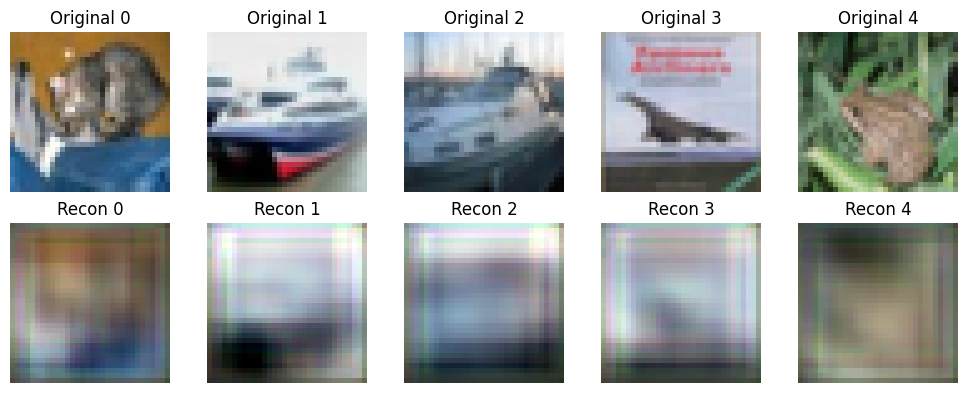

In [37]:
from PIL import Image
import matplotlib.pyplot as plt

# Số lượng cặp ảnh
num_samples = 5

plt.figure(figsize=(10, 4))

for i in range(num_samples):
    path = f"sample_{i}_original.pnm"
    img = Image.open(path)

    plt.subplot(2, num_samples, i + 1)   # hàng 1
    plt.imshow(img)
    plt.title(f"Original {i}")
    plt.axis("off")

for i in range(num_samples):
    path = f"sample_{i}_reconstructed.pnm"
    img = Image.open(path)

    plt.subplot(2, num_samples, num_samples + i + 1)   # hàng 2
    plt.imshow(img)
    plt.title(f"Recon {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()
